In [1]:
import pandas as pd 
import numpy as np
from numpy import array
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
from ipynb.fs.full.evaluation import *
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from ipynb.fs.full.Data_Processing import *
from sklearn import preprocessing
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
torch.set_printoptions(linewidth=120) #Display options for output
torch.set_grad_enabled(True) # Already on by default
torch.manual_seed(0)
from torch_lr_finder import LRFinder
import pickle
import torch.utils.data as data_utils
from collections import namedtuple
import time
from sklearn.model_selection import KFold
from pytorchtools import EarlyStopping

In [2]:
cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True




### CNN

In [3]:
class EEGNet(nn.Module):
    def __init__(self, num_classes, combined, fc_size):
        super(EEGNet, self).__init__()
        self.T = 120
        self.combined = combined
        self.fc_size = fc_size
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 8), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints. 
        self.fc1 = nn.Linear(fc_size, num_classes)
        
    def forward(self, x):
        # Layer 1
        x = x.float()
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.9)
        x = x.permute(0, 3, 1, 2)

        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.9)
        x = self.pooling2(x)

        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.9)
        x = self.pooling3(x)
 
        # FC Layer
        x = x.view(-1, self.fc_size)
        if self.combined == False:       
            x = self.fc1(x)
        return x
    

    
    # for 60 timepoints = 4*2*4 and -1
    # 120 timepoints = 4* 2* 7 and -1
    # https://discuss.pytorch.org/t/runtimeerror-shape-1-400-is-invalid-for-input-of-size/33354
    # https://discuss.pytorch.org/t/valueerror-expected-input-batch-size-324-to-match-target-batch-size-4/24498/2

### CNN + RNN

https://ai.stackexchange.com/questions/3156/how-to-select-number-of-hidden-layers-and-number-of-memory-cells-in-an-lstm

In [4]:
   

class Combine(nn.Module):
    def __init__(self, num_classes, combined, fc_size):
        super(Combine, self).__init__()
        self.cnn = EEGNet(num_classes,combined, fc_size)
        self.rnn = nn.LSTM(
            input_size=fc_size, 
            hidden_size=16, 
            num_layers=1,
            batch_first=True)
        self.linear = nn.Linear(16 ,num_classes)

    def forward(self, x):
        batch_size, C, timepoints, channels = x.size()
        c_in = x
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, -1 , c_out.shape[1])
        r_out, (h_n, h_c) = self.rnn(r_in)
        r_out2 = self.linear(r_out[:, -1, :])
        
        return F.log_softmax(r_out2, dim=1)
    

**Evaluate function returns values of different criteria like accuracy, precision etc.**
In case you face memory overflow issues, use batch size to control how many samples get evaluated at one time. Use a batch_size that is a factor of length of samples. This ensures that you won't miss any samples.

In [5]:
def evaluate(model, X, Y, params = ["acc"]):
    results = []
    batch_size = 100
    
    predicted = []
    
    for i in range(len(X)//batch_size):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = Variable(torch.from_numpy(X[s:e]))
        pred = model(inputs)
        
        predicted.append(pred.data.cpu().numpy())
        
        
    inputs = Variable(torch.from_numpy(X))
    predicted = model(inputs)
    
    predicted = predicted.data.cpu().numpy()
    
    for param in params:
        if param == 'acc':
            results.append(accuracy_score(Y, np.round(predicted)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted , multi_class="ovr"))
        if param == "recall":
            results.append(recall_score(Y, np.round(predicted), average='macro'))
        if param == "precision":
            results.append(precision_score(Y, np.round(predicted) , average='macro'))
        if param == "fmeasure":
            precision = precision_score(Y, np.round(predicted) , average='macro')
            recall = recall_score(Y, np.round(predicted) , average='macro')
            results.append(2*precision*recall/ (precision+recall))
    return results

**Generate random data**
    
*Data format:*

Datatype - float32 (both X and Y)

X.shape - (#samples, 1, #timepoints, #channels)

Y.shape - (#samples)

In [6]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()### Scale the data

In [7]:
def learning_rate_finder():
    model = EEGNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
    lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
    lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")
    lr_finder.plot()

In [8]:
def get_accuracy(loader, net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs = data[0].to(device)
            labels = data[1].to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = (correct/total * 100)
    return acc

In [9]:
def predict(loader, net):
    correct = 0
    total = 0
    predictions = []
    with torch.no_grad():
        for data in loader:
            inputs = data[0].to(device)
            labels = data[1].to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = (correct/total * 100)
    return np.concatenate(predictions)

In [10]:
def train(X_train, train_loader, valid_loader,  num_classes, model, n_epochs, patience, train_verbose, fc_size):
    
    # choose between the EEGNet or EEGNet + RNN
    if model == 'EEGNet':
        net = EEGNet(num_classes, False, fc_size).to(device)
    if model == 'Hybrid':
        net = Combine(num_classes, True, fc_size).to(device)
        
    #store the predictions and the losses
    preds_list = [] # track the predictions
    labels_list = [] # track the labels
    train_losses = [] # to track the train loss as the model trains
    valid_losses = [] # to track the validation loss as the model trains
    avg_train_losses = [] # to track the average training loss per epoch as the model trains
    avg_valid_losses = [] # to track the average validation loss per epoch as the model trains
    
    #Set the optimiser 
    optimizer = optim.Adam(net.parameters(), lr = 0.001)
    #Initialise the early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=train_verbose)

    for epoch in range(n_epochs):
        total_loss = 0
        total_correct = 0

        net.train() # prep the model for training
        for batch in train_loader:

            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            
            preds = net(inputs) #forward pass: compute predicted outputs by passing inputs to the model
            criterion=nn.BCEWithLogitsLoss() # calculate the loss
            loss = F.cross_entropy(preds, labels.long()) # calculate loss
            optimizer.zero_grad()# clear the gradients of all optimized variables
            loss.backward()  # backward pass: compute gradient of the loss with respect to model parameters
            optimizer.step() # perform a single optimization step (parameter update)
            train_losses.append(loss.item()) # record training loss
            
            #record the predictions and losses
            preds_list.append(preds)
            labels_list.append(labels)
            total_loss += loss.item()
            total_correct += get_num_correct(preds, labels)
            
        ######################    
        # validate the model #
        ######################
        net.eval() # prep model for evaluation
        for batch in valid_loader:
            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            
            # forward pass: compute predicted outputs by passing inputs to the model
            preds = net(inputs)
            # calculate the loss
            loss = F.cross_entropy(preds, labels.long())
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'epoch: [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} '+
                     f'train_accuracy: {total_correct/len(X_train):.5f}' )
        
        if train_verbose == True: print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, net)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break       
        
    # load the last checkpoint with the best model
    net.load_state_dict(torch.load('checkpoint.pt'))
    
    return net, avg_train_losses, avg_valid_losses

### Training and testing

In [11]:
def standardise(X_train, X_valid):
    # standardize per channel
    means = X_train.mean(axis=(0,2), keepdims=True)
    stds = X_train.std(axis=(0,2), keepdims=True)
    X_train = (X_train - means) / (stds)
    X_valid = (X_valid - means) / (stds)
    return X_train, X_valid


In [12]:
def average(lst): 
    return sum(lst) / len(lst)

In [13]:
def categorise(y_train, y_valid):
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_valid = le.transform(y_valid)
    return y_train, y_valid, le

In [14]:
def save_plots(model_type, y_true, y_pred, user, label, n_epochs, model, eval_type, train_loss, valid_loss, bandpass ):
    if model_type == 'clf':
        # plot confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        saved_file = "results/CNN/clf/confusion/k fold/{3}/{4}/User_{0}_{1}_epochs_{2}_bandpass_{5}_multiple_{6}_sigma_{7}.png".format(user,label,
                                                                                                                            n_epochs,model, 
                                                                                                                            eval_type, 
                                                                                                                            bandpass, multiple,sigma)
        plot_confusion_matrix(cm, set(y_true), saved_file ,normalize=True)
        
        #plot model
    if model_type == 'reg':
        saved_file = "results/CNN/reg/y vs y_pred/{3}/{4}/User_{0}_{1}_epochs_{2}_bandpass_{5}_multiple_{6}_sigma_{7}.png".format(user,label, n_epochs,model,
                                                                                                                                  eval_type, 
                                                                                                                                  bandpass, multiple,sigma)
        plot_model(y_true, y_pred, user, label,file=saved_file)
    
    saved_file = "results/CNN/clf/loss curves/k fold/{3}/{4}/User_{0}_{1}_epochs_{2}_bandpass_{5}_multiple_{6}_sigma_{7}.png".format(user,label,n_epochs,
                                                                                                                                     model, eval_type, bandpass
                                                                                                                                    multiple,sigma)
    plot_loss_early_stop(train_loss, valid_loss, saved_file)

In [15]:
def get_loaders(X_train, X_valid, y_train, y_valid):
    
    #Convert to 4D 
    X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1],X_train.shape[2])
    X_valid = X_valid.reshape(X_valid.shape[0],1, X_valid.shape[1],X_valid.shape[2])

    # Create train and valid loader
    train = data_utils.TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train).long())
    valid = data_utils.TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))
    train_loader = data_utils.DataLoader(train, batch_size=50, shuffle=True)
    valid_loader = data_utils.DataLoader(valid, batch_size=50, shuffle=False)       
    return train_loader, valid_loader

In [16]:
def multiply(data, multiple):
    """
    Method for multiplying a dataset
    :data: chosen dataset
    :multiply: chosen number to multiply the dataset
    """
    data_list = []
    for i in range (multiple):
        data_list.append(data)
    data = np.concatenate(data_list)
    return data


# Gaussian noise

# https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.random.normal.html

def add_gaussian_noise(clean_signal, multiple, sigma):
    """
    Method for multiplying a given dataset and adding gausian noise
    :clean_signal: clean dataset without noise
    :multiple: chosen number to multiply the dataset
    :sigma: standard deviation
    """
    print("Starting size: {0}".format(clean_signal.shape))
    #multiply the dataset
    clean_signal = multiply(clean_signal, multiple)

    # add noise to the dataset based on the shape of the multiplied dataset
    mu = 0 # average needs to be zero to generate gaussian noise
    noise = np.random.normal(mu, sigma, clean_signal.shape)
    noisy_signal = clean_signal + noise
    print("End size: {0}".format(noisy_signal.shape))
    return noisy_signal




In [17]:
def check_if_valid_labels_are_in_train(train_classes, valid_classes):
    """
    Method for checking whether the valid labels are in the training set
    :train_classes: 
    :valid_classes: 
    """
    for valid_class in valid_classes:
        if valid_class not in train_classes:
            return False
        
    return True

        

In [18]:
def kfold_predict(X,y, model_type, model, n_epochs, train_verbose, patience, fc_size, multiple, sigma, augment):
    """
    Method for running 5 fold cross validation based on a given array of tests
    """
    kf= KFold(n_splits = 5, shuffle = True, random_state =  1)
    
    if model_type == 'clf':
        results = {"Accuracy":[], "Precision":[], "Recall":[], "F1 Score Macro":[],
              "F1 Score Micro":[],"Balanced Accuracy":[]}
    else:
        results = {'RMSE':[], 'R2':[]}
        
    total_predictions = []
    total_true = []
    num_classes = 0
    accuracy = []
    fold = 0
    for train_index, test_index in kf.split(X):
        
        #Train/valid split
        X_train, X_valid = np.concatenate(X[train_index]), np.concatenate(X[test_index])
        y_train, y_valid = np.concatenate(y[train_index]).astype('int'), np.concatenate(y[test_index]).astype('int')
        
        
        # check the the classes in the validation set, if there are not in training set then skip
        y_valid_classes = list(set(y_valid))
        y_train_classes = list(set(y_train))
        
        if check_if_valid_labels_are_in_train(y_train_classes, y_valid_classes) == False: 
            continue
   
        
        #standardise per channel
        X_train, X_valid = standardise(X_train, X_valid)
        
        #label the categorical variables
        y_train, y_valid, le = categorise(y_train, y_valid)
        
        # augment training samples
        if augment == True:
            X_train = add_gaussian_noise(X_train, multiple, sigma)
            y_train = multiply(y_train, multiple)
        
        size = len(X_train) + len(X_valid)
        #get loaders
        train_loader, valid_loader = get_loaders(X_train, X_valid, y_train, y_valid)
        
         # count the number of classes
        if len(set(y_train)) > num_classes:
            num_classes = len(set(y_train))
       
        # train the network
        time_start = time.time()
        net, train_loss, valid_loss = train(X_train, train_loader, valid_loader, 
                    num_classes, model, n_epochs, patience, train_verbose, fc_size)
        fold += 1 
        print('Fold  {0}! Time elapsed: {1} seconds'.format(fold, time.time()-time_start))
        
        # make predictions
        y_pred = le.inverse_transform(predict(valid_loader, net))
        y_true = le.inverse_transform(y_valid)
     
        #save total predictions and get results
        total_predictions.append(y_pred)
        total_true.append(y_true) 
        r = get_results(y_true, y_pred, model_type) #returns a dictionary of results   
        valid_acc = get_accuracy(valid_loader, net)
        for key in r: # loop through dictionary to add to all the scores to the results dictionary
            results[key].append(r[key])
        accuracy.append(valid_acc)

    for key in results: # average out the results 
        results[key] = average(results[key])
    accuracy = average(accuracy)
    total_predictions = np.concatenate(total_predictions)
    total_true = np.concatenate(total_true)
        
        
    return results, total_predictions , total_true , num_classes , size , accuracy, train_loss, valid_loss




#get results
#         Results = namedtuple("Results","label train_acc test_acc user")
#         train_acc = get_accuracy(train_loader, test_loader, "train", net)
#         test_acc = get_accuracy(train_loader, test_loader, "test", net)
#         print("{0} results on User 1\ntrain_acc: {1}\tsample_size: {2}\ntest_acc: {3}\tsample_size: {4}\n".format(label, 
#                                                                                                train_acc,  len(X_train),
#                                                                                                 test_acc, len(X_test)))
#         results.append(Results(label, train_acc, test_acc,1))

In [19]:

# bandpass = load_file("/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_120_window_annotated_EEG_agg_bandpass_True_slider_120.pickle")
# no_p = load_file("/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_120_window_annotated_EEG_agg_bandpass_False_slider_120.pickle")

# bandpass_lgbm = load_file("/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_120_window_annotated_EEG_agg_bandpass.pickle")
# bandpass[1]['inputs']

Working on label attention
Starting size: (14968, 120, 8)
End size: (74840, 120, 8)
Early stopping
Fold  1! Time elapsed: 82.9005355834961 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting size: (15999, 120, 8)
End size: (79995, 120, 8)
Early stopping
Fold  2! Time elapsed: 85.9965136051178 seconds
Starting size: (15803, 120, 8)
End size: (79015, 120, 8)
Early stopping
Fold  3! Time elapsed: 85.03118515014648 seconds
Starting size: (19117, 120, 8)
End size: (95585, 120, 8)
Early stopping
Fold  4! Time elapsed: 101.29510021209717 seconds
Starting size: (17117, 120, 8)
End size: (85585, 120, 8)
Early stopping
Fold  5! Time elapsed: 91.16744494438171 seconds
Normalized confusion matrix


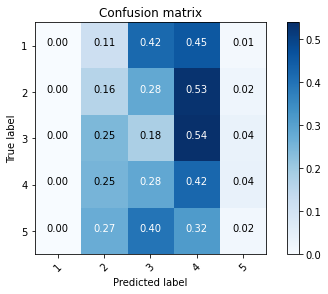

<Figure size 432x288 with 0 Axes>

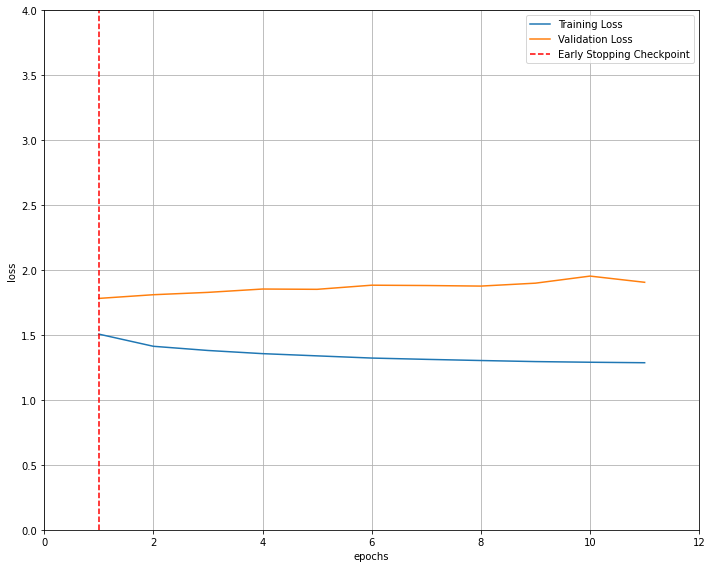

Finished analysis on label attention. Time elapsed 467.07681131362915
Working on label interest
Starting size: (14968, 120, 8)
End size: (74840, 120, 8)
Early stopping
Fold  1! Time elapsed: 80.66517281532288 seconds
Starting size: (15999, 120, 8)
End size: (79995, 120, 8)
Early stopping
Fold  2! Time elapsed: 93.46168875694275 seconds
Starting size: (15803, 120, 8)
End size: (79015, 120, 8)
Early stopping
Fold  3! Time elapsed: 93.39361691474915 seconds
Starting size: (19117, 120, 8)
End size: (95585, 120, 8)
Early stopping
Fold  4! Time elapsed: 101.01809620857239 seconds
Starting size: (17117, 120, 8)
End size: (85585, 120, 8)
Early stopping
Fold  5! Time elapsed: 132.76918148994446 seconds
Normalized confusion matrix


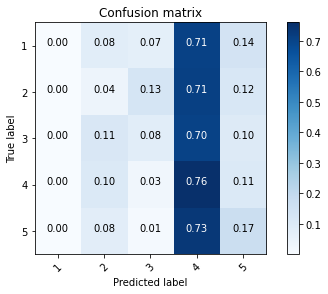

<Figure size 432x288 with 0 Axes>

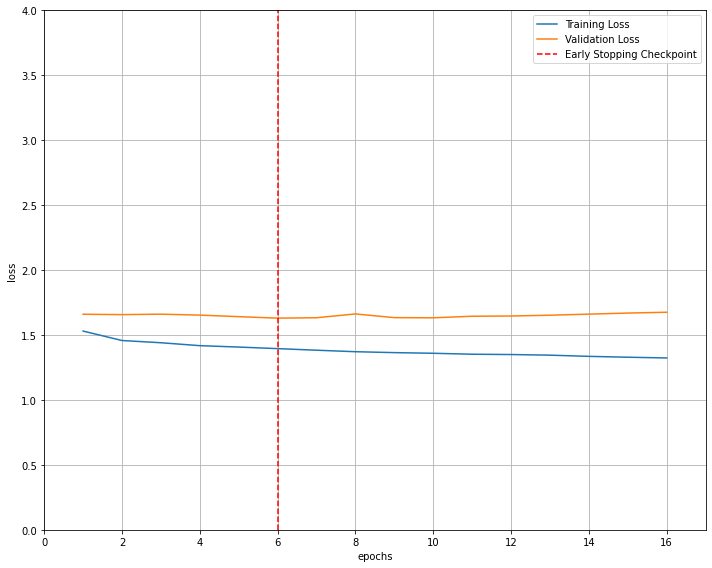

Finished analysis on label interest. Time elapsed 522.068740606308
Working on label effort
Starting size: (14968, 120, 8)
End size: (74840, 120, 8)
Early stopping
Fold  1! Time elapsed: 80.65184545516968 seconds
Starting size: (15999, 120, 8)
End size: (79995, 120, 8)
Early stopping
Fold  2! Time elapsed: 85.83461594581604 seconds
Starting size: (15803, 120, 8)
End size: (79015, 120, 8)
Early stopping
Fold  3! Time elapsed: 84.72831678390503 seconds
Starting size: (19117, 120, 8)
End size: (95585, 120, 8)
Early stopping
Fold  4! Time elapsed: 110.49433541297913 seconds
Starting size: (17117, 120, 8)
End size: (85585, 120, 8)
Early stopping
Fold  5! Time elapsed: 91.24183464050293 seconds
Normalized confusion matrix


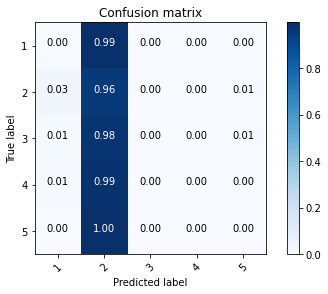

<Figure size 432x288 with 0 Axes>

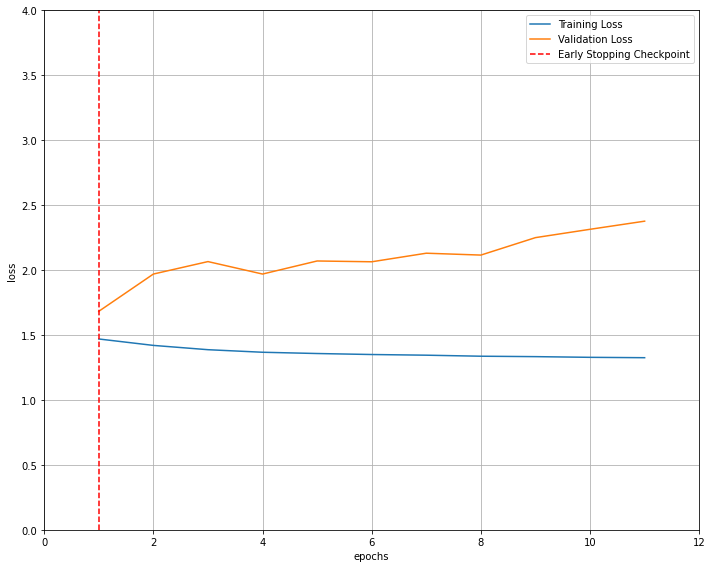

Finished analysis on label effort. Time elapsed 473.7139415740967
Finished analysis on User all
All analyses are complete! Time elapsed: 1462.9535524845123
Working on user 1
Starting size: (531, 120, 8)
End size: (2655, 120, 8)
Early stopping
Fold  1! Time elapsed: 5.072067499160767 seconds
Starting size: (526, 120, 8)
End size: (2630, 120, 8)
Early stopping
Fold  2! Time elapsed: 8.190808057785034 seconds
Starting size: (559, 120, 8)
End size: (2795, 120, 8)
Early stopping
Fold  3! Time elapsed: 8.562536478042603 seconds
Starting size: (536, 120, 8)
End size: (2680, 120, 8)
Early stopping
Fold  4! Time elapsed: 5.401954650878906 seconds
Normalized confusion matrix


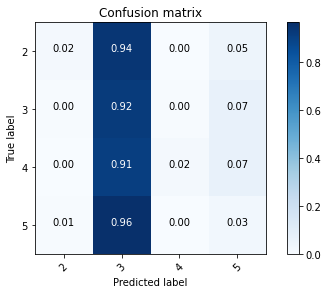

<Figure size 432x288 with 0 Axes>

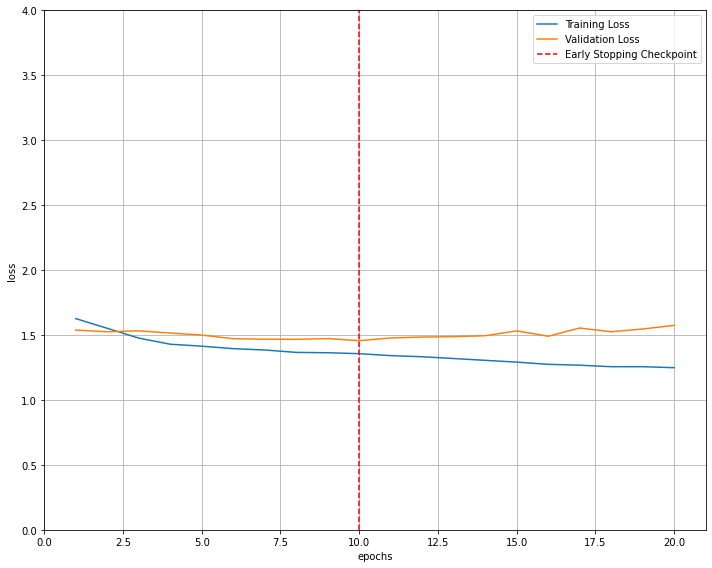

Finished analysis on User 1_attention
Starting size: (580, 120, 8)
End size: (2900, 120, 8)
Early stopping
Fold  1! Time elapsed: 3.1203980445861816 seconds
Starting size: (526, 120, 8)
End size: (2630, 120, 8)


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Early stopping
Fold  2! Time elapsed: 4.169329643249512 seconds
Starting size: (559, 120, 8)
End size: (2795, 120, 8)
Early stopping
Fold  3! Time elapsed: 6.079803705215454 seconds
Starting size: (536, 120, 8)
End size: (2680, 120, 8)
Early stopping
Fold  4! Time elapsed: 3.9853851795196533 seconds
Normalized confusion matrix


ipynb.fs.full.evaluation:51: RuntimeWarning: invalid value encountered in true_divide


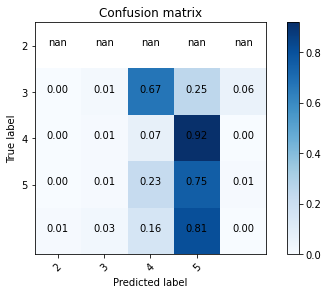

<Figure size 432x288 with 0 Axes>

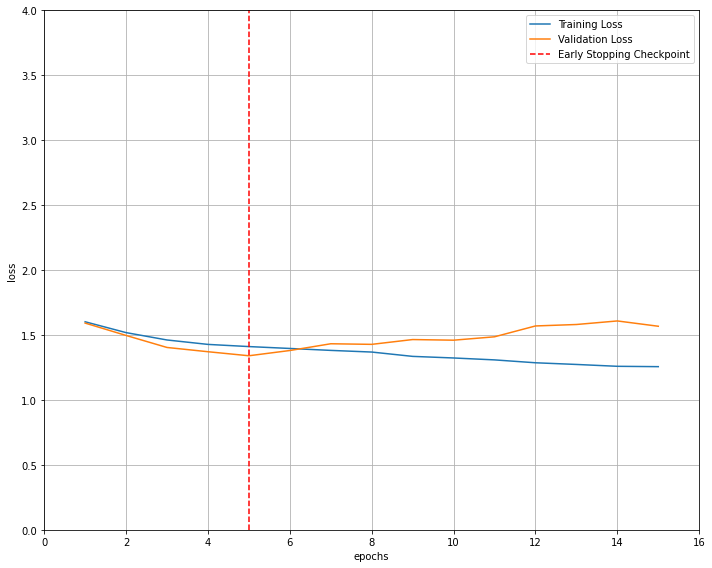

Finished analysis on User 1_interest
Starting size: (531, 120, 8)
End size: (2655, 120, 8)
Early stopping
Fold  1! Time elapsed: 2.902431011199951 seconds
Starting size: (580, 120, 8)
End size: (2900, 120, 8)
Early stopping
Fold  2! Time elapsed: 3.5139317512512207 seconds
Starting size: (526, 120, 8)
End size: (2630, 120, 8)
Early stopping
Fold  3! Time elapsed: 3.384697914123535 seconds
Starting size: (559, 120, 8)
End size: (2795, 120, 8)
Early stopping
Fold  4! Time elapsed: 4.963513612747192 seconds
Starting size: (536, 120, 8)
End size: (2680, 120, 8)
Early stopping
Fold  5! Time elapsed: 9.238526582717896 seconds
Normalized confusion matrix


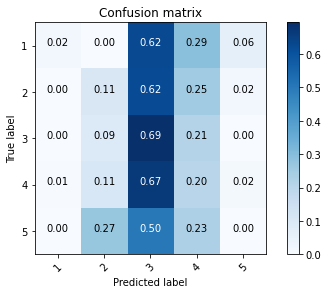

<Figure size 432x288 with 0 Axes>

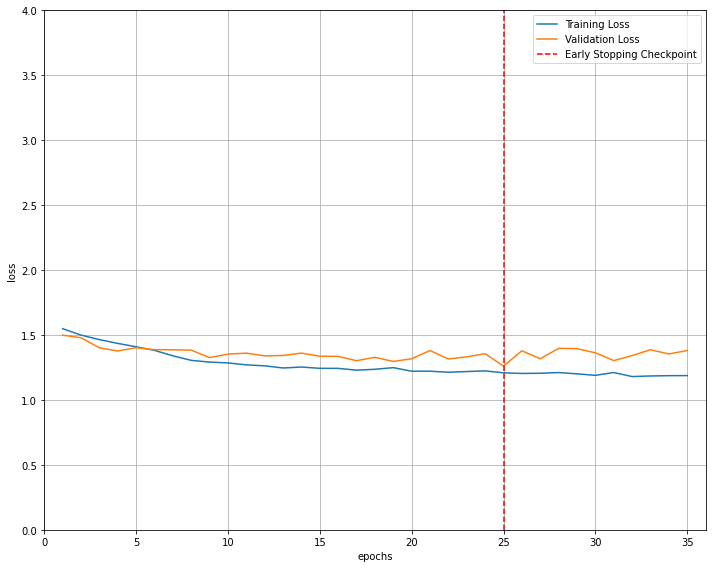

Finished analysis on User 1_effort
Finished analysis on User 1
Working on user 2
Starting size: (993, 120, 8)
End size: (4965, 120, 8)
Early stopping
Fold  1! Time elapsed: 15.178851842880249 seconds
Starting size: (975, 120, 8)
End size: (4875, 120, 8)
Early stopping
Fold  2! Time elapsed: 7.775837421417236 seconds
Starting size: (1044, 120, 8)
End size: (5220, 120, 8)
Early stopping
Fold  3! Time elapsed: 7.799483060836792 seconds
Starting size: (1066, 120, 8)
End size: (5330, 120, 8)
Early stopping
Fold  4! Time elapsed: 6.777545213699341 seconds
Normalized confusion matrix


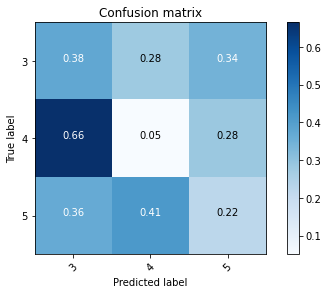

<Figure size 432x288 with 0 Axes>

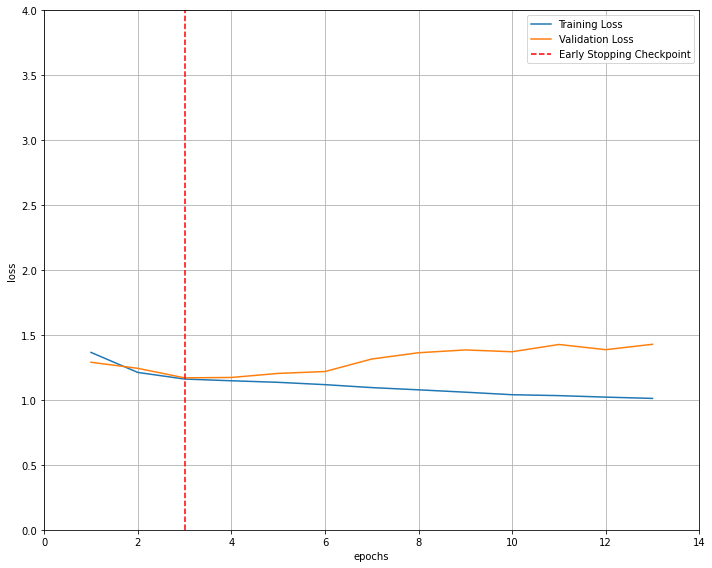

Finished analysis on User 2_attention
Starting size: (970, 120, 8)
End size: (4850, 120, 8)
Early stopping
Fold  1! Time elapsed: 8.111101150512695 seconds
Starting size: (975, 120, 8)
End size: (4875, 120, 8)
Early stopping
Fold  2! Time elapsed: 9.710190057754517 seconds
Starting size: (1044, 120, 8)
End size: (5220, 120, 8)
Early stopping
Fold  3! Time elapsed: 25.609932899475098 seconds
Starting size: (1066, 120, 8)
End size: (5330, 120, 8)
Early stopping
Fold  4! Time elapsed: 6.7345359325408936 seconds
Normalized confusion matrix


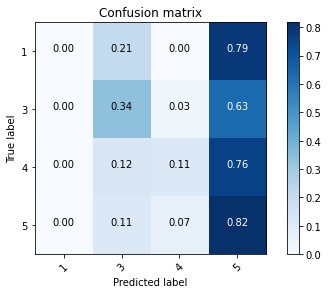

<Figure size 432x288 with 0 Axes>

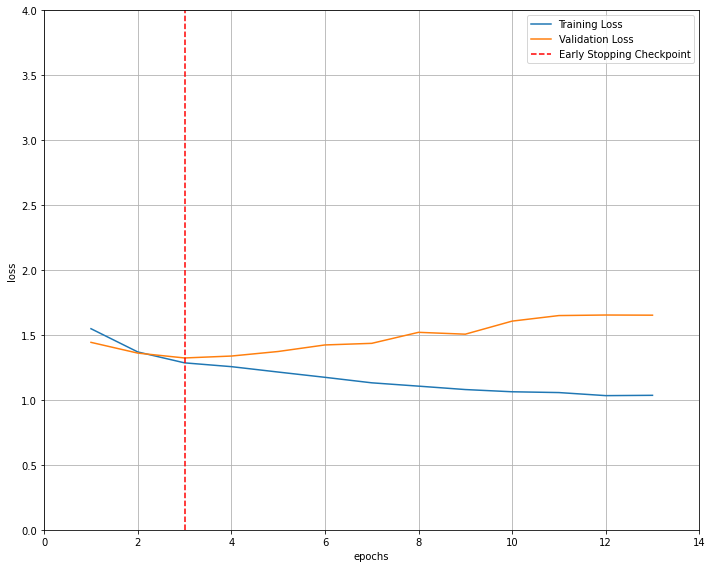

Finished analysis on User 2_interest
Starting size: (970, 120, 8)
End size: (4850, 120, 8)
Early stopping
Fold  1! Time elapsed: 6.649827718734741 seconds
Starting size: (993, 120, 8)
End size: (4965, 120, 8)
Early stopping
Fold  2! Time elapsed: 6.3404457569122314 seconds
Starting size: (975, 120, 8)
End size: (4875, 120, 8)
Early stopping
Fold  3! Time elapsed: 8.604299068450928 seconds
Starting size: (1044, 120, 8)
End size: (5220, 120, 8)
Early stopping
Fold  4! Time elapsed: 5.6094725131988525 seconds
Starting size: (1066, 120, 8)
End size: (5330, 120, 8)
Early stopping
Fold  5! Time elapsed: 5.683159112930298 seconds
Normalized confusion matrix


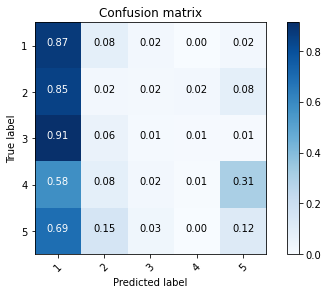

<Figure size 432x288 with 0 Axes>

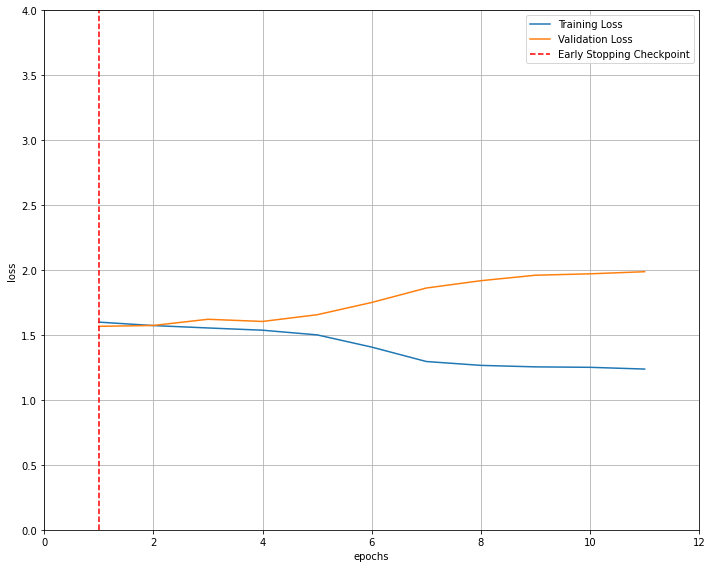

Finished analysis on User 2_effort
Finished analysis on User 2
Working on user 3
Starting size: (898, 120, 8)
End size: (4490, 120, 8)
Early stopping
Fold  1! Time elapsed: 15.880095958709717 seconds
Starting size: (904, 120, 8)
End size: (4520, 120, 8)
Early stopping
Fold  2! Time elapsed: 9.0802640914917 seconds
Starting size: (990, 120, 8)
End size: (4950, 120, 8)
Early stopping
Fold  3! Time elapsed: 5.764869451522827 seconds
Starting size: (858, 120, 8)
End size: (4290, 120, 8)
Early stopping
Fold  4! Time elapsed: 5.9627509117126465 seconds
Starting size: (1046, 120, 8)
End size: (5230, 120, 8)
Early stopping
Fold  5! Time elapsed: 13.238242864608765 seconds
Normalized confusion matrix


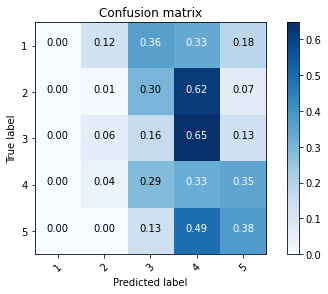

<Figure size 432x288 with 0 Axes>

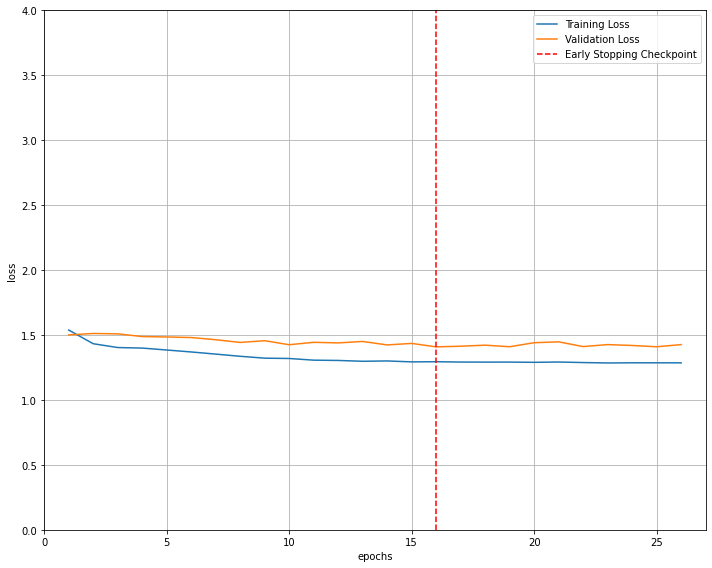

Finished analysis on User 3_attention
Starting size: (898, 120, 8)
End size: (4490, 120, 8)
Early stopping
Fold  1! Time elapsed: 15.1317138671875 seconds
Starting size: (904, 120, 8)
End size: (4520, 120, 8)
Early stopping
Fold  2! Time elapsed: 20.976506233215332 seconds
Starting size: (990, 120, 8)
End size: (4950, 120, 8)
Early stopping
Fold  3! Time elapsed: 6.2481160163879395 seconds
Starting size: (858, 120, 8)
End size: (4290, 120, 8)
Early stopping
Fold  4! Time elapsed: 15.395020008087158 seconds
Starting size: (1046, 120, 8)
End size: (5230, 120, 8)
Early stopping
Fold  5! Time elapsed: 9.172045230865479 seconds
Normalized confusion matrix


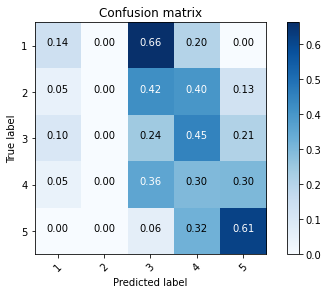

<Figure size 432x288 with 0 Axes>

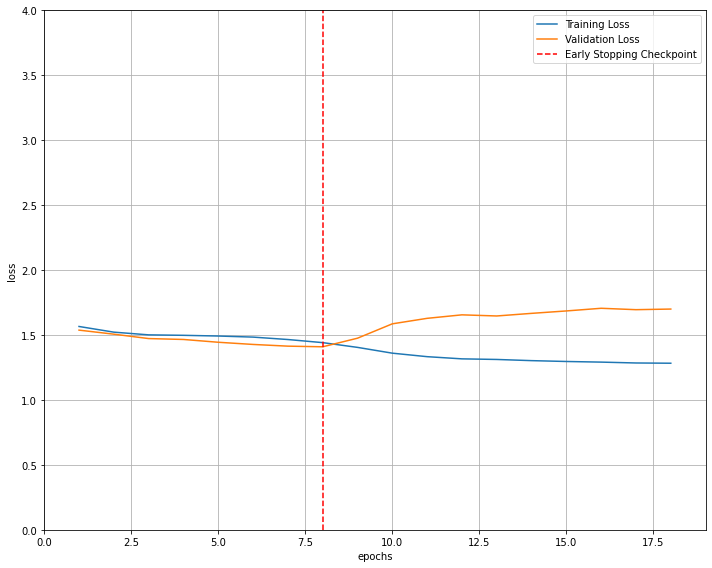

Finished analysis on User 3_interest
Starting size: (898, 120, 8)
End size: (4490, 120, 8)
Early stopping
Fold  1! Time elapsed: 4.8345654010772705 seconds
Starting size: (904, 120, 8)
End size: (4520, 120, 8)
Early stopping
Fold  2! Time elapsed: 4.900830268859863 seconds
Starting size: (990, 120, 8)
End size: (4950, 120, 8)
Early stopping
Fold  3! Time elapsed: 5.76471471786499 seconds
Starting size: (858, 120, 8)
End size: (4290, 120, 8)
Early stopping
Fold  4! Time elapsed: 5.919782876968384 seconds
Starting size: (1046, 120, 8)
End size: (5230, 120, 8)
Early stopping
Fold  5! Time elapsed: 6.1047890186309814 seconds
Normalized confusion matrix


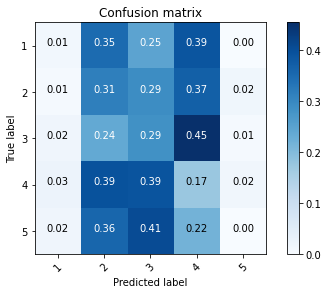

<Figure size 432x288 with 0 Axes>

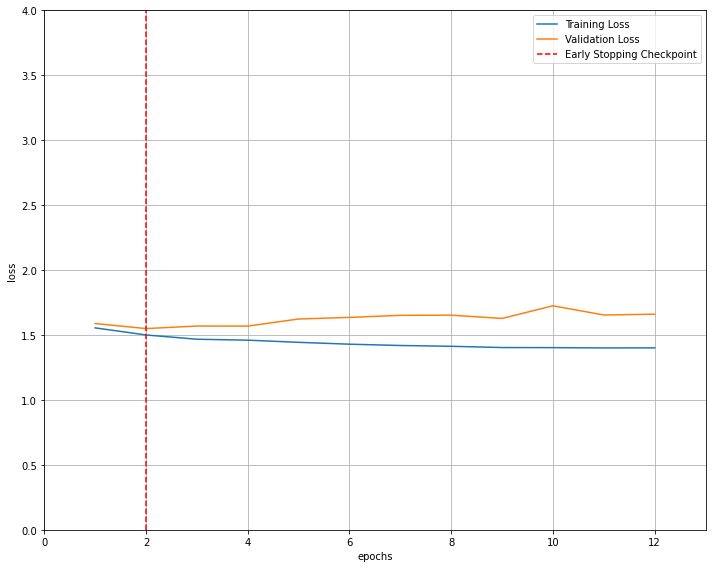

Finished analysis on User 3_effort
Finished analysis on User 3
Working on user 6
Starting size: (1034, 120, 8)
End size: (5170, 120, 8)
Early stopping
Fold  1! Time elapsed: 6.625870943069458 seconds
Starting size: (1168, 120, 8)
End size: (5840, 120, 8)
Early stopping
Fold  2! Time elapsed: 6.228745937347412 seconds
Starting size: (1143, 120, 8)
End size: (5715, 120, 8)
Early stopping
Fold  3! Time elapsed: 6.694487810134888 seconds
Starting size: (1074, 120, 8)
End size: (5370, 120, 8)
Early stopping
Fold  4! Time elapsed: 22.2105929851532 seconds
Starting size: (1145, 120, 8)
End size: (5725, 120, 8)
Early stopping
Fold  5! Time elapsed: 15.10773777961731 seconds
Normalized confusion matrix


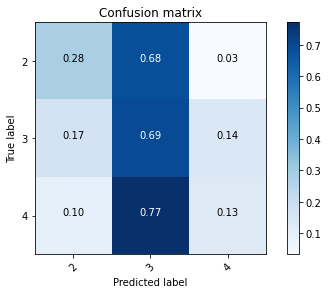

<Figure size 432x288 with 0 Axes>

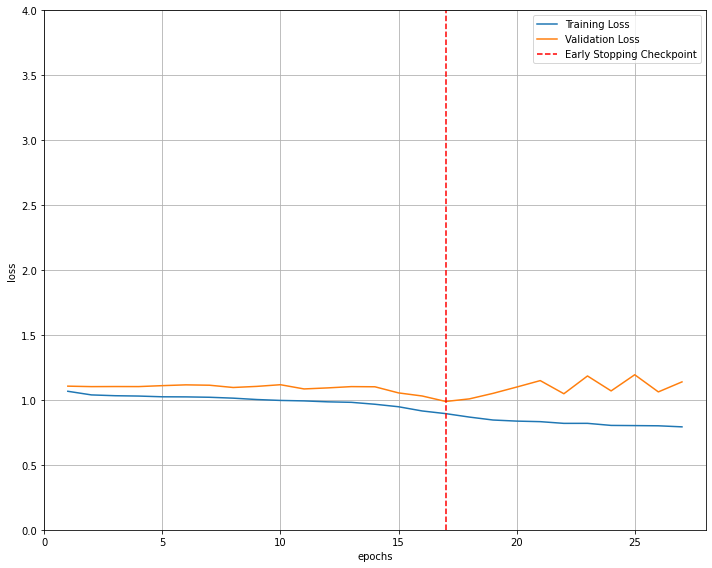

Finished analysis on User 6_attention
Starting size: (1034, 120, 8)
End size: (5170, 120, 8)
Early stopping
Fold  1! Time elapsed: 5.5977702140808105 seconds
Starting size: (1168, 120, 8)
End size: (5840, 120, 8)
Early stopping
Fold  2! Time elapsed: 10.777701616287231 seconds
Starting size: (1143, 120, 8)
End size: (5715, 120, 8)
Early stopping
Fold  3! Time elapsed: 10.025088787078857 seconds
Starting size: (1074, 120, 8)
End size: (5370, 120, 8)
Early stopping
Fold  4! Time elapsed: 5.863691091537476 seconds
Starting size: (1145, 120, 8)
End size: (5725, 120, 8)
Early stopping
Fold  5! Time elapsed: 7.288515090942383 seconds
Normalized confusion matrix


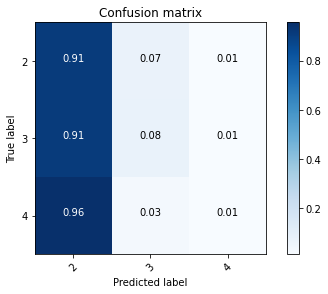

<Figure size 432x288 with 0 Axes>

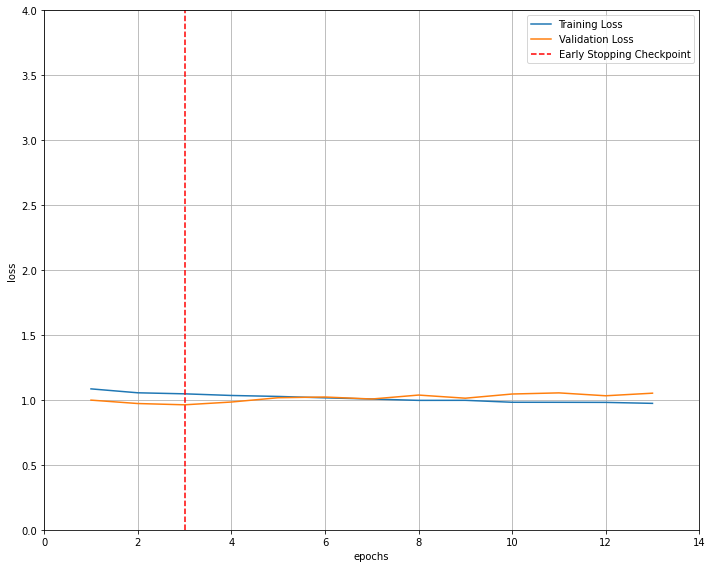

Finished analysis on User 6_interest
Starting size: (1034, 120, 8)
End size: (5170, 120, 8)
Early stopping
Fold  1! Time elapsed: 20.124693393707275 seconds
Starting size: (1168, 120, 8)
End size: (5840, 120, 8)
Early stopping
Fold  2! Time elapsed: 22.353437185287476 seconds
Starting size: (1143, 120, 8)
End size: (5715, 120, 8)
Early stopping
Fold  3! Time elapsed: 7.420115947723389 seconds
Starting size: (1074, 120, 8)
End size: (5370, 120, 8)
Early stopping
Fold  4! Time elapsed: 5.815979719161987 seconds
Starting size: (1145, 120, 8)
End size: (5725, 120, 8)
Early stopping
Fold  5! Time elapsed: 23.82149624824524 seconds
Normalized confusion matrix


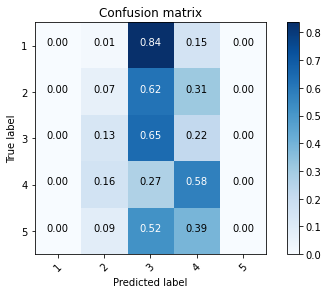

<Figure size 432x288 with 0 Axes>

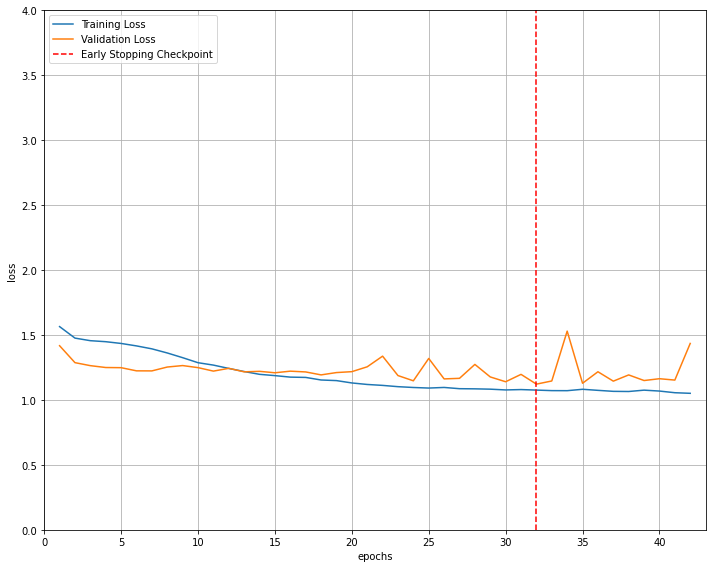

Finished analysis on User 6_effort
Finished analysis on User 6
Working on user 7
Starting size: (1146, 120, 8)
End size: (5730, 120, 8)
Early stopping
Fold  1! Time elapsed: 13.015449523925781 seconds
Starting size: (1117, 120, 8)
End size: (5585, 120, 8)
Early stopping
Fold  2! Time elapsed: 7.684276103973389 seconds
Starting size: (1143, 120, 8)
End size: (5715, 120, 8)
Early stopping
Fold  3! Time elapsed: 10.102620840072632 seconds
Starting size: (1120, 120, 8)
End size: (5600, 120, 8)
Early stopping
Fold  4! Time elapsed: 7.629320859909058 seconds
Normalized confusion matrix


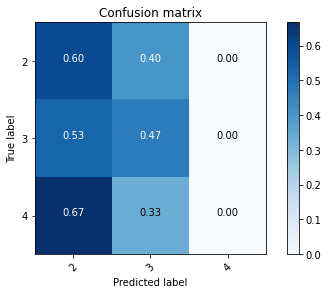

<Figure size 432x288 with 0 Axes>

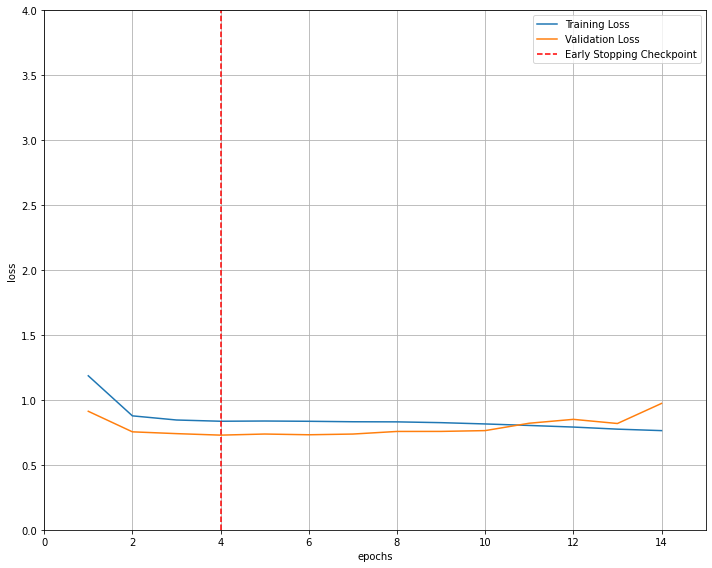

Finished analysis on User 7_attention
Starting size: (1146, 120, 8)
End size: (5730, 120, 8)
Early stopping
Fold  1! Time elapsed: 6.71902060508728 seconds
Starting size: (1117, 120, 8)
End size: (5585, 120, 8)
Early stopping
Fold  2! Time elapsed: 12.045233726501465 seconds
Starting size: (1143, 120, 8)
End size: (5715, 120, 8)
Early stopping
Fold  3! Time elapsed: 15.173532724380493 seconds
Starting size: (1120, 120, 8)
End size: (5600, 120, 8)
Early stopping
Fold  4! Time elapsed: 6.0018150806427 seconds
Normalized confusion matrix


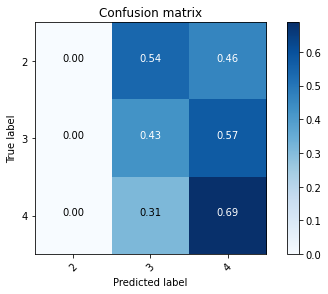

<Figure size 432x288 with 0 Axes>

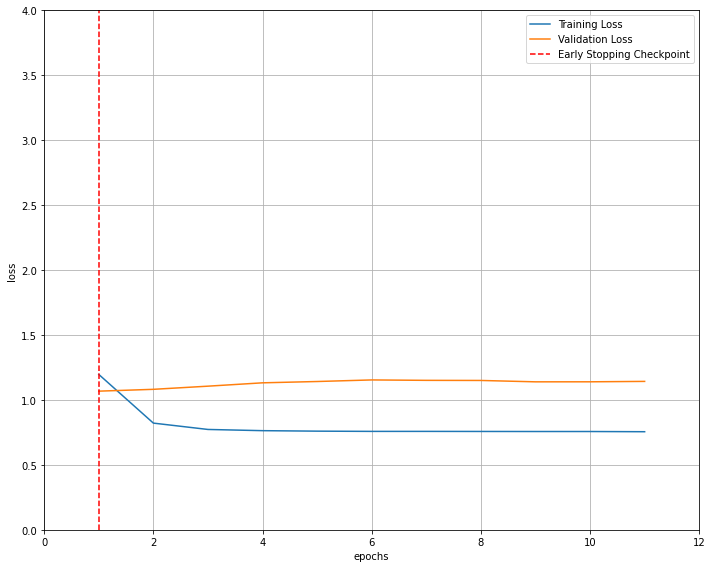

Finished analysis on User 7_interest
Starting size: (1146, 120, 8)
End size: (5730, 120, 8)
Early stopping
Fold  1! Time elapsed: 7.270676612854004 seconds
Starting size: (1138, 120, 8)
End size: (5690, 120, 8)
Early stopping
Fold  2! Time elapsed: 6.132582426071167 seconds
Starting size: (1117, 120, 8)
End size: (5585, 120, 8)
Early stopping
Fold  3! Time elapsed: 16.599172353744507 seconds
Starting size: (1143, 120, 8)
End size: (5715, 120, 8)
Early stopping
Fold  4! Time elapsed: 17.348252058029175 seconds
Starting size: (1120, 120, 8)
End size: (5600, 120, 8)
Early stopping
Fold  5! Time elapsed: 6.5447657108306885 seconds
Normalized confusion matrix


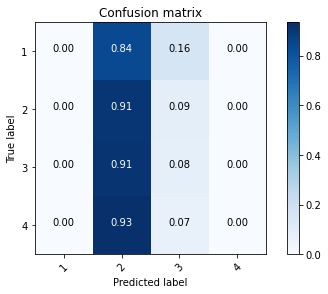

<Figure size 432x288 with 0 Axes>

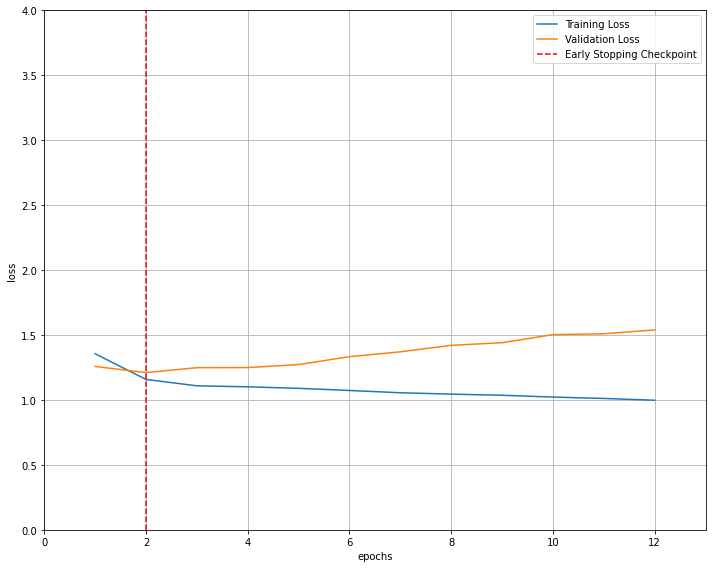

Finished analysis on User 7_effort
Finished analysis on User 7
Working on user 8
Starting size: (1302, 120, 8)
End size: (6510, 120, 8)
Early stopping
Fold  1! Time elapsed: 7.770456075668335 seconds
Starting size: (1406, 120, 8)
End size: (7030, 120, 8)
Early stopping
Fold  2! Time elapsed: 8.278515338897705 seconds
Starting size: (1510, 120, 8)
End size: (7550, 120, 8)
Early stopping
Fold  3! Time elapsed: 16.823554515838623 seconds
Starting size: (1479, 120, 8)
End size: (7395, 120, 8)
Early stopping
Fold  4! Time elapsed: 9.372458696365356 seconds
Starting size: (1575, 120, 8)
End size: (7875, 120, 8)
Early stopping
Fold  5! Time elapsed: 15.315342426300049 seconds
Normalized confusion matrix


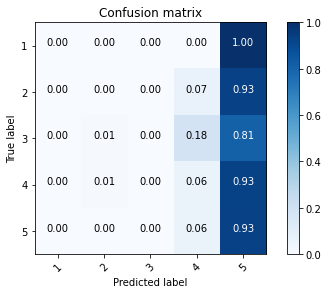

<Figure size 432x288 with 0 Axes>

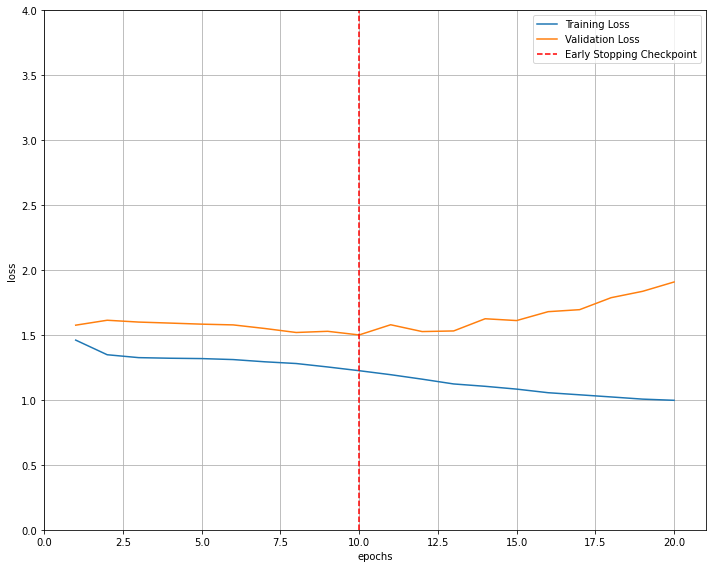

Finished analysis on User 8_attention
Starting size: (1302, 120, 8)
End size: (6510, 120, 8)
Early stopping
Fold  1! Time elapsed: 7.701696872711182 seconds
Starting size: (1406, 120, 8)
End size: (7030, 120, 8)
Early stopping
Fold  2! Time elapsed: 8.930691957473755 seconds
Starting size: (1510, 120, 8)
End size: (7550, 120, 8)
Early stopping
Fold  3! Time elapsed: 16.911787033081055 seconds
Starting size: (1479, 120, 8)
End size: (7395, 120, 8)
Early stopping
Fold  4! Time elapsed: 7.8876025676727295 seconds
Starting size: (1575, 120, 8)
End size: (7875, 120, 8)
Early stopping
Fold  5! Time elapsed: 12.336578369140625 seconds
Normalized confusion matrix


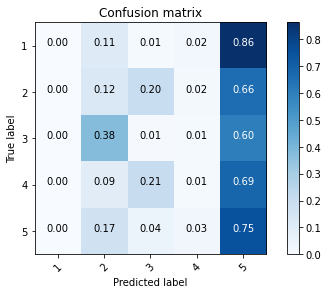

<Figure size 432x288 with 0 Axes>

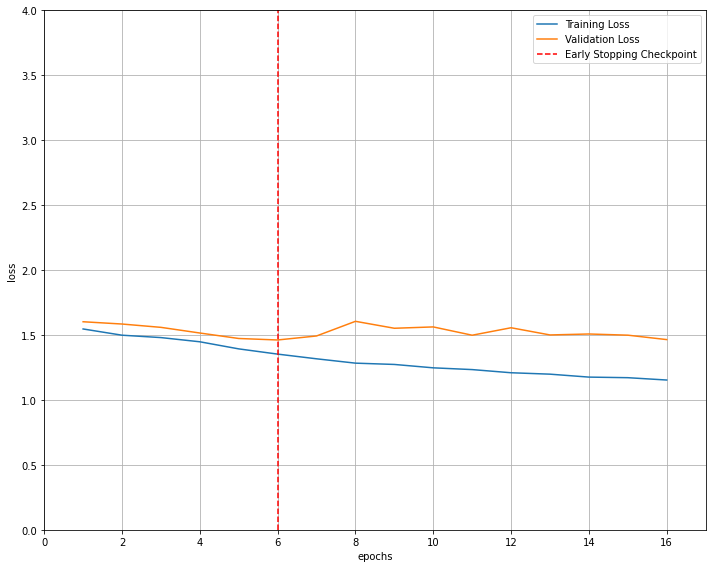

Finished analysis on User 8_interest
Starting size: (1302, 120, 8)
End size: (6510, 120, 8)
Early stopping
Fold  1! Time elapsed: 7.698698997497559 seconds
Starting size: (1406, 120, 8)
End size: (7030, 120, 8)
Early stopping
Fold  2! Time elapsed: 7.570822238922119 seconds
Starting size: (1510, 120, 8)
End size: (7550, 120, 8)
Early stopping
Fold  3! Time elapsed: 8.810860872268677 seconds
Starting size: (1479, 120, 8)
End size: (7395, 120, 8)
Early stopping
Fold  4! Time elapsed: 7.897023677825928 seconds
Starting size: (1575, 120, 8)
End size: (7875, 120, 8)
Early stopping
Fold  5! Time elapsed: 8.4113187789917 seconds
Normalized confusion matrix


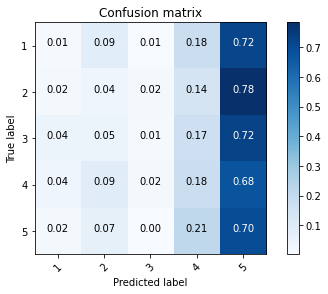

<Figure size 432x288 with 0 Axes>

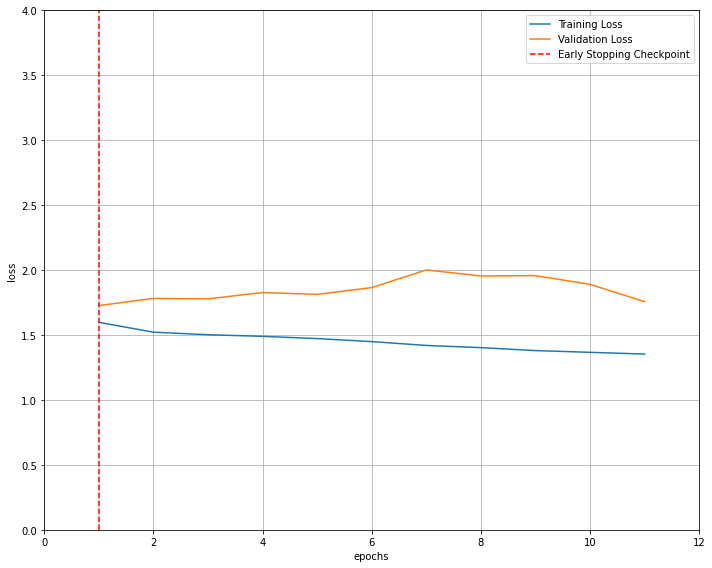

Finished analysis on User 8_effort
Finished analysis on User 8
Working on user 9
Starting size: (1706, 120, 8)
End size: (8530, 120, 8)
Early stopping
Fold  1! Time elapsed: 23.27117919921875 seconds
Starting size: (1677, 120, 8)
End size: (8385, 120, 8)
Early stopping
Fold  2! Time elapsed: 10.604379177093506 seconds
Starting size: (1585, 120, 8)
End size: (7925, 120, 8)
Early stopping
Fold  3! Time elapsed: 10.098874568939209 seconds
Starting size: (1569, 120, 8)
End size: (7845, 120, 8)
Early stopping
Fold  4! Time elapsed: 9.241855382919312 seconds
Starting size: (1727, 120, 8)
End size: (8635, 120, 8)
Early stopping
Fold  5! Time elapsed: 9.191009759902954 seconds
Normalized confusion matrix


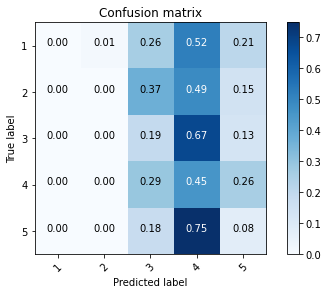

<Figure size 432x288 with 0 Axes>

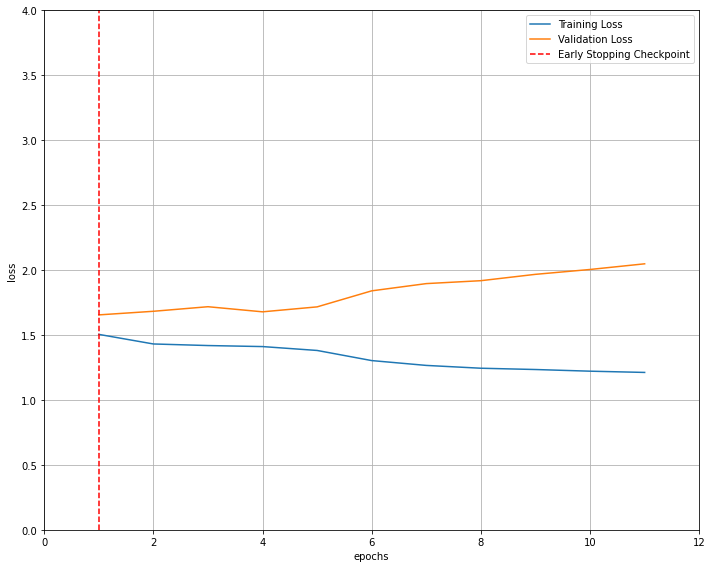

Finished analysis on User 9_attention
Starting size: (1706, 120, 8)
End size: (8530, 120, 8)
Early stopping
Fold  1! Time elapsed: 14.07052493095398 seconds
Starting size: (1677, 120, 8)
End size: (8385, 120, 8)
Early stopping
Fold  2! Time elapsed: 10.591145038604736 seconds
Starting size: (1585, 120, 8)
End size: (7925, 120, 8)
Early stopping
Fold  3! Time elapsed: 10.05566143989563 seconds
Starting size: (1569, 120, 8)
End size: (7845, 120, 8)
Early stopping
Fold  4! Time elapsed: 10.802104234695435 seconds
Starting size: (1727, 120, 8)
End size: (8635, 120, 8)
Early stopping
Fold  5! Time elapsed: 9.207647800445557 seconds
Normalized confusion matrix


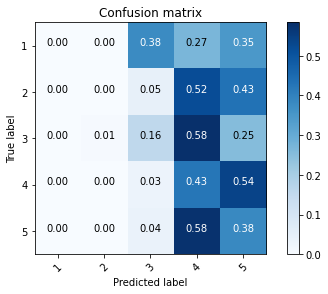

<Figure size 432x288 with 0 Axes>

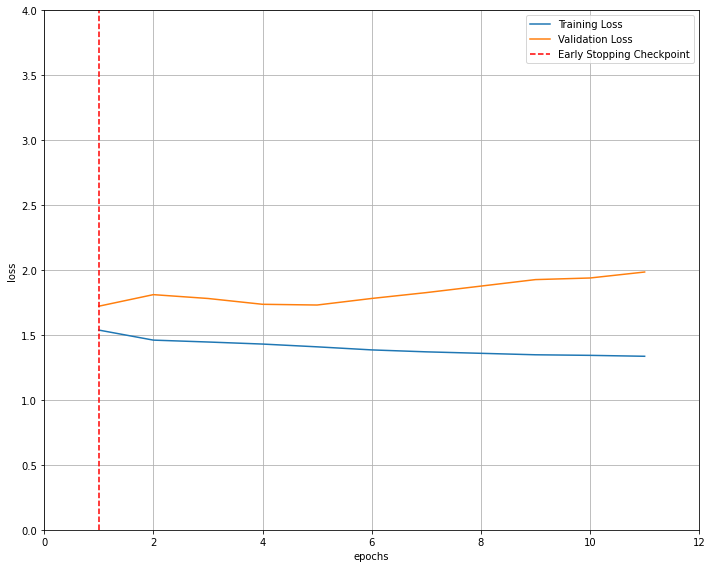

Finished analysis on User 9_interest
Starting size: (1706, 120, 8)
End size: (8530, 120, 8)
Early stopping
Fold  1! Time elapsed: 11.611450910568237 seconds
Starting size: (1677, 120, 8)
End size: (8385, 120, 8)
Early stopping
Fold  2! Time elapsed: 8.956970930099487 seconds
Starting size: (1585, 120, 8)
End size: (7925, 120, 8)
Early stopping
Fold  3! Time elapsed: 10.061466693878174 seconds
Starting size: (1569, 120, 8)
End size: (7845, 120, 8)
Early stopping
Fold  4! Time elapsed: 11.488445043563843 seconds
Starting size: (1727, 120, 8)
End size: (8635, 120, 8)
Early stopping
Fold  5! Time elapsed: 15.103072166442871 seconds
Normalized confusion matrix


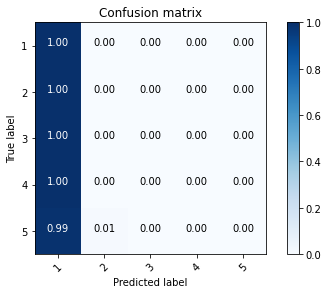

<Figure size 432x288 with 0 Axes>

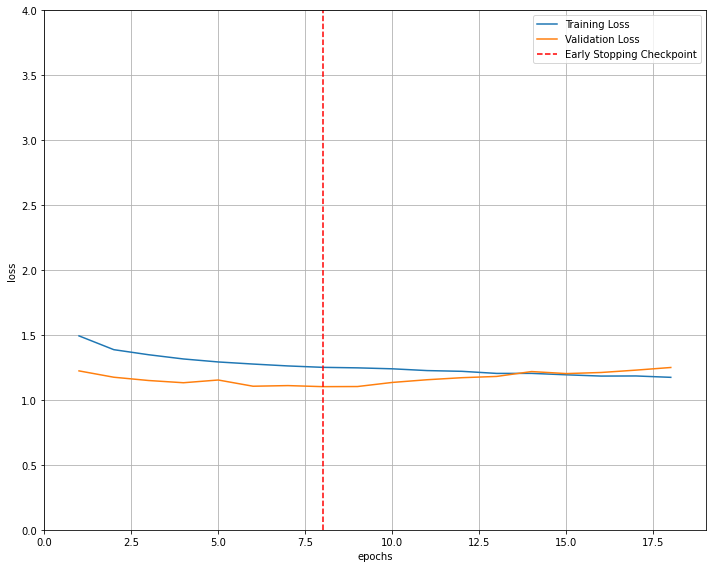

Finished analysis on User 9_effort
Finished analysis on User 9
Working on user 10
Starting size: (221, 120, 8)
End size: (1105, 120, 8)
Early stopping
Fold  1! Time elapsed: 1.2579705715179443 seconds
Starting size: (241, 120, 8)
End size: (1205, 120, 8)
Early stopping
Fold  2! Time elapsed: 1.3412840366363525 seconds
Starting size: (232, 120, 8)
End size: (1160, 120, 8)
Early stopping
Fold  3! Time elapsed: 3.055337905883789 seconds
Starting size: (230, 120, 8)
End size: (1150, 120, 8)
Early stopping
Fold  4! Time elapsed: 2.0466041564941406 seconds
Starting size: (228, 120, 8)
End size: (1140, 120, 8)
Early stopping
Fold  5! Time elapsed: 1.2557084560394287 seconds
Normalized confusion matrix


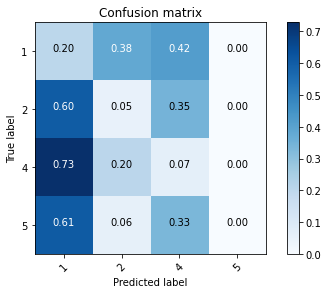

<Figure size 432x288 with 0 Axes>

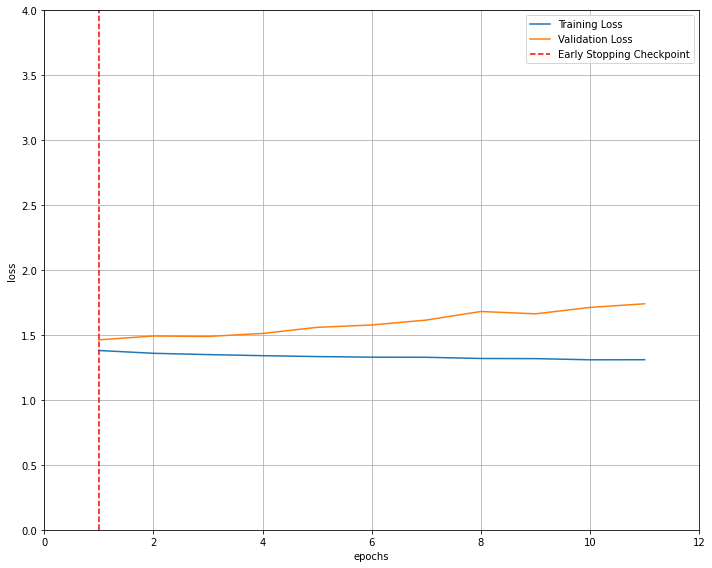

Finished analysis on User 10_attention
Starting size: (221, 120, 8)
End size: (1105, 120, 8)
Early stopping
Fold  1! Time elapsed: 3.118043899536133 seconds
Starting size: (241, 120, 8)
End size: (1205, 120, 8)
Early stopping
Fold  2! Time elapsed: 1.4691188335418701 seconds
Starting size: (232, 120, 8)
End size: (1160, 120, 8)
Early stopping
Fold  3! Time elapsed: 3.007359743118286 seconds
Starting size: (230, 120, 8)
End size: (1150, 120, 8)
Early stopping
Fold  4! Time elapsed: 1.6651477813720703 seconds
Starting size: (228, 120, 8)
End size: (1140, 120, 8)
Early stopping
Fold  5! Time elapsed: 1.2979555130004883 seconds
Normalized confusion matrix


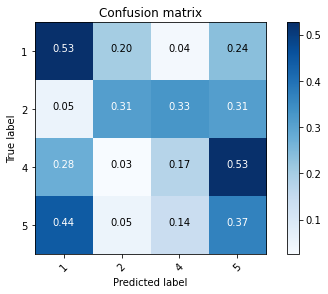

<Figure size 432x288 with 0 Axes>

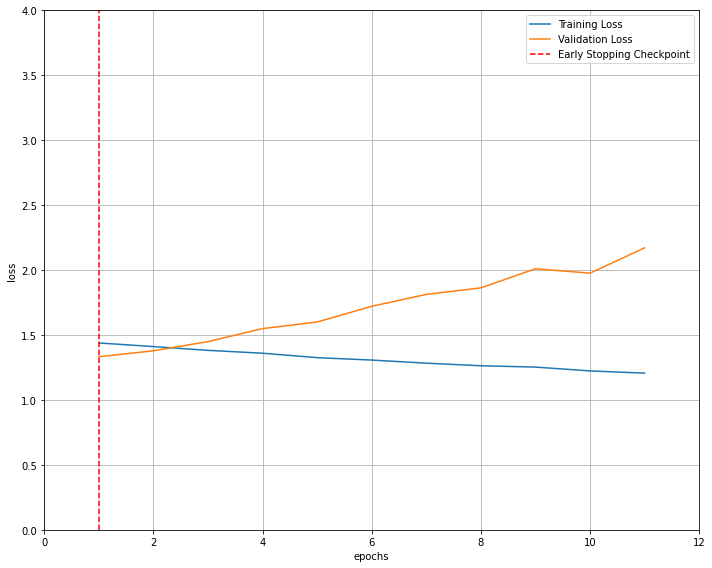

Finished analysis on User 10_interest
Starting size: (221, 120, 8)
End size: (1105, 120, 8)
Early stopping
Fold  1! Time elapsed: 4.41390061378479 seconds
Starting size: (241, 120, 8)
End size: (1205, 120, 8)
Early stopping
Fold  2! Time elapsed: 2.0516746044158936 seconds
Starting size: (232, 120, 8)
End size: (1160, 120, 8)
Early stopping
Fold  3! Time elapsed: 1.6483676433563232 seconds
Starting size: (230, 120, 8)
End size: (1150, 120, 8)
Early stopping
Fold  4! Time elapsed: 1.2913212776184082 seconds
Starting size: (228, 120, 8)
End size: (1140, 120, 8)
Early stopping
Fold  5! Time elapsed: 6.198469161987305 seconds
Normalized confusion matrix


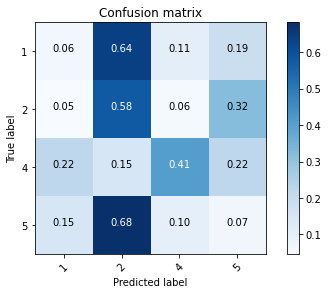

<Figure size 432x288 with 0 Axes>

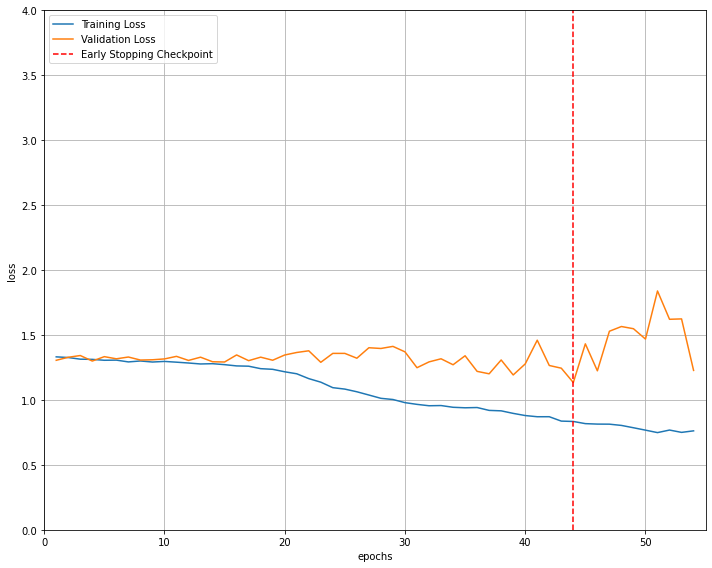

Finished analysis on User 10_effort
Finished analysis on User 10
Working on user 11
Starting size: (526, 120, 8)
End size: (2630, 120, 8)
Early stopping
Fold  1! Time elapsed: 4.990003824234009 seconds
Starting size: (564, 120, 8)
End size: (2820, 120, 8)
Early stopping
Fold  2! Time elapsed: 3.054997444152832 seconds
Starting size: (569, 120, 8)
End size: (2845, 120, 8)
Early stopping
Fold  3! Time elapsed: 5.574064493179321 seconds
Starting size: (511, 120, 8)
End size: (2555, 120, 8)
Early stopping
Fold  4! Time elapsed: 7.7318809032440186 seconds
Starting size: (506, 120, 8)
End size: (2530, 120, 8)
Early stopping
Fold  5! Time elapsed: 2.7874155044555664 seconds
Normalized confusion matrix


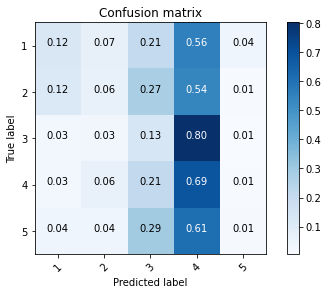

<Figure size 432x288 with 0 Axes>

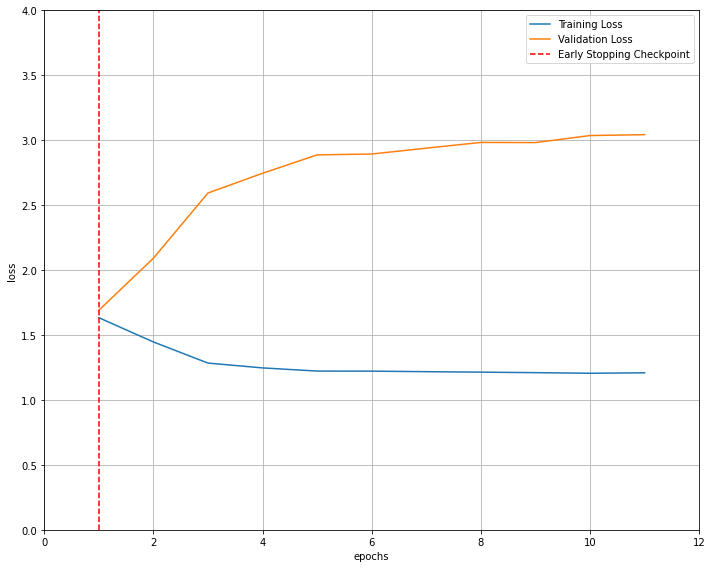

Finished analysis on User 11_attention
Starting size: (526, 120, 8)
End size: (2630, 120, 8)
Early stopping
Fold  1! Time elapsed: 4.404359817504883 seconds
Starting size: (564, 120, 8)
End size: (2820, 120, 8)
Early stopping
Fold  2! Time elapsed: 3.053690195083618 seconds
Starting size: (569, 120, 8)
End size: (2845, 120, 8)
Early stopping
Fold  3! Time elapsed: 7.194040060043335 seconds
Starting size: (511, 120, 8)
End size: (2555, 120, 8)
Early stopping
Fold  4! Time elapsed: 5.420202970504761 seconds
Starting size: (506, 120, 8)
End size: (2530, 120, 8)
Early stopping
Fold  5! Time elapsed: 2.7463581562042236 seconds
Normalized confusion matrix


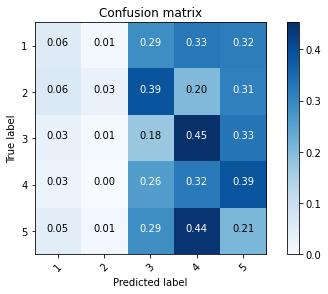

<Figure size 432x288 with 0 Axes>

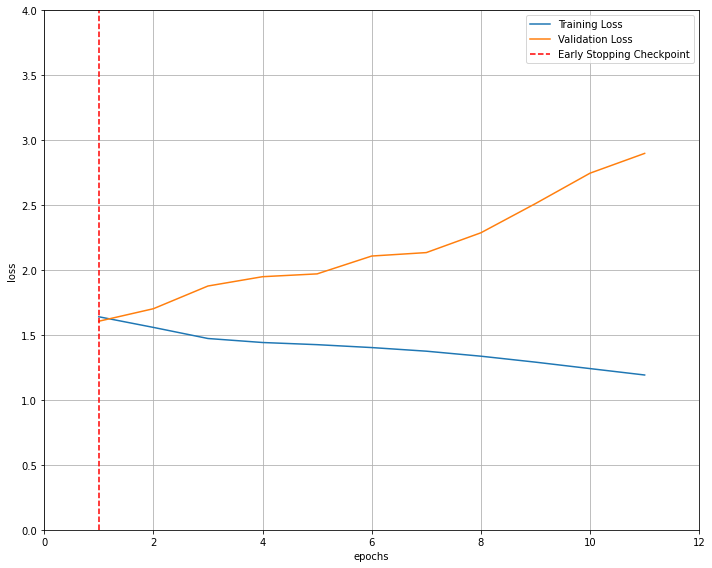

Finished analysis on User 11_interest
Starting size: (526, 120, 8)
End size: (2630, 120, 8)
Early stopping
Fold  1! Time elapsed: 2.9060592651367188 seconds
Starting size: (564, 120, 8)
End size: (2820, 120, 8)
Early stopping
Fold  2! Time elapsed: 7.089401960372925 seconds
Starting size: (569, 120, 8)
End size: (2845, 120, 8)
Early stopping
Fold  3! Time elapsed: 3.322870969772339 seconds
Starting size: (511, 120, 8)
End size: (2555, 120, 8)
Early stopping
Fold  4! Time elapsed: 3.352173328399658 seconds
Starting size: (506, 120, 8)
End size: (2530, 120, 8)
Early stopping
Fold  5! Time elapsed: 12.703327894210815 seconds
Normalized confusion matrix


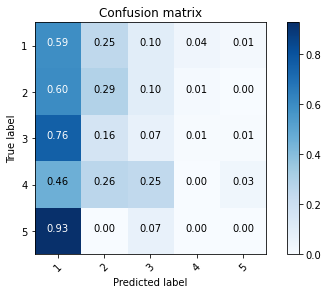

<Figure size 432x288 with 0 Axes>

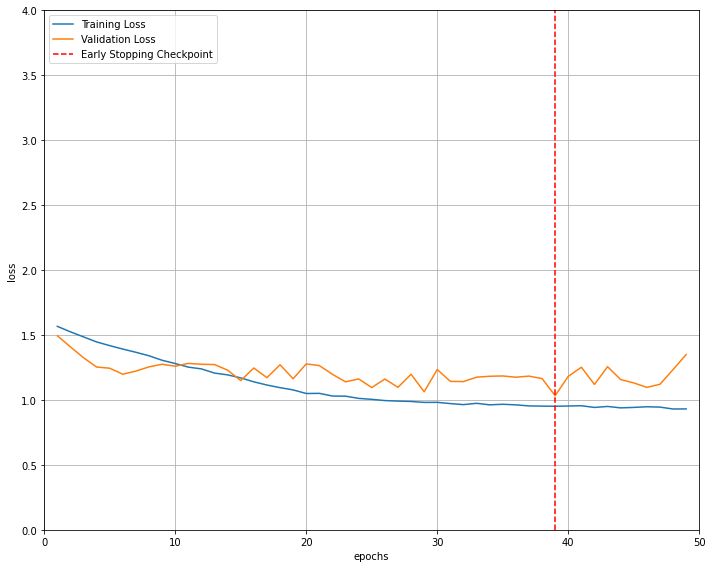

Finished analysis on User 11_effort
Finished analysis on User 11
Working on user 12
Starting size: (72, 120, 8)
End size: (360, 120, 8)
Early stopping
Fold  1! Time elapsed: 0.5036652088165283 seconds
Starting size: (67, 120, 8)
End size: (335, 120, 8)
Early stopping
Fold  2! Time elapsed: 1.4180400371551514 seconds
Starting size: (46, 120, 8)
End size: (230, 120, 8)
Early stopping
Fold  3! Time elapsed: 0.8719439506530762 seconds
Starting size: (79, 120, 8)
End size: (395, 120, 8)
Early stopping
Fold  4! Time elapsed: 1.4693412780761719 seconds
Starting size: (80, 120, 8)
End size: (400, 120, 8)
Early stopping
Fold  5! Time elapsed: 1.5683233737945557 seconds
Normalized confusion matrix


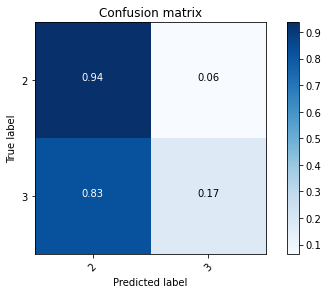

<Figure size 432x288 with 0 Axes>

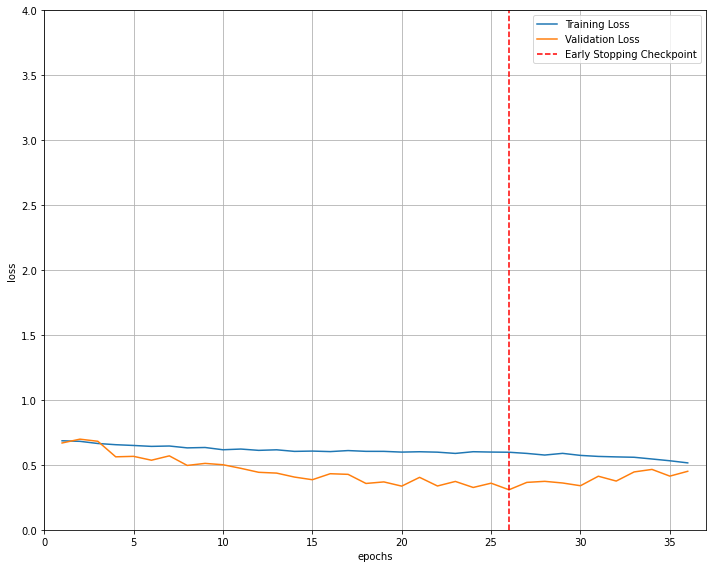

Finished analysis on User 12_attention
Starting size: (72, 120, 8)
End size: (360, 120, 8)
Early stopping
Fold  1! Time elapsed: 0.49605512619018555 seconds
Starting size: (67, 120, 8)
End size: (335, 120, 8)
Early stopping
Fold  2! Time elapsed: 0.447033166885376 seconds
Starting size: (79, 120, 8)
End size: (395, 120, 8)
Early stopping
Fold  3! Time elapsed: 2.533855438232422 seconds
Starting size: (80, 120, 8)
End size: (400, 120, 8)
Early stopping
Fold  4! Time elapsed: 0.49796032905578613 seconds
Normalized confusion matrix


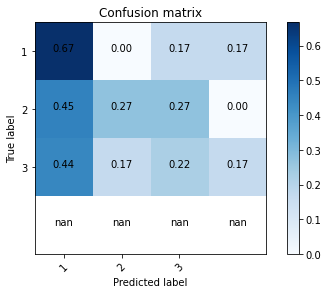

<Figure size 432x288 with 0 Axes>

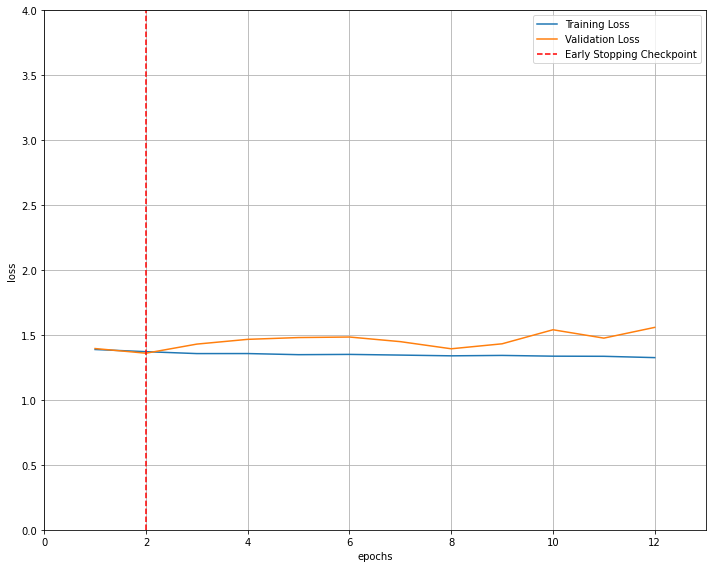

Finished analysis on User 12_interest
Starting size: (72, 120, 8)
End size: (360, 120, 8)
Early stopping
Fold  1! Time elapsed: 1.4484355449676514 seconds
Starting size: (46, 120, 8)
End size: (230, 120, 8)
Early stopping
Fold  2! Time elapsed: 0.5858497619628906 seconds
Starting size: (80, 120, 8)
End size: (400, 120, 8)
Early stopping
Fold  3! Time elapsed: 1.1661651134490967 seconds
Normalized confusion matrix


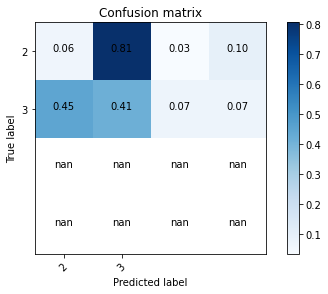

<Figure size 432x288 with 0 Axes>

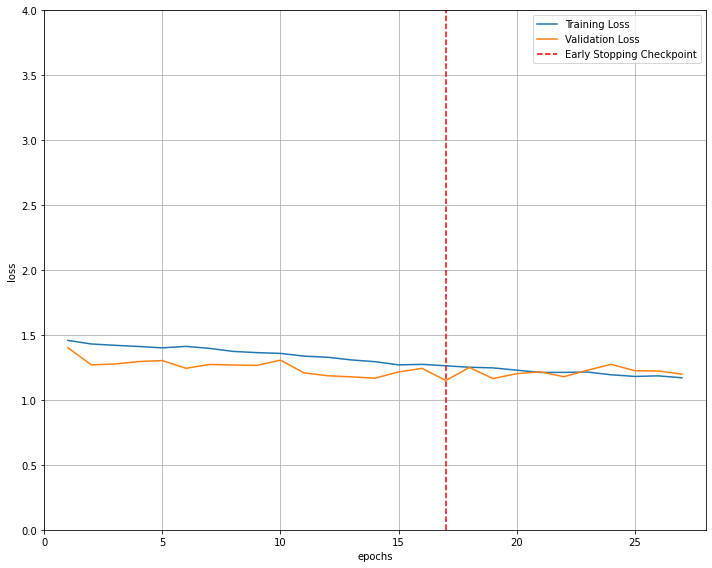

Finished analysis on User 12_effort
Finished analysis on User 12
Working on user 17
Starting size: (697, 120, 8)
End size: (3485, 120, 8)
Early stopping
Fold  1! Time elapsed: 4.787712335586548 seconds
Starting size: (677, 120, 8)
End size: (3385, 120, 8)
Early stopping
Fold  2! Time elapsed: 8.758835792541504 seconds
Starting size: (645, 120, 8)
End size: (3225, 120, 8)
Early stopping
Fold  3! Time elapsed: 4.156301259994507 seconds
Starting size: (677, 120, 8)
End size: (3385, 120, 8)
Early stopping
Fold  4! Time elapsed: 5.678670167922974 seconds
Starting size: (736, 120, 8)
End size: (3680, 120, 8)
Early stopping
Fold  5! Time elapsed: 6.141666412353516 seconds
Normalized confusion matrix


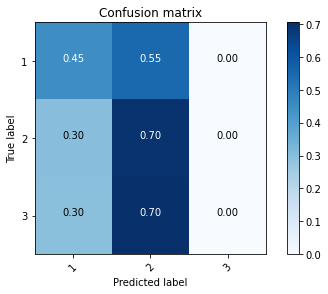

<Figure size 432x288 with 0 Axes>

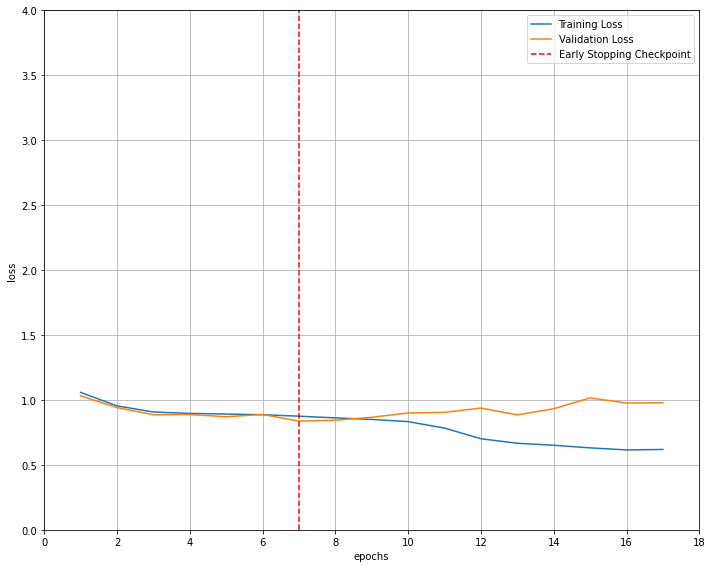

Finished analysis on User 17_attention
Starting size: (697, 120, 8)
End size: (3485, 120, 8)
Early stopping
Fold  1! Time elapsed: 12.717483520507812 seconds
Starting size: (677, 120, 8)
End size: (3385, 120, 8)
Early stopping
Fold  2! Time elapsed: 12.315274000167847 seconds
Starting size: (645, 120, 8)
End size: (3225, 120, 8)
Early stopping
Fold  3! Time elapsed: 7.72027063369751 seconds
Starting size: (677, 120, 8)
End size: (3385, 120, 8)
Early stopping
Fold  4! Time elapsed: 5.314222097396851 seconds
Starting size: (736, 120, 8)
End size: (3680, 120, 8)
Early stopping
Fold  5! Time elapsed: 6.153945207595825 seconds
Normalized confusion matrix


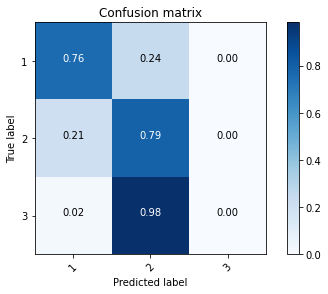

<Figure size 432x288 with 0 Axes>

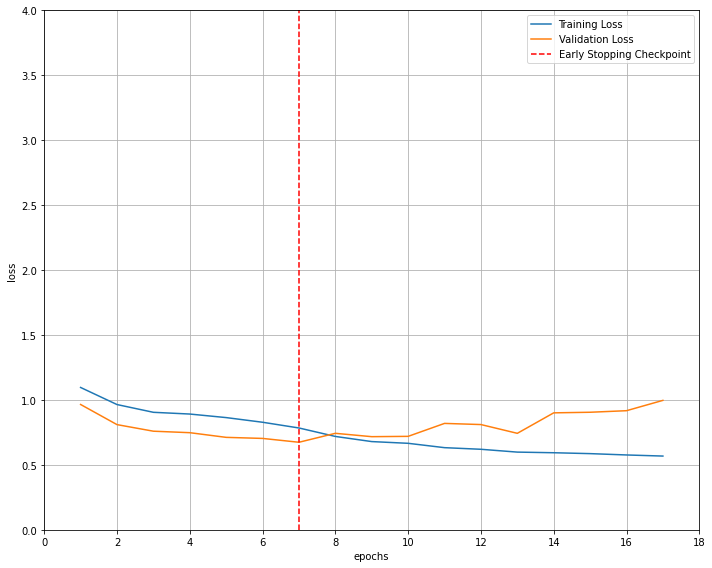

Finished analysis on User 17_interest
Starting size: (697, 120, 8)
End size: (3485, 120, 8)
Early stopping
Fold  1! Time elapsed: 4.79665470123291 seconds
Starting size: (677, 120, 8)
End size: (3385, 120, 8)
Early stopping
Fold  2! Time elapsed: 4.990457057952881 seconds
Starting size: (645, 120, 8)
End size: (3225, 120, 8)
Early stopping
Fold  3! Time elapsed: 4.472167730331421 seconds
Starting size: (677, 120, 8)
End size: (3385, 120, 8)
Early stopping
Fold  4! Time elapsed: 4.312137603759766 seconds
Starting size: (736, 120, 8)
End size: (3680, 120, 8)
Early stopping
Fold  5! Time elapsed: 4.323887825012207 seconds
Normalized confusion matrix


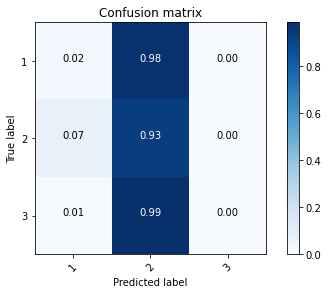

<Figure size 432x288 with 0 Axes>

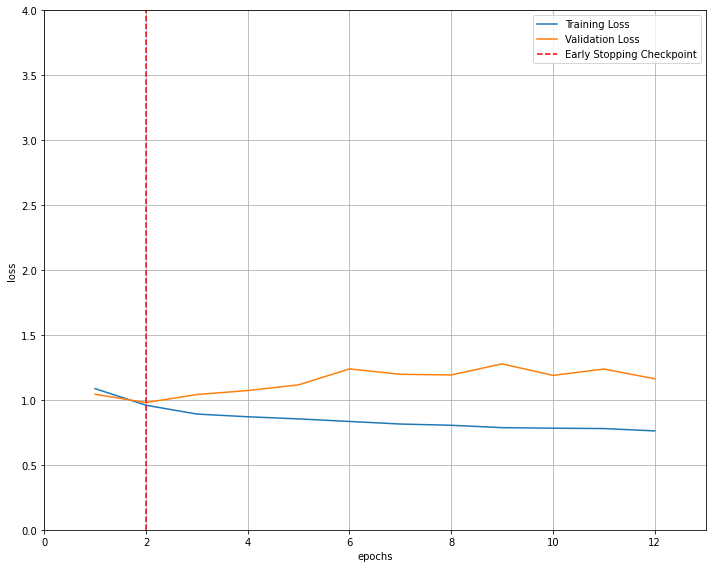

Finished analysis on User 17_effort
Finished analysis on User 17
Working on user 18
Starting size: (1070, 120, 8)
End size: (5350, 120, 8)
Early stopping
Fold  1! Time elapsed: 6.885767936706543 seconds
Starting size: (1203, 120, 8)
End size: (6015, 120, 8)
Early stopping
Fold  2! Time elapsed: 6.429574966430664 seconds
Starting size: (1166, 120, 8)
End size: (5830, 120, 8)
Early stopping
Fold  3! Time elapsed: 6.239917993545532 seconds
Starting size: (1112, 120, 8)
End size: (5560, 120, 8)
Early stopping
Fold  4! Time elapsed: 6.005741834640503 seconds
Starting size: (1185, 120, 8)
End size: (5925, 120, 8)
Early stopping
Fold  5! Time elapsed: 7.504697799682617 seconds
Normalized confusion matrix


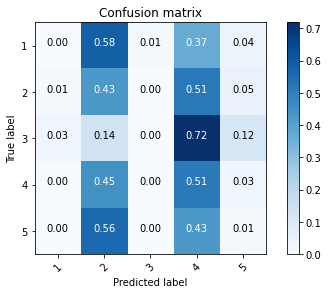

<Figure size 432x288 with 0 Axes>

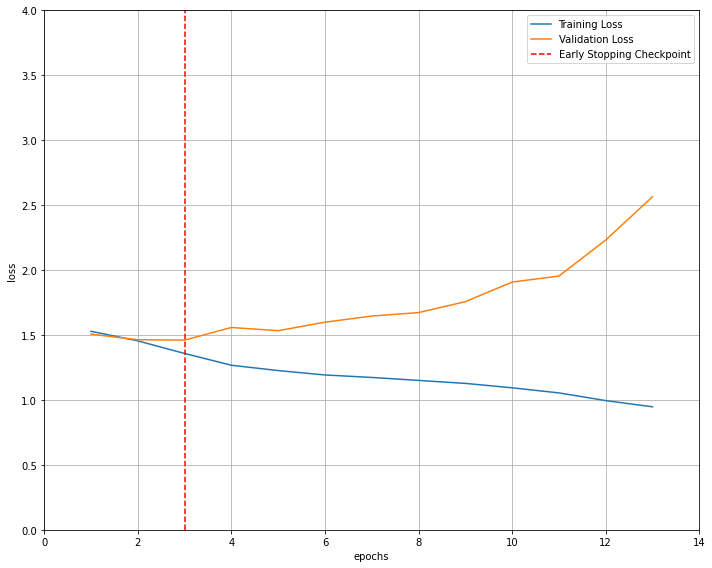

Finished analysis on User 18_attention
Starting size: (1070, 120, 8)
End size: (5350, 120, 8)
Early stopping
Fold  1! Time elapsed: 6.815256357192993 seconds
Starting size: (1203, 120, 8)
End size: (6015, 120, 8)
Early stopping
Fold  2! Time elapsed: 7.0402867794036865 seconds
Starting size: (1112, 120, 8)
End size: (5560, 120, 8)
Early stopping
Fold  3! Time elapsed: 16.96153950691223 seconds
Starting size: (1185, 120, 8)
End size: (5925, 120, 8)
Early stopping
Fold  4! Time elapsed: 6.91918420791626 seconds
Normalized confusion matrix


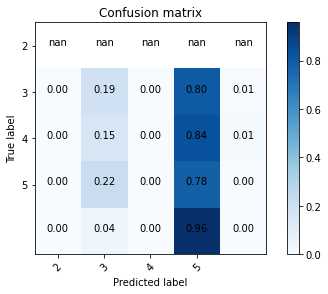

<Figure size 432x288 with 0 Axes>

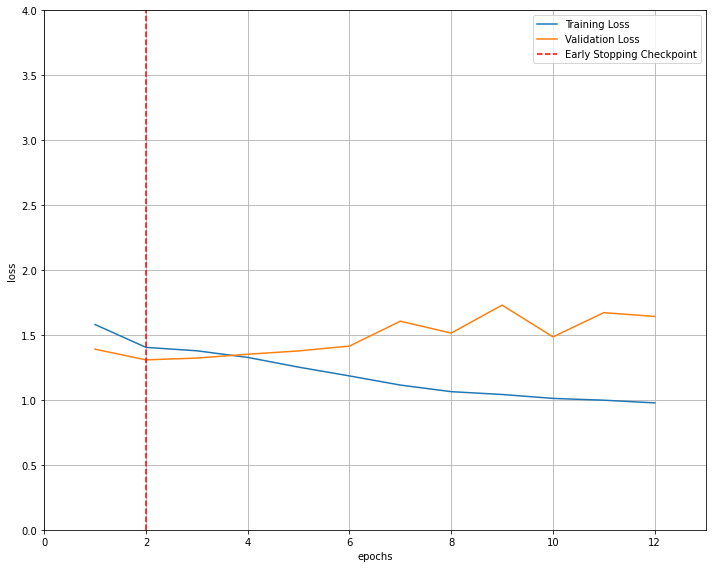

Finished analysis on User 18_interest
Starting size: (1070, 120, 8)
End size: (5350, 120, 8)
Early stopping
Fold  1! Time elapsed: 5.828696012496948 seconds
Starting size: (1203, 120, 8)
End size: (6015, 120, 8)
Early stopping
Fold  2! Time elapsed: 11.12370491027832 seconds
Starting size: (1166, 120, 8)
End size: (5830, 120, 8)
Early stopping
Fold  3! Time elapsed: 6.987367153167725 seconds
Starting size: (1112, 120, 8)
End size: (5560, 120, 8)
Early stopping
Fold  4! Time elapsed: 6.011768817901611 seconds
Starting size: (1185, 120, 8)
End size: (5925, 120, 8)
Early stopping
Fold  5! Time elapsed: 6.334113359451294 seconds
Normalized confusion matrix


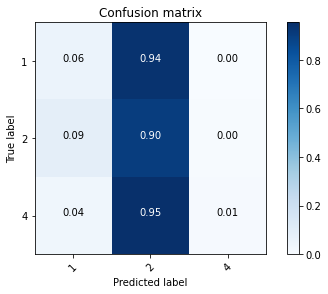

<Figure size 432x288 with 0 Axes>

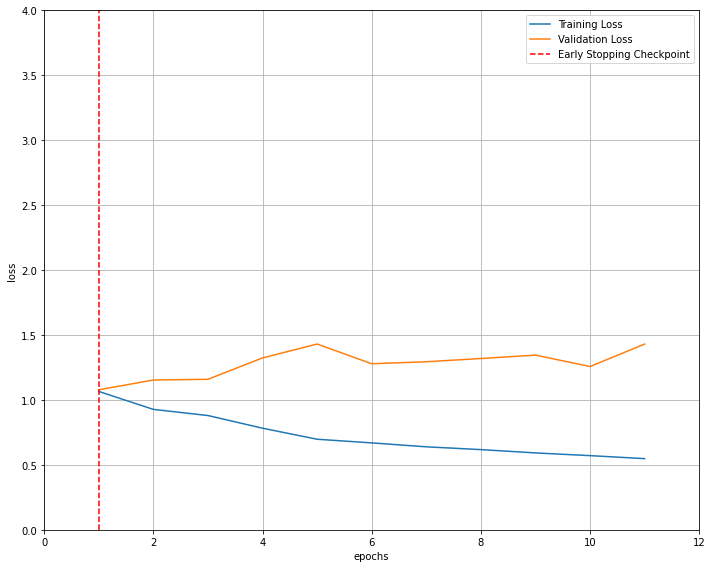

Finished analysis on User 18_effort
Finished analysis on User 18
Working on user 19
Starting size: (301, 120, 8)
End size: (1505, 120, 8)
Early stopping
Fold  1! Time elapsed: 2.55438232421875 seconds
Starting size: (298, 120, 8)
End size: (1490, 120, 8)
Early stopping
Fold  2! Time elapsed: 1.614302158355713 seconds
Starting size: (326, 120, 8)
End size: (1630, 120, 8)
Early stopping
Fold  3! Time elapsed: 4.9002697467803955 seconds
Starting size: (322, 120, 8)
End size: (1610, 120, 8)
Early stopping
Fold  4! Time elapsed: 1.793137788772583 seconds
Normalized confusion matrix


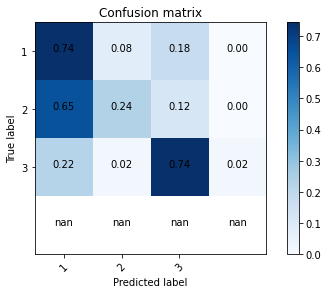

<Figure size 432x288 with 0 Axes>

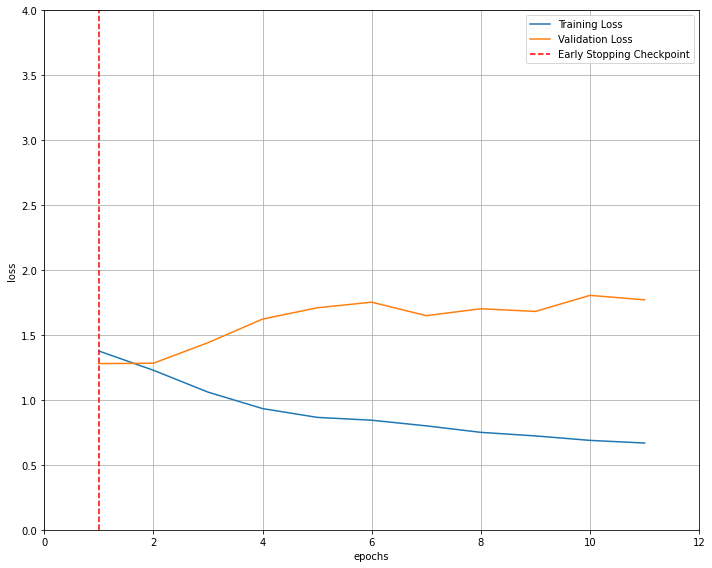

Finished analysis on User 19_attention
Starting size: (301, 120, 8)
End size: (1505, 120, 8)
Early stopping
Fold  1! Time elapsed: 8.481348276138306 seconds
Starting size: (298, 120, 8)
End size: (1490, 120, 8)
Early stopping
Fold  2! Time elapsed: 1.7675249576568604 seconds
Starting size: (326, 120, 8)
End size: (1630, 120, 8)
Early stopping
Fold  3! Time elapsed: 12.573845863342285 seconds
Starting size: (322, 120, 8)
End size: (1610, 120, 8)
Early stopping
Fold  4! Time elapsed: 1.7831637859344482 seconds
Normalized confusion matrix


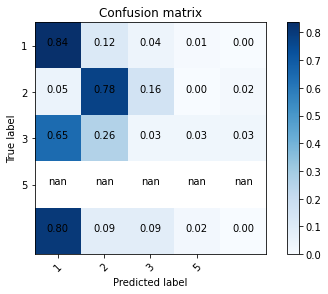

<Figure size 432x288 with 0 Axes>

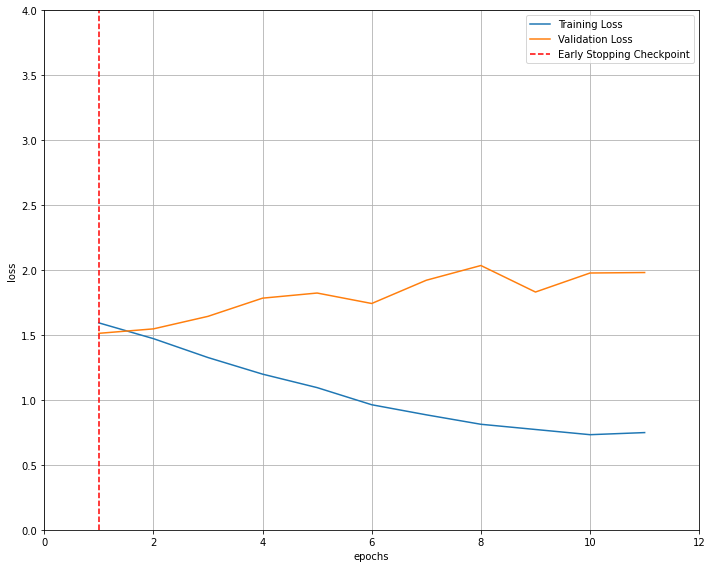

Finished analysis on User 19_interest
Starting size: (281, 120, 8)
End size: (1405, 120, 8)
Early stopping
Fold  1! Time elapsed: 3.3248722553253174 seconds
Starting size: (301, 120, 8)
End size: (1505, 120, 8)
Early stopping
Fold  2! Time elapsed: 5.864544868469238 seconds
Starting size: (298, 120, 8)
End size: (1490, 120, 8)
Early stopping
Fold  3! Time elapsed: 1.6264455318450928 seconds
Starting size: (326, 120, 8)
End size: (1630, 120, 8)
Early stopping
Fold  4! Time elapsed: 4.87819504737854 seconds
Starting size: (322, 120, 8)
End size: (1610, 120, 8)
Early stopping
Fold  5! Time elapsed: 1.7696292400360107 seconds
Normalized confusion matrix


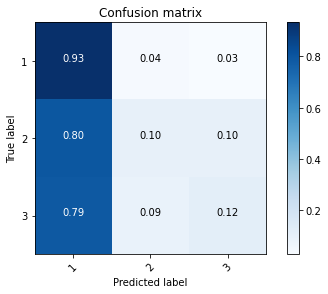

<Figure size 432x288 with 0 Axes>

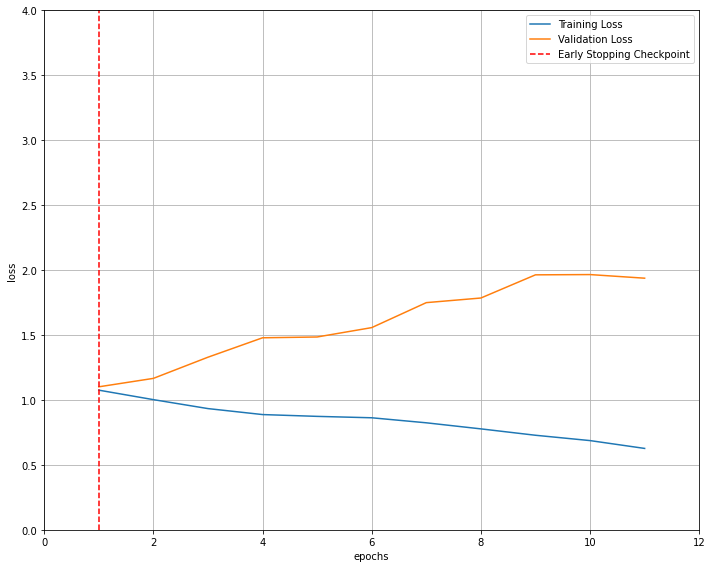

Finished analysis on User 19_effort
Finished analysis on User 19
Working on user 20
Starting size: (788, 120, 8)
End size: (3940, 120, 8)
Early stopping
Fold  1! Time elapsed: 4.696244239807129 seconds
Starting size: (975, 120, 8)
End size: (4875, 120, 8)
Early stopping
Fold  2! Time elapsed: 5.232327222824097 seconds
Starting size: (949, 120, 8)
End size: (4745, 120, 8)
Early stopping
Fold  3! Time elapsed: 6.4717676639556885 seconds
Starting size: (875, 120, 8)
End size: (4375, 120, 8)
Early stopping
Fold  4! Time elapsed: 9.081478834152222 seconds
Starting size: (1021, 120, 8)
End size: (5105, 120, 8)
Early stopping
Fold  5! Time elapsed: 5.978892087936401 seconds
Normalized confusion matrix


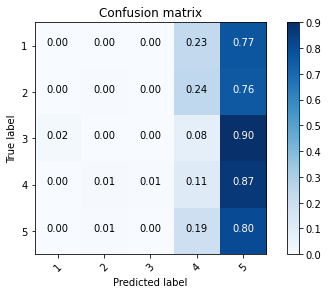

<Figure size 432x288 with 0 Axes>

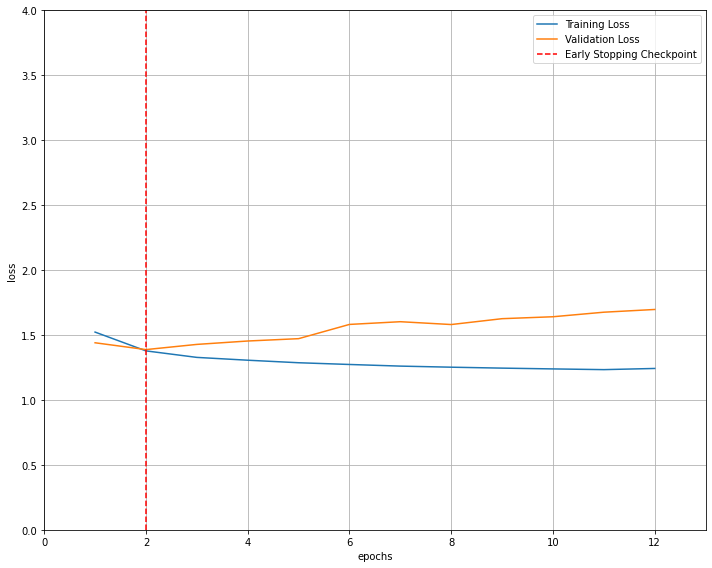

Finished analysis on User 20_attention
Starting size: (788, 120, 8)
End size: (3940, 120, 8)
Early stopping
Fold  1! Time elapsed: 5.070531845092773 seconds
Starting size: (975, 120, 8)
End size: (4875, 120, 8)
Early stopping
Fold  2! Time elapsed: 5.212009906768799 seconds
Starting size: (949, 120, 8)
End size: (4745, 120, 8)
Early stopping
Fold  3! Time elapsed: 5.568504571914673 seconds
Starting size: (875, 120, 8)
End size: (4375, 120, 8)
Early stopping
Fold  4! Time elapsed: 6.033491611480713 seconds
Starting size: (1021, 120, 8)
End size: (5105, 120, 8)
Early stopping
Fold  5! Time elapsed: 6.992942571640015 seconds
Normalized confusion matrix


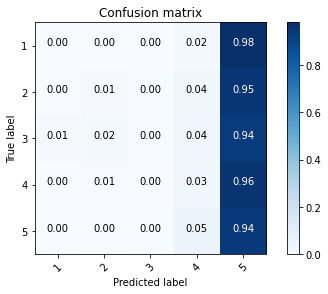

<Figure size 432x288 with 0 Axes>

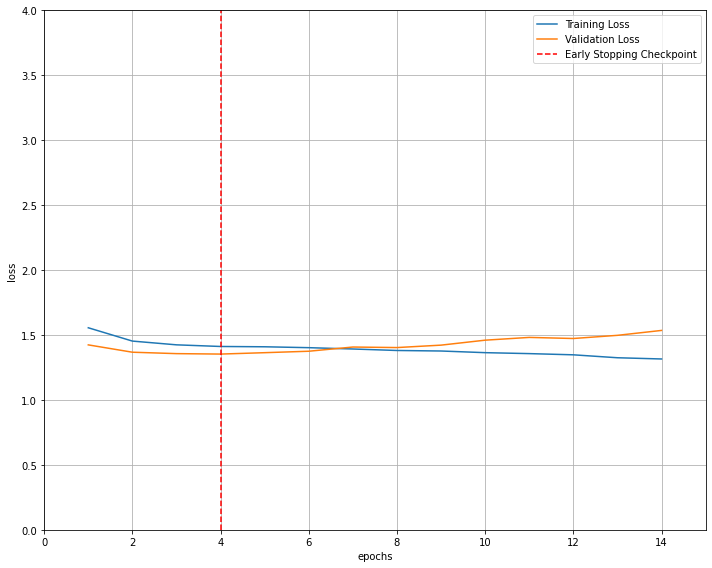

Finished analysis on User 20_interest
Starting size: (788, 120, 8)
End size: (3940, 120, 8)
Early stopping
Fold  1! Time elapsed: 6.997354984283447 seconds
Starting size: (975, 120, 8)
End size: (4875, 120, 8)
Early stopping
Fold  2! Time elapsed: 5.3225929737091064 seconds
Starting size: (949, 120, 8)
End size: (4745, 120, 8)
Early stopping
Fold  3! Time elapsed: 8.322443723678589 seconds
Starting size: (875, 120, 8)
End size: (4375, 120, 8)
Early stopping
Fold  4! Time elapsed: 4.735209226608276 seconds
Starting size: (1021, 120, 8)
End size: (5105, 120, 8)
Early stopping
Fold  5! Time elapsed: 5.4843926429748535 seconds
Normalized confusion matrix


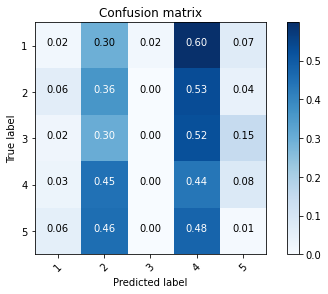

<Figure size 432x288 with 0 Axes>

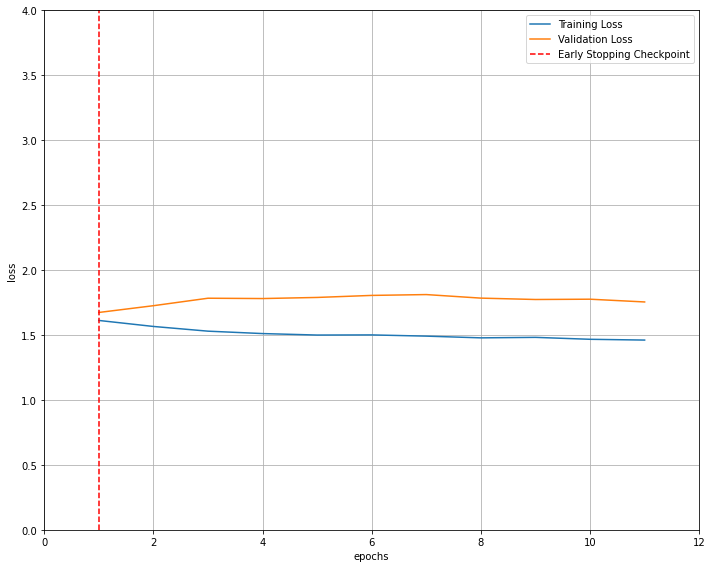

Finished analysis on User 20_effort
Finished analysis on User 20
Working on user 22
Starting size: (874, 120, 8)
End size: (4370, 120, 8)
Early stopping
Fold  1! Time elapsed: 4.756054639816284 seconds
Starting size: (927, 120, 8)
End size: (4635, 120, 8)
Early stopping
Fold  2! Time elapsed: 16.04958152770996 seconds
Starting size: (888, 120, 8)
End size: (4440, 120, 8)
Early stopping
Fold  3! Time elapsed: 5.670938730239868 seconds
Starting size: (872, 120, 8)
End size: (4360, 120, 8)
Early stopping
Fold  4! Time elapsed: 12.066264629364014 seconds
Starting size: (911, 120, 8)
End size: (4555, 120, 8)
Early stopping
Fold  5! Time elapsed: 5.9717161655426025 seconds
Normalized confusion matrix


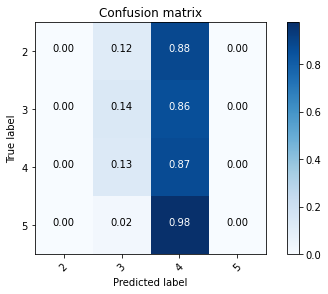

<Figure size 432x288 with 0 Axes>

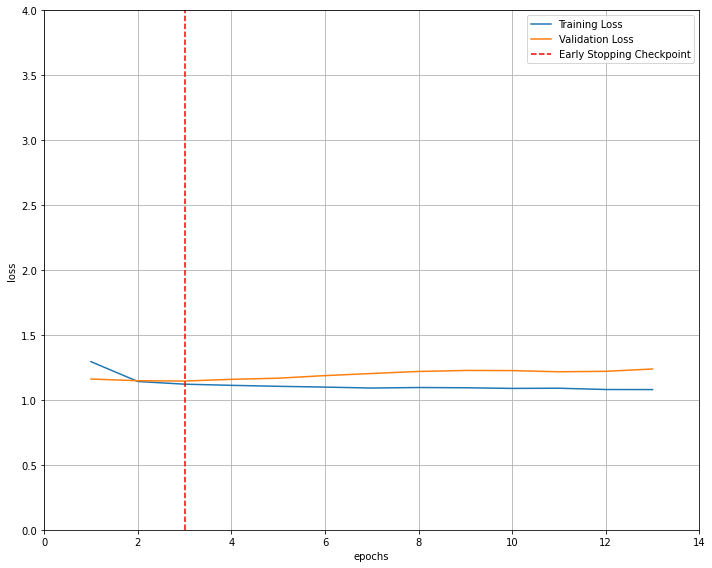

Finished analysis on User 22_attention
Starting size: (874, 120, 8)
End size: (4370, 120, 8)
Early stopping
Fold  1! Time elapsed: 5.593945503234863 seconds
Starting size: (927, 120, 8)
End size: (4635, 120, 8)
Early stopping
Fold  2! Time elapsed: 14.08405590057373 seconds
Starting size: (888, 120, 8)
End size: (4440, 120, 8)
Early stopping
Fold  3! Time elapsed: 10.674477338790894 seconds
Starting size: (872, 120, 8)
End size: (4360, 120, 8)
Early stopping
Fold  4! Time elapsed: 6.883185148239136 seconds
Normalized confusion matrix


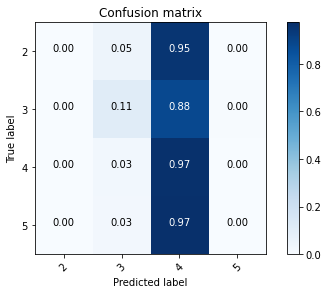

<Figure size 432x288 with 0 Axes>

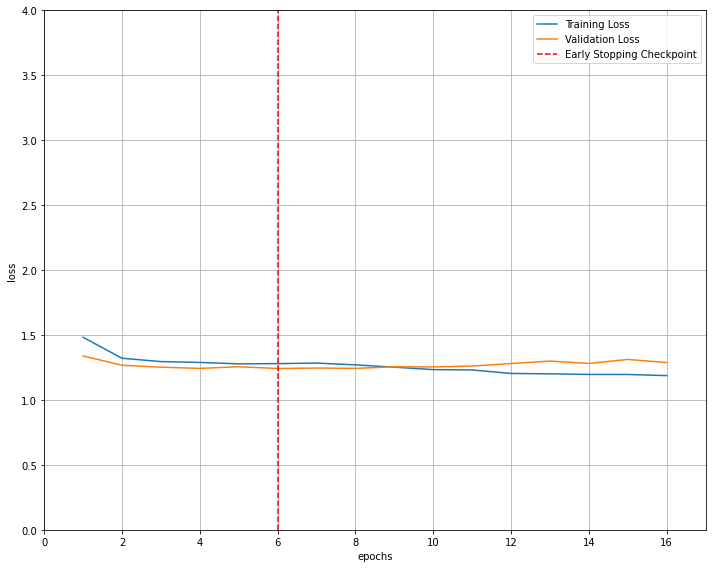

Finished analysis on User 22_interest
Starting size: (927, 120, 8)
End size: (4635, 120, 8)
Early stopping
Fold  1! Time elapsed: 7.748183250427246 seconds
Starting size: (888, 120, 8)
End size: (4440, 120, 8)
Early stopping
Fold  2! Time elapsed: 10.074212074279785 seconds
Starting size: (872, 120, 8)
End size: (4360, 120, 8)
Early stopping
Fold  3! Time elapsed: 9.582072973251343 seconds
Starting size: (911, 120, 8)
End size: (4555, 120, 8)
Early stopping
Fold  4! Time elapsed: 7.591939926147461 seconds
Normalized confusion matrix


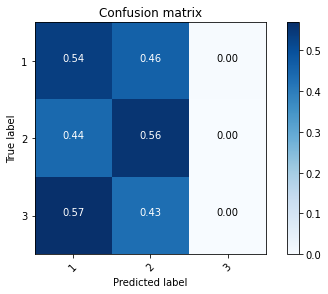

<Figure size 432x288 with 0 Axes>

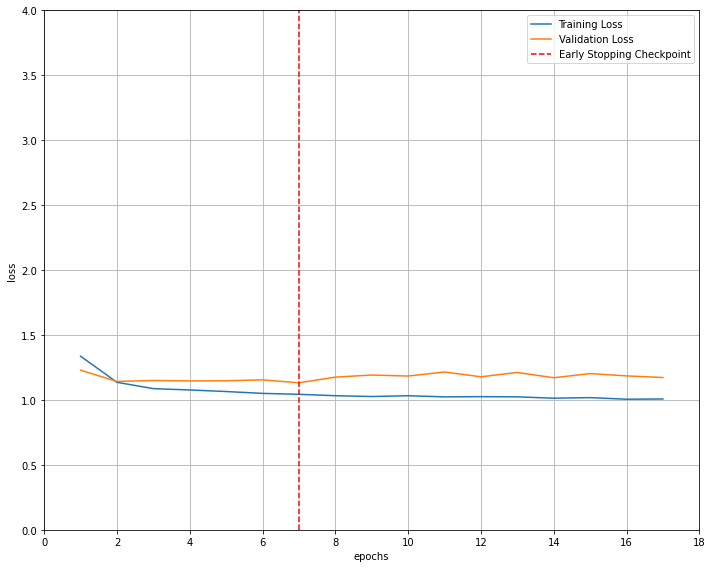

Finished analysis on User 22_effort
Finished analysis on User 22
Working on user 23
Starting size: (1418, 120, 8)
End size: (7090, 120, 8)
Early stopping
Fold  1! Time elapsed: 9.075627088546753 seconds
Starting size: (1553, 120, 8)
End size: (7765, 120, 8)
Early stopping
Fold  2! Time elapsed: 8.329019546508789 seconds
Starting size: (1593, 120, 8)
End size: (7965, 120, 8)
Early stopping
Fold  3! Time elapsed: 10.092199087142944 seconds
Starting size: (1523, 120, 8)
End size: (7615, 120, 8)
Early stopping
Fold  4! Time elapsed: 9.690770864486694 seconds
Starting size: (1633, 120, 8)
End size: (8165, 120, 8)
Early stopping
Fold  5! Time elapsed: 11.9273521900177 seconds
Normalized confusion matrix


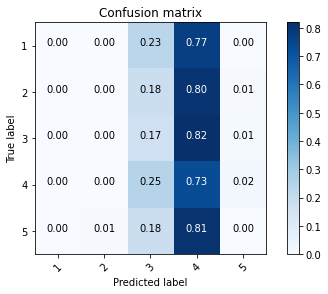

<Figure size 432x288 with 0 Axes>

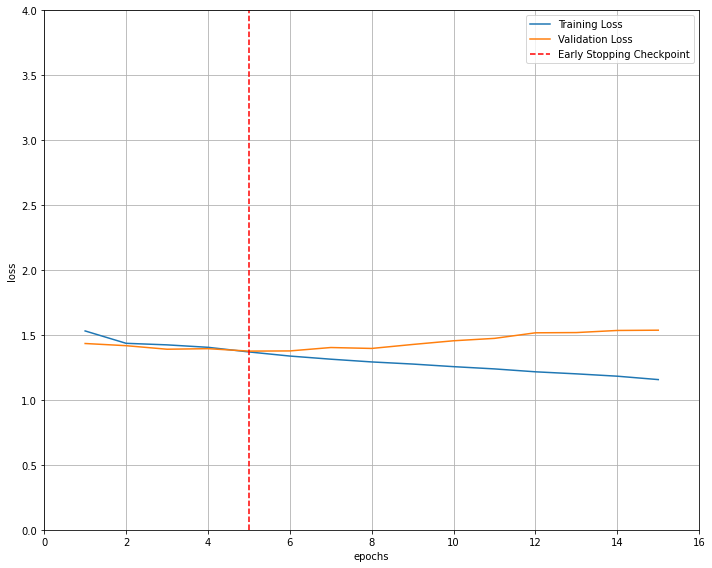

Finished analysis on User 23_attention
Starting size: (1418, 120, 8)
End size: (7090, 120, 8)
Early stopping
Fold  1! Time elapsed: 8.34654974937439 seconds
Starting size: (1553, 120, 8)
End size: (7765, 120, 8)
Early stopping
Fold  2! Time elapsed: 8.30720853805542 seconds
Starting size: (1593, 120, 8)
End size: (7965, 120, 8)
Early stopping
Fold  3! Time elapsed: 11.624503135681152 seconds
Starting size: (1523, 120, 8)
End size: (7615, 120, 8)
Early stopping
Fold  4! Time elapsed: 8.19481897354126 seconds
Starting size: (1633, 120, 8)
End size: (8165, 120, 8)
Early stopping
Fold  5! Time elapsed: 8.730540990829468 seconds
Normalized confusion matrix


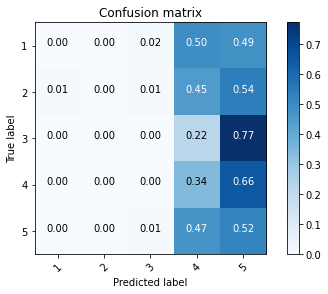

<Figure size 432x288 with 0 Axes>

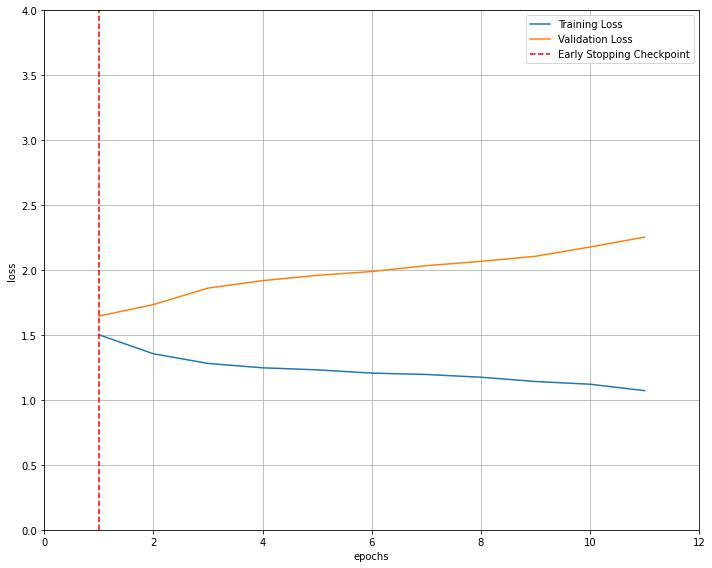

Finished analysis on User 23_interest
Starting size: (1418, 120, 8)
End size: (7090, 120, 8)
Early stopping
Fold  1! Time elapsed: 15.811079025268555 seconds
Starting size: (1553, 120, 8)
End size: (7765, 120, 8)
Early stopping
Fold  2! Time elapsed: 8.333372831344604 seconds
Starting size: (1593, 120, 8)
End size: (7965, 120, 8)
Early stopping
Fold  3! Time elapsed: 8.498318672180176 seconds
Starting size: (1633, 120, 8)
End size: (8165, 120, 8)
Early stopping
Fold  4! Time elapsed: 33.35600519180298 seconds
Normalized confusion matrix


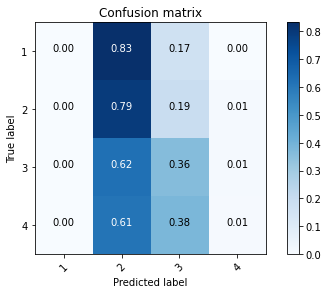

<Figure size 432x288 with 0 Axes>

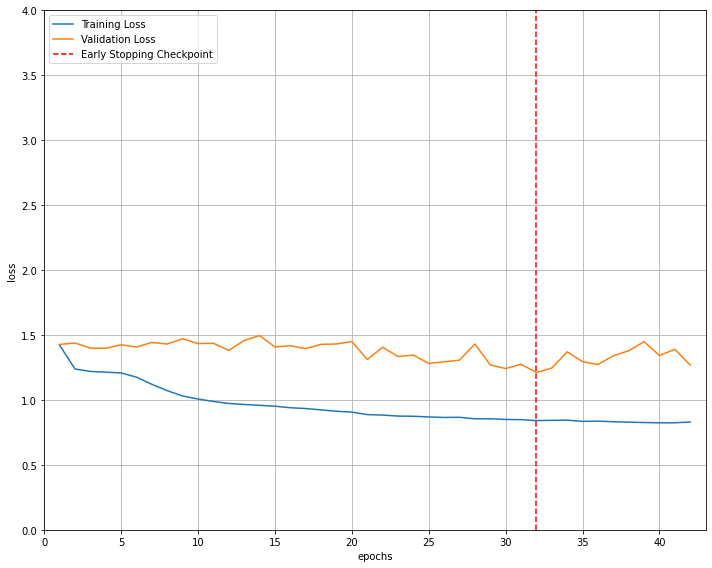

Finished analysis on User 23_effort
Finished analysis on User 23
Working on user 24
Starting size: (717, 120, 8)
End size: (3585, 120, 8)
Early stopping
Fold  1! Time elapsed: 6.7569239139556885 seconds
Starting size: (667, 120, 8)
End size: (3335, 120, 8)
Early stopping
Fold  2! Time elapsed: 8.583620309829712 seconds
Starting size: (720, 120, 8)
End size: (3600, 120, 8)
Early stopping
Fold  3! Time elapsed: 21.6043438911438 seconds
Starting size: (761, 120, 8)
End size: (3805, 120, 8)
Early stopping
Fold  4! Time elapsed: 10.505557298660278 seconds
Normalized confusion matrix


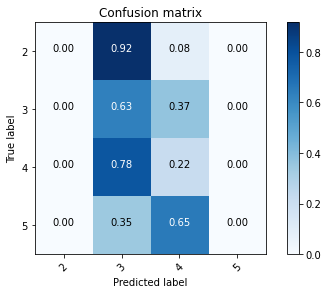

<Figure size 432x288 with 0 Axes>

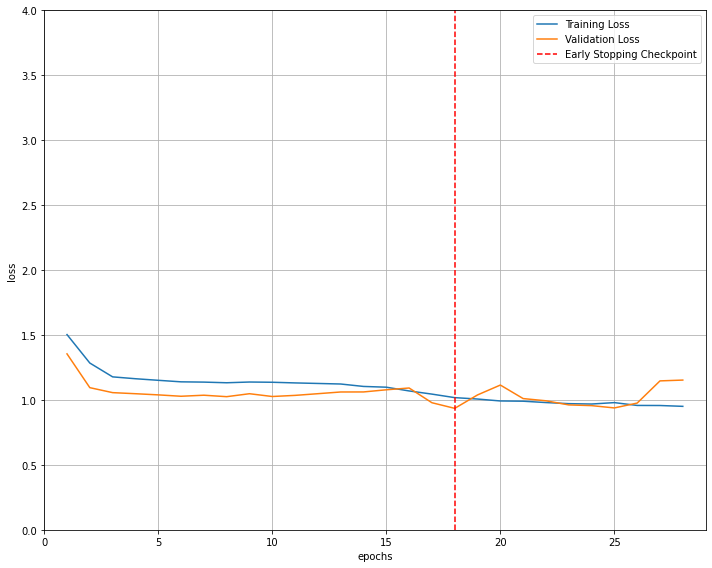

Finished analysis on User 24_attention
Starting size: (717, 120, 8)
End size: (3585, 120, 8)
Early stopping
Fold  1! Time elapsed: 4.633435010910034 seconds
Starting size: (667, 120, 8)
End size: (3335, 120, 8)
Early stopping
Fold  2! Time elapsed: 5.440196990966797 seconds
Starting size: (720, 120, 8)
End size: (3600, 120, 8)
Early stopping
Fold  3! Time elapsed: 6.0043864250183105 seconds
Starting size: (761, 120, 8)
End size: (3805, 120, 8)
Early stopping
Fold  4! Time elapsed: 14.589340925216675 seconds
Normalized confusion matrix


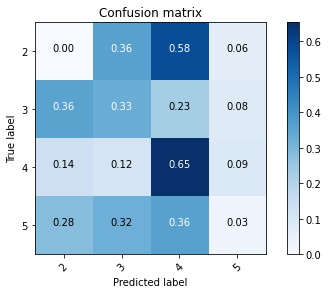

<Figure size 432x288 with 0 Axes>

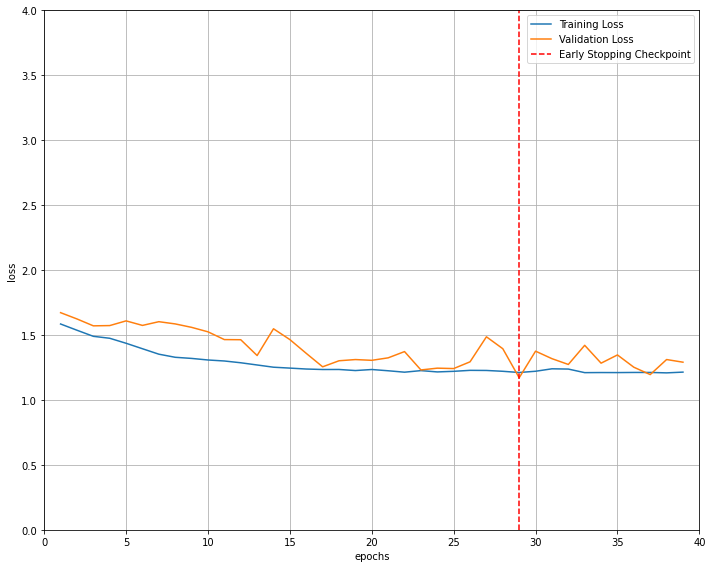

Finished analysis on User 24_interest
Starting size: (717, 120, 8)
End size: (3585, 120, 8)
Early stopping
Fold  1! Time elapsed: 3.874364137649536 seconds
Starting size: (667, 120, 8)
End size: (3335, 120, 8)
Early stopping
Fold  2! Time elapsed: 5.601419687271118 seconds
Starting size: (720, 120, 8)
End size: (3600, 120, 8)
Early stopping
Fold  3! Time elapsed: 14.43850827217102 seconds
Starting size: (761, 120, 8)
End size: (3805, 120, 8)
Early stopping
Fold  4! Time elapsed: 6.006684064865112 seconds
Normalized confusion matrix


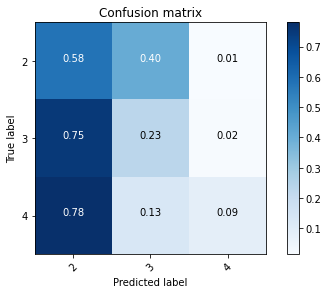

<Figure size 432x288 with 0 Axes>

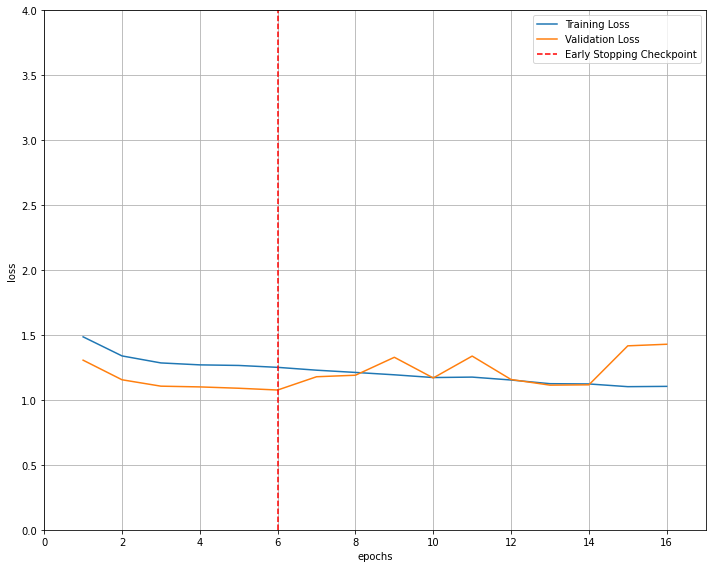

Finished analysis on User 24_effort
Finished analysis on User 24
Working on user 25
Starting size: (1653, 120, 8)
End size: (8265, 120, 8)
Early stopping
Fold  1! Time elapsed: 11.331034898757935 seconds
Starting size: (1702, 120, 8)
End size: (8510, 120, 8)
Early stopping
Fold  2! Time elapsed: 9.99706506729126 seconds
Starting size: (1706, 120, 8)
End size: (8530, 120, 8)
Early stopping
Fold  3! Time elapsed: 9.126463890075684 seconds
Starting size: (1824, 120, 8)
End size: (9120, 120, 8)
Early stopping
Fold  4! Time elapsed: 9.76042127609253 seconds
Starting size: (1695, 120, 8)
End size: (8475, 120, 8)
Early stopping
Fold  5! Time elapsed: 41.568811893463135 seconds
Normalized confusion matrix


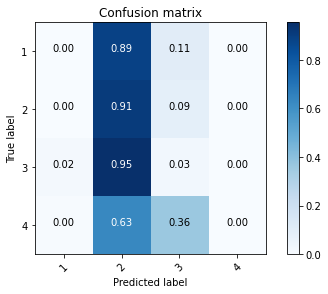

<Figure size 432x288 with 0 Axes>

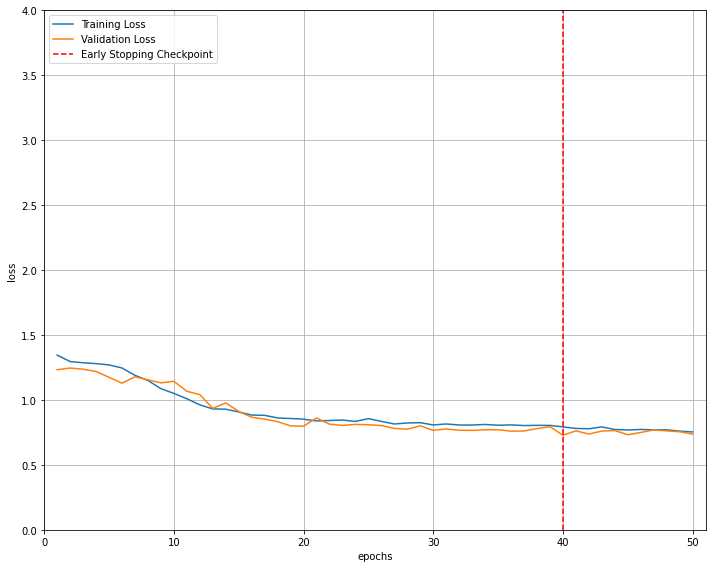

Finished analysis on User 25_attention
Starting size: (1653, 120, 8)
End size: (8265, 120, 8)
Early stopping
Fold  1! Time elapsed: 8.871088743209839 seconds
Starting size: (1702, 120, 8)
End size: (8510, 120, 8)
Early stopping
Fold  2! Time elapsed: 10.008968591690063 seconds
Starting size: (1706, 120, 8)
End size: (8530, 120, 8)
Early stopping
Fold  3! Time elapsed: 24.161586046218872 seconds
Starting size: (1824, 120, 8)
End size: (9120, 120, 8)
Early stopping
Fold  4! Time elapsed: 9.728691816329956 seconds
Starting size: (1695, 120, 8)
End size: (8475, 120, 8)
Early stopping
Fold  5! Time elapsed: 9.082853317260742 seconds
Normalized confusion matrix


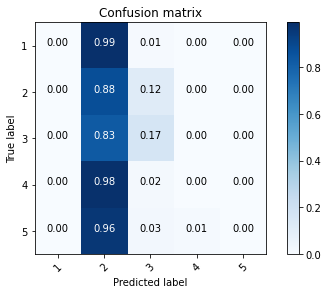

<Figure size 432x288 with 0 Axes>

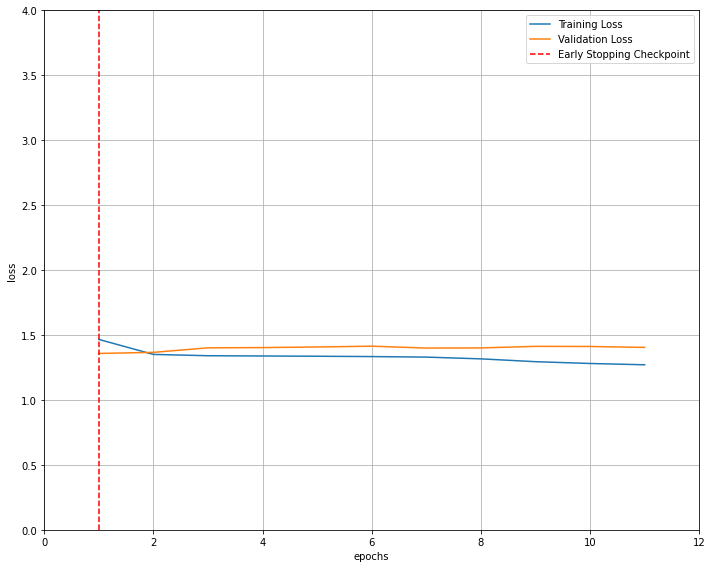

Finished analysis on User 25_interest
Starting size: (1653, 120, 8)
End size: (8265, 120, 8)
Early stopping
Fold  1! Time elapsed: 12.173474073410034 seconds
Starting size: (1702, 120, 8)
End size: (8510, 120, 8)
Early stopping
Fold  2! Time elapsed: 9.120521545410156 seconds
Starting size: (1706, 120, 8)
End size: (8530, 120, 8)
Early stopping
Fold  3! Time elapsed: 10.818718194961548 seconds
Starting size: (1824, 120, 8)
End size: (9120, 120, 8)
Early stopping
Fold  4! Time elapsed: 10.8170747756958 seconds
Starting size: (1695, 120, 8)
End size: (8475, 120, 8)
Early stopping
Fold  5! Time elapsed: 9.110902547836304 seconds
Normalized confusion matrix


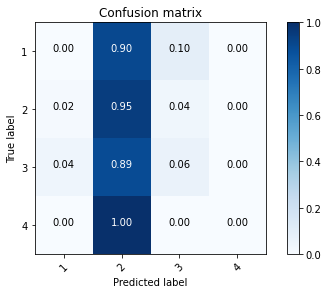

<Figure size 432x288 with 0 Axes>

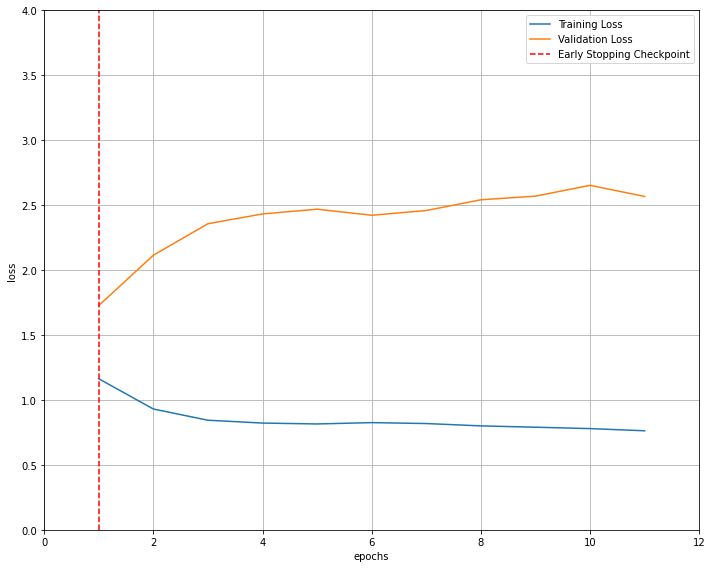

Finished analysis on User 25_effort
Finished analysis on User 25
All analyses are complete! Time elapsed: 2102.1774916648865
Working on label attention
Starting size: (14968, 120, 8)
End size: (74840, 120, 8)
Early stopping
Fold  1! Time elapsed: 80.88014388084412 seconds
Starting size: (15999, 120, 8)
End size: (79995, 120, 8)
Early stopping
Fold  2! Time elapsed: 86.05391764640808 seconds
Starting size: (15803, 120, 8)
End size: (79015, 120, 8)
Early stopping
Fold  3! Time elapsed: 84.94137263298035 seconds
Starting size: (19117, 120, 8)
End size: (95585, 120, 8)
Early stopping
Fold  4! Time elapsed: 147.9052379131317 seconds
Starting size: (17117, 120, 8)
End size: (85585, 120, 8)
Early stopping
Fold  5! Time elapsed: 91.50204491615295 seconds
Normalized confusion matrix


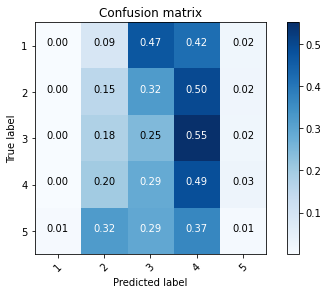

<Figure size 432x288 with 0 Axes>

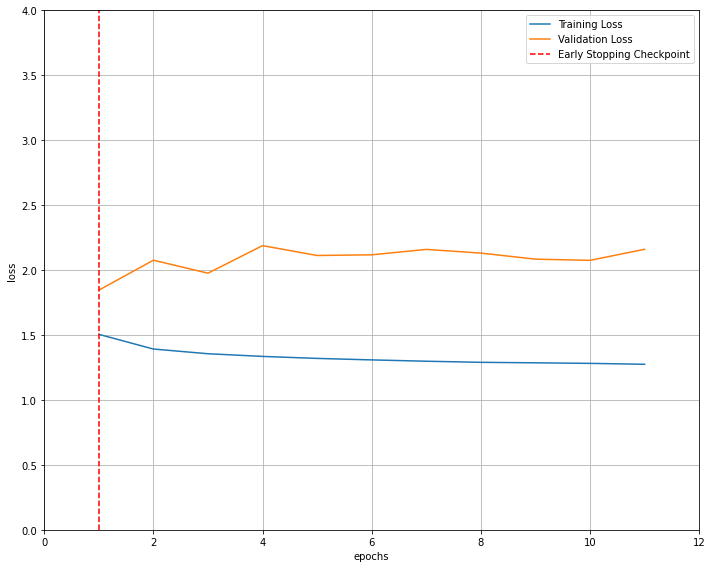

Finished analysis on label attention. Time elapsed 511.9246129989624
Working on label interest
Starting size: (14968, 120, 8)
End size: (74840, 120, 8)
Early stopping
Fold  1! Time elapsed: 80.76323246955872 seconds
Starting size: (15999, 120, 8)
End size: (79995, 120, 8)
Early stopping
Fold  2! Time elapsed: 85.82175087928772 seconds
Starting size: (15803, 120, 8)
End size: (79015, 120, 8)
Early stopping
Fold  3! Time elapsed: 86.00019431114197 seconds
Starting size: (19117, 120, 8)
End size: (95585, 120, 8)
Early stopping
Fold  4! Time elapsed: 175.42691493034363 seconds
Starting size: (17117, 120, 8)
End size: (85585, 120, 8)
Early stopping
Fold  5! Time elapsed: 91.43644618988037 seconds
Normalized confusion matrix


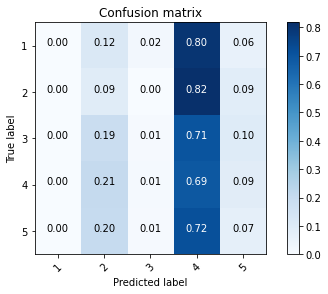

<Figure size 432x288 with 0 Axes>

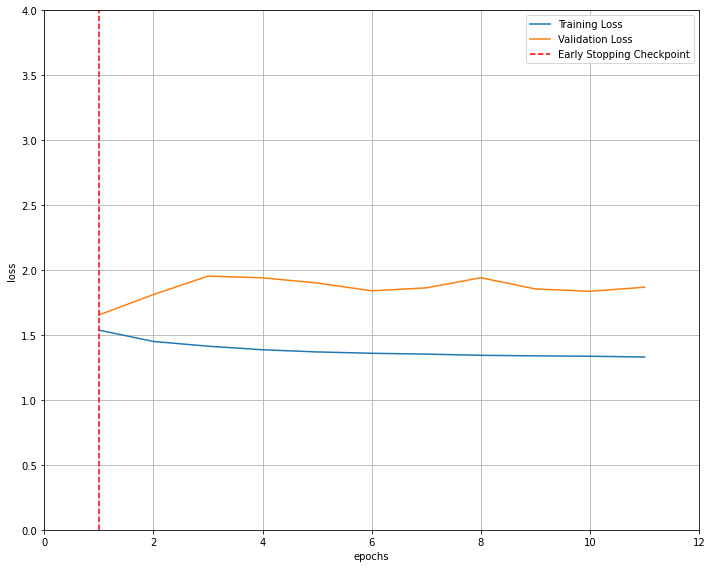

Finished analysis on label interest. Time elapsed 540.2599096298218
Working on label effort
Starting size: (14968, 120, 8)
End size: (74840, 120, 8)
Early stopping
Fold  1! Time elapsed: 80.90543675422668 seconds
Starting size: (15999, 120, 8)
End size: (79995, 120, 8)
Early stopping
Fold  2! Time elapsed: 93.89759731292725 seconds
Starting size: (15803, 120, 8)
End size: (79015, 120, 8)
Early stopping
Fold  3! Time elapsed: 85.02284860610962 seconds
Starting size: (19117, 120, 8)
End size: (95585, 120, 8)
Early stopping
Fold  4! Time elapsed: 101.50253796577454 seconds
Starting size: (17117, 120, 8)
End size: (85585, 120, 8)
Early stopping
Fold  5! Time elapsed: 91.58633947372437 seconds
Normalized confusion matrix


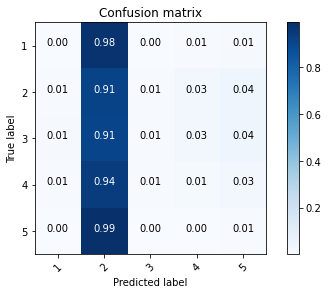

<Figure size 432x288 with 0 Axes>

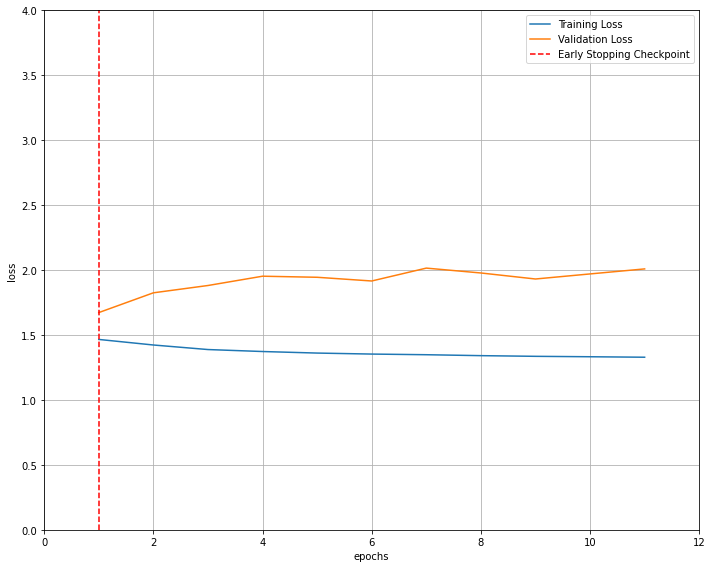

Finished analysis on label effort. Time elapsed 473.5571098327637
Finished analysis on User all
All analyses are complete! Time elapsed: 1525.8159203529358
Working on user 1
Starting size: (531, 120, 8)
End size: (2655, 120, 8)
Early stopping
Fold  1! Time elapsed: 4.78155255317688 seconds
Starting size: (526, 120, 8)
End size: (2630, 120, 8)
Early stopping
Fold  2! Time elapsed: 6.164491176605225 seconds
Starting size: (559, 120, 8)
End size: (2795, 120, 8)
Early stopping
Fold  3! Time elapsed: 4.705574989318848 seconds
Starting size: (536, 120, 8)
End size: (2680, 120, 8)
Early stopping
Fold  4! Time elapsed: 5.086181163787842 seconds
Normalized confusion matrix


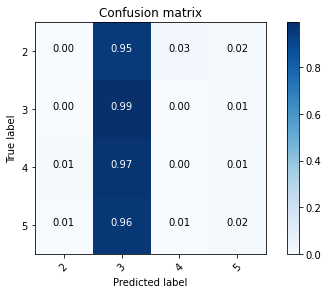

<Figure size 432x288 with 0 Axes>

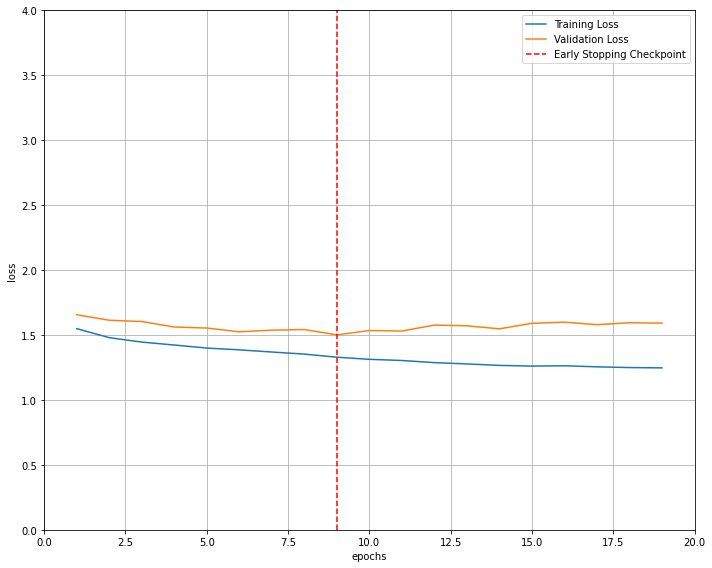

Finished analysis on User 1_attention
Starting size: (580, 120, 8)
End size: (2900, 120, 8)
Early stopping
Fold  1! Time elapsed: 3.094722270965576 seconds
Starting size: (526, 120, 8)
End size: (2630, 120, 8)
Early stopping
Fold  2! Time elapsed: 5.748500823974609 seconds
Starting size: (559, 120, 8)
End size: (2795, 120, 8)
Early stopping
Fold  3! Time elapsed: 3.8456051349639893 seconds
Starting size: (536, 120, 8)
End size: (2680, 120, 8)
Early stopping
Fold  4! Time elapsed: 4.252911567687988 seconds
Normalized confusion matrix


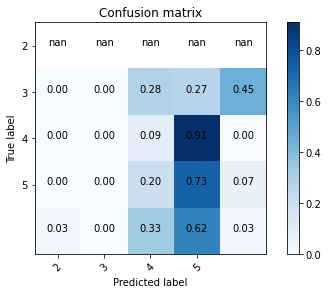

<Figure size 432x288 with 0 Axes>

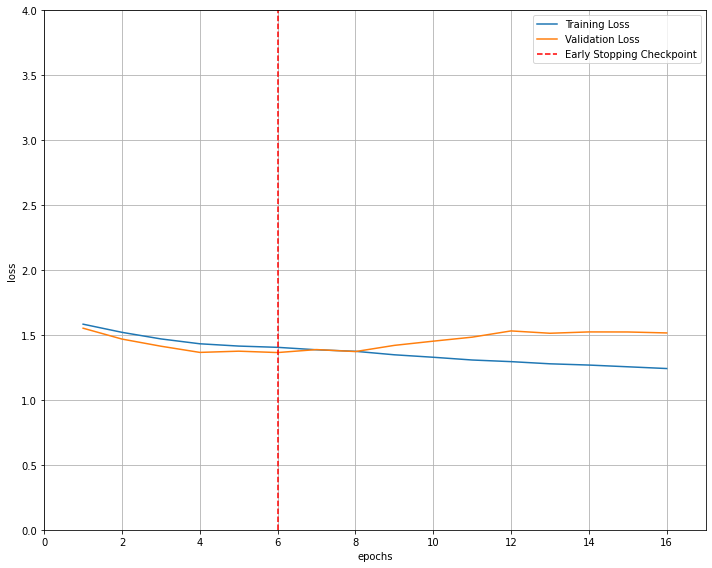

Finished analysis on User 1_interest
Starting size: (531, 120, 8)
End size: (2655, 120, 8)
Early stopping
Fold  1! Time elapsed: 2.9175379276275635 seconds
Starting size: (580, 120, 8)
End size: (2900, 120, 8)
Early stopping
Fold  2! Time elapsed: 3.4108121395111084 seconds
Starting size: (526, 120, 8)
End size: (2630, 120, 8)
Early stopping
Fold  3! Time elapsed: 3.4951882362365723 seconds
Starting size: (559, 120, 8)
End size: (2795, 120, 8)
Early stopping
Fold  4! Time elapsed: 4.980729103088379 seconds
Starting size: (536, 120, 8)
End size: (2680, 120, 8)
Early stopping
Fold  5! Time elapsed: 3.996015787124634 seconds
Normalized confusion matrix


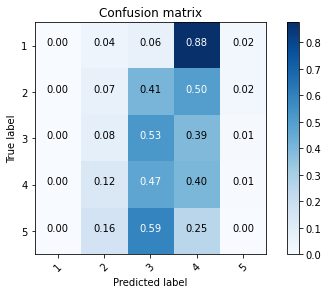

<Figure size 432x288 with 0 Axes>

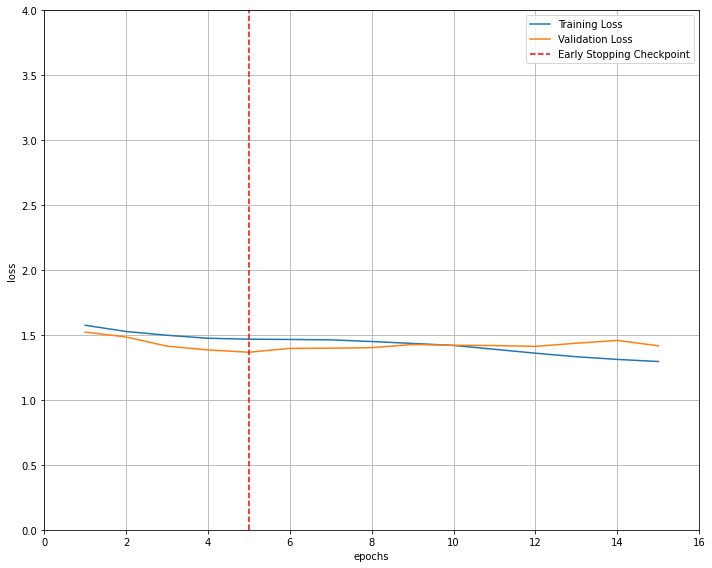

Finished analysis on User 1_effort
Finished analysis on User 1
Working on user 2
Starting size: (993, 120, 8)
End size: (4965, 120, 8)
Early stopping
Fold  1! Time elapsed: 7.341085195541382 seconds
Starting size: (975, 120, 8)
End size: (4875, 120, 8)
Early stopping
Fold  2! Time elapsed: 9.136328220367432 seconds
Starting size: (1044, 120, 8)
End size: (5220, 120, 8)
Early stopping
Fold  3! Time elapsed: 8.753145456314087 seconds
Starting size: (1066, 120, 8)
End size: (5330, 120, 8)
Early stopping
Fold  4! Time elapsed: 7.806711435317993 seconds
Normalized confusion matrix


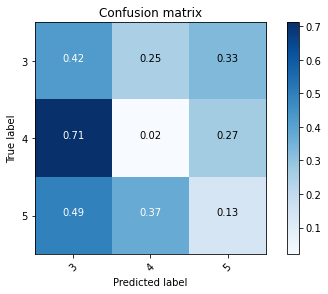

<Figure size 432x288 with 0 Axes>

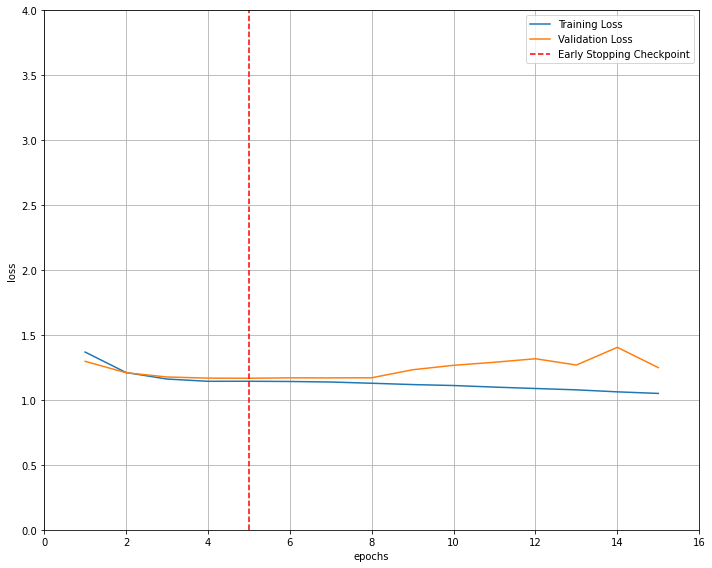

Finished analysis on User 2_attention
Starting size: (970, 120, 8)
End size: (4850, 120, 8)
Early stopping
Fold  1! Time elapsed: 7.149125099182129 seconds
Starting size: (975, 120, 8)
End size: (4875, 120, 8)
Early stopping
Fold  2! Time elapsed: 8.79929232597351 seconds
Starting size: (1044, 120, 8)
End size: (5220, 120, 8)
Early stopping
Fold  3! Time elapsed: 7.221729278564453 seconds
Starting size: (1066, 120, 8)
End size: (5330, 120, 8)
Early stopping
Fold  4! Time elapsed: 7.261322259902954 seconds
Normalized confusion matrix


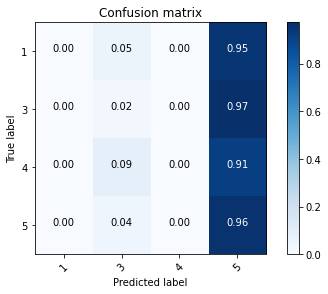

<Figure size 432x288 with 0 Axes>

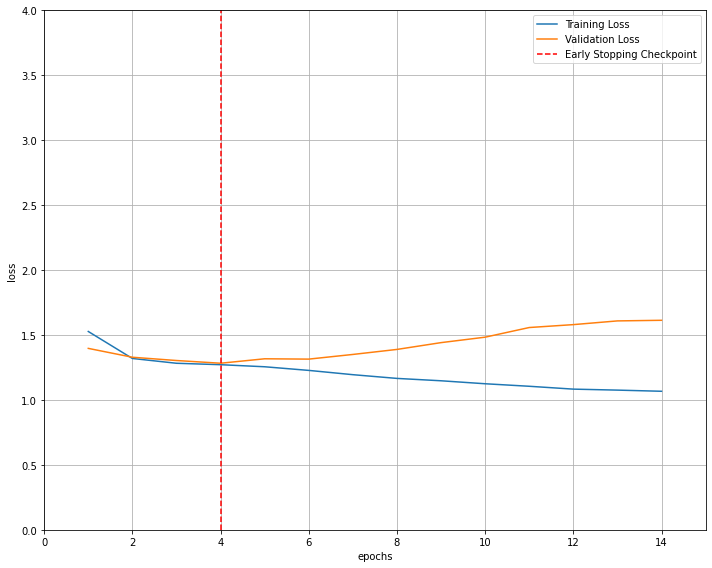

Finished analysis on User 2_interest
Starting size: (970, 120, 8)
End size: (4850, 120, 8)
Early stopping
Fold  1! Time elapsed: 8.0837082862854 seconds
Starting size: (993, 120, 8)
End size: (4965, 120, 8)
Early stopping
Fold  2! Time elapsed: 6.877725124359131 seconds
Starting size: (975, 120, 8)
End size: (4875, 120, 8)
Early stopping
Fold  3! Time elapsed: 7.334829568862915 seconds
Starting size: (1044, 120, 8)
End size: (5220, 120, 8)
Early stopping
Fold  4! Time elapsed: 5.61110520362854 seconds
Starting size: (1066, 120, 8)
End size: (5330, 120, 8)
Early stopping
Fold  5! Time elapsed: 7.292010307312012 seconds
Normalized confusion matrix


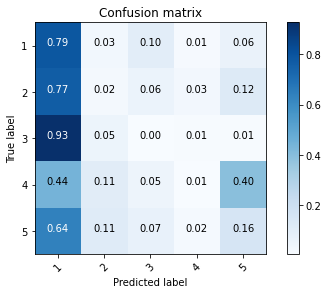

<Figure size 432x288 with 0 Axes>

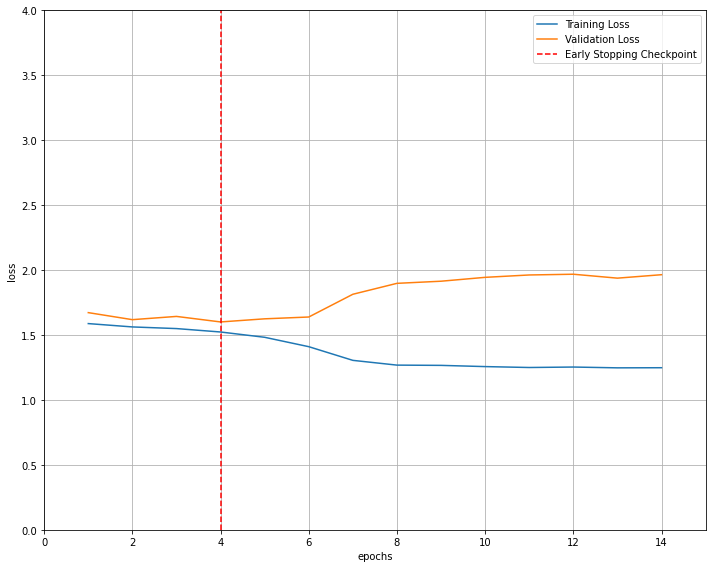

Finished analysis on User 2_effort
Finished analysis on User 2
Working on user 3
Starting size: (898, 120, 8)
End size: (4490, 120, 8)
Early stopping
Fold  1! Time elapsed: 4.840253591537476 seconds
Starting size: (904, 120, 8)
End size: (4520, 120, 8)
Early stopping
Fold  2! Time elapsed: 6.818212032318115 seconds
Starting size: (990, 120, 8)
End size: (4950, 120, 8)
Early stopping
Fold  3! Time elapsed: 6.239126205444336 seconds
Starting size: (858, 120, 8)
End size: (4290, 120, 8)
Early stopping
Fold  4! Time elapsed: 8.460705995559692 seconds
Starting size: (1046, 120, 8)
End size: (5230, 120, 8)
Early stopping
Fold  5! Time elapsed: 8.671767711639404 seconds
Normalized confusion matrix


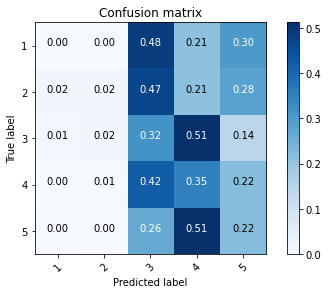

<Figure size 432x288 with 0 Axes>

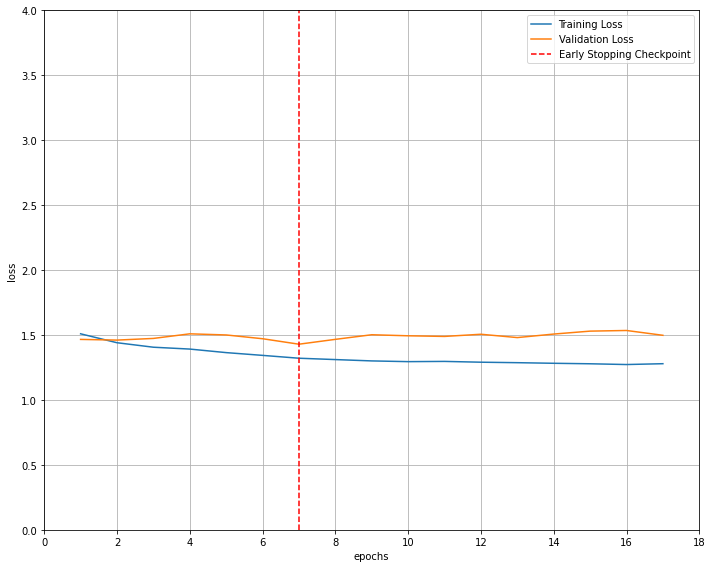

Finished analysis on User 3_attention
Starting size: (898, 120, 8)
End size: (4490, 120, 8)
Early stopping
Fold  1! Time elapsed: 4.89900541305542 seconds
Starting size: (904, 120, 8)
End size: (4520, 120, 8)
Early stopping
Fold  2! Time elapsed: 4.893854379653931 seconds
Starting size: (990, 120, 8)
End size: (4950, 120, 8)
Early stopping
Fold  3! Time elapsed: 7.3528666496276855 seconds
Starting size: (858, 120, 8)
End size: (4290, 120, 8)
Early stopping
Fold  4! Time elapsed: 9.352458953857422 seconds
Starting size: (1046, 120, 8)
End size: (5230, 120, 8)
Early stopping
Fold  5! Time elapsed: 6.1166112422943115 seconds
Normalized confusion matrix


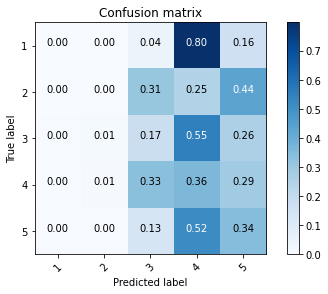

<Figure size 432x288 with 0 Axes>

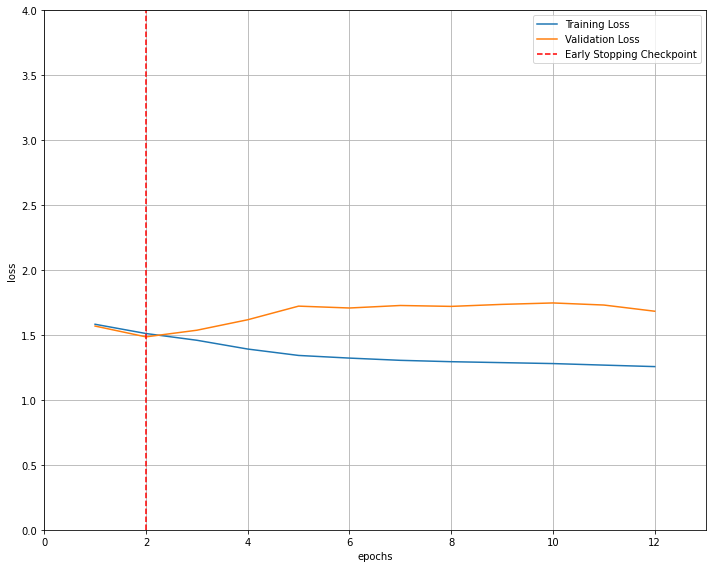

Finished analysis on User 3_interest
Starting size: (898, 120, 8)
End size: (4490, 120, 8)
Early stopping
Fold  1! Time elapsed: 5.29897403717041 seconds
Starting size: (904, 120, 8)
End size: (4520, 120, 8)
Early stopping
Fold  2! Time elapsed: 4.894843816757202 seconds
Starting size: (990, 120, 8)
End size: (4950, 120, 8)
Early stopping
Fold  3! Time elapsed: 5.3213276863098145 seconds
Starting size: (858, 120, 8)
End size: (4290, 120, 8)
Early stopping
Fold  4! Time elapsed: 6.342769384384155 seconds
Starting size: (1046, 120, 8)
End size: (5230, 120, 8)
Early stopping
Fold  5! Time elapsed: 5.5866663455963135 seconds
Normalized confusion matrix


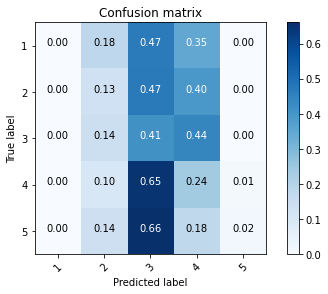

<Figure size 432x288 with 0 Axes>

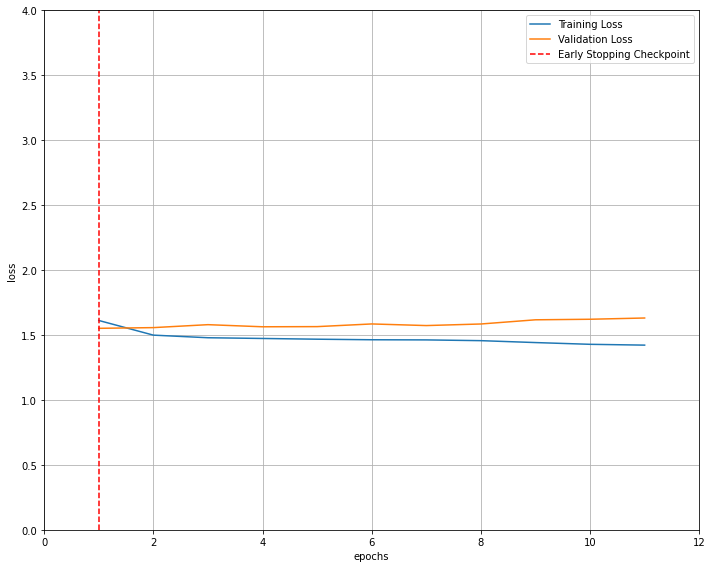

Finished analysis on User 3_effort
Finished analysis on User 3
Working on user 6
Starting size: (1034, 120, 8)
End size: (5170, 120, 8)
Early stopping
Fold  1! Time elapsed: 5.612966060638428 seconds
Starting size: (1168, 120, 8)
End size: (5840, 120, 8)
Early stopping
Fold  2! Time elapsed: 6.256699323654175 seconds
Starting size: (1143, 120, 8)
End size: (5715, 120, 8)
Early stopping
Fold  3! Time elapsed: 8.365481615066528 seconds
Starting size: (1074, 120, 8)
End size: (5370, 120, 8)
Early stopping
Fold  4! Time elapsed: 17.80619239807129 seconds
Starting size: (1145, 120, 8)
End size: (5725, 120, 8)
Early stopping
Fold  5! Time elapsed: 6.15669059753418 seconds
Normalized confusion matrix


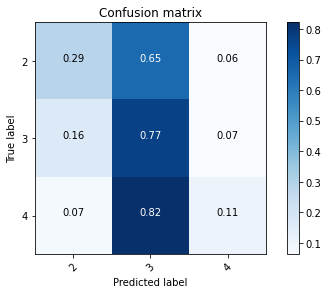

<Figure size 432x288 with 0 Axes>

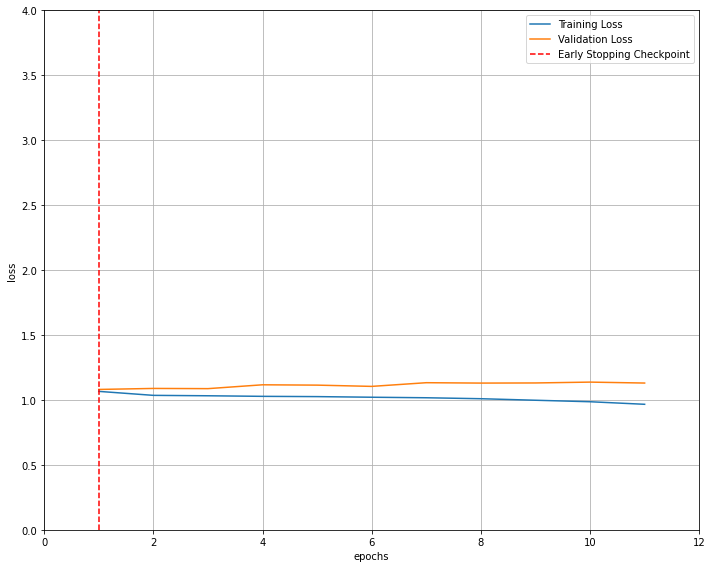

Finished analysis on User 6_attention
Starting size: (1034, 120, 8)
End size: (5170, 120, 8)
Early stopping
Fold  1! Time elapsed: 6.113424301147461 seconds
Starting size: (1168, 120, 8)
End size: (5840, 120, 8)
Early stopping
Fold  2! Time elapsed: 8.570208311080933 seconds
Starting size: (1143, 120, 8)
End size: (5715, 120, 8)
Early stopping
Fold  3! Time elapsed: 13.43648886680603 seconds
Starting size: (1074, 120, 8)
End size: (5370, 120, 8)
Early stopping
Fold  4! Time elapsed: 5.83939003944397 seconds
Starting size: (1145, 120, 8)
End size: (5725, 120, 8)
Early stopping
Fold  5! Time elapsed: 8.947736501693726 seconds
Normalized confusion matrix


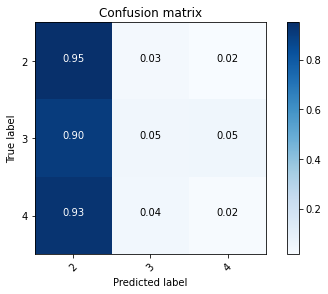

<Figure size 432x288 with 0 Axes>

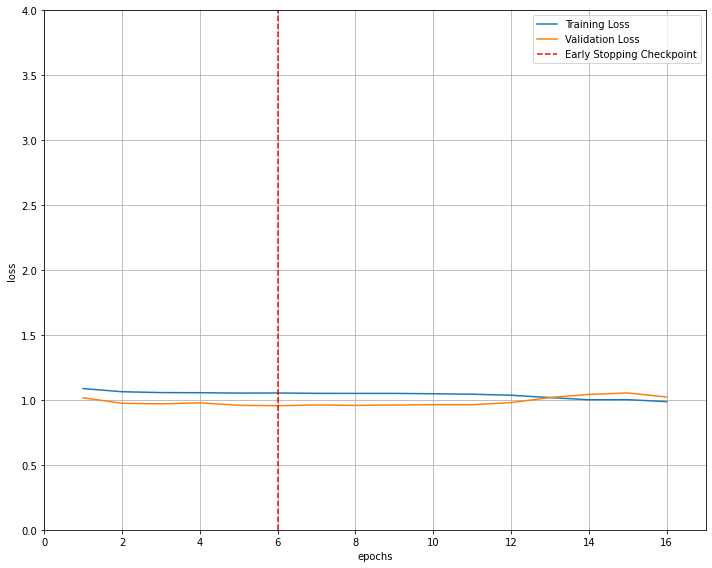

Finished analysis on User 6_interest
Starting size: (1034, 120, 8)
End size: (5170, 120, 8)
Early stopping
Fold  1! Time elapsed: 5.5998735427856445 seconds
Starting size: (1168, 120, 8)
End size: (5840, 120, 8)
Early stopping
Fold  2! Time elapsed: 10.283114671707153 seconds
Starting size: (1143, 120, 8)
End size: (5715, 120, 8)
Early stopping
Fold  3! Time elapsed: 7.268082141876221 seconds
Starting size: (1074, 120, 8)
End size: (5370, 120, 8)
Early stopping
Fold  4! Time elapsed: 5.800360441207886 seconds
Starting size: (1145, 120, 8)
End size: (5725, 120, 8)
Early stopping
Fold  5! Time elapsed: 25.58948826789856 seconds
Normalized confusion matrix


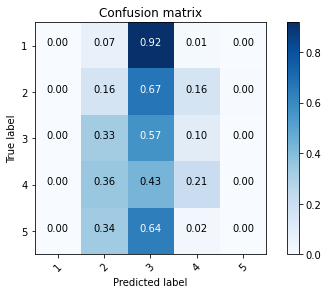

<Figure size 432x288 with 0 Axes>

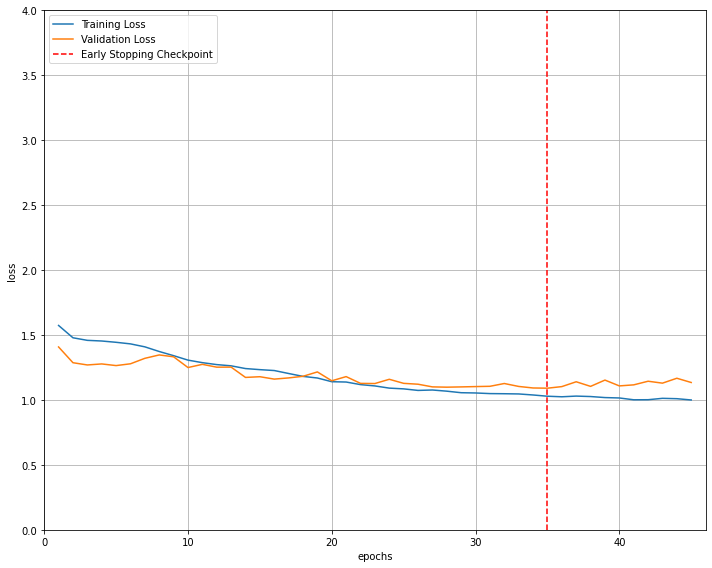

Finished analysis on User 6_effort
Finished analysis on User 6
Working on user 7
Starting size: (1146, 120, 8)
End size: (5730, 120, 8)
Early stopping
Fold  1! Time elapsed: 20.981563568115234 seconds
Starting size: (1117, 120, 8)
End size: (5585, 120, 8)
Early stopping
Fold  2! Time elapsed: 8.825317859649658 seconds
Starting size: (1143, 120, 8)
End size: (5715, 120, 8)
Early stopping
Fold  3! Time elapsed: 7.33760142326355 seconds
Starting size: (1120, 120, 8)
End size: (5600, 120, 8)
Early stopping
Fold  4! Time elapsed: 12.61931300163269 seconds
Normalized confusion matrix


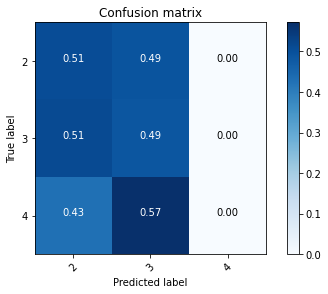

<Figure size 432x288 with 0 Axes>

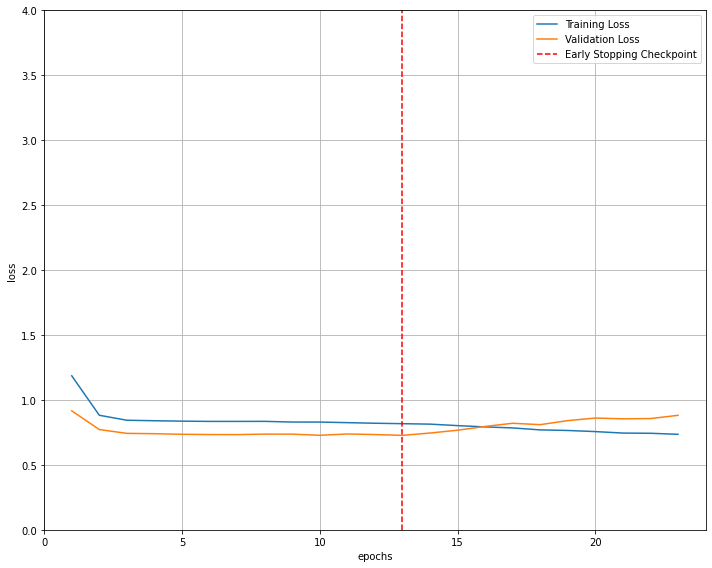

Finished analysis on User 7_attention
Starting size: (1146, 120, 8)
End size: (5730, 120, 8)
Early stopping
Fold  1! Time elapsed: 7.880825996398926 seconds
Starting size: (1117, 120, 8)
End size: (5585, 120, 8)
Early stopping
Fold  2! Time elapsed: 18.63866901397705 seconds
Starting size: (1143, 120, 8)
End size: (5715, 120, 8)
Early stopping
Fold  3! Time elapsed: 16.8704617023468 seconds
Starting size: (1120, 120, 8)
End size: (5600, 120, 8)
Early stopping
Fold  4! Time elapsed: 12.064818143844604 seconds
Normalized confusion matrix


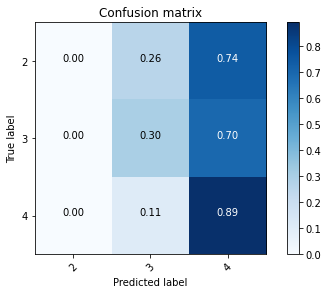

<Figure size 432x288 with 0 Axes>

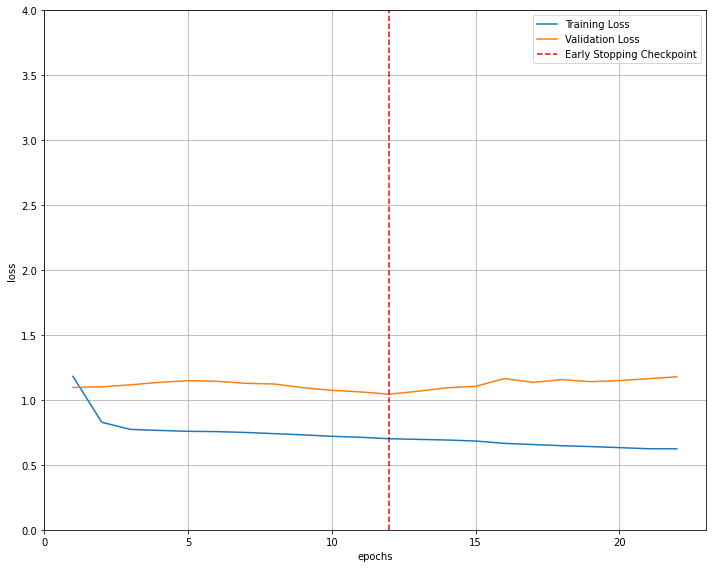

Finished analysis on User 7_interest
Starting size: (1146, 120, 8)
End size: (5730, 120, 8)
Early stopping
Fold  1! Time elapsed: 7.287225961685181 seconds
Starting size: (1138, 120, 8)
End size: (5690, 120, 8)
Early stopping
Fold  2! Time elapsed: 6.113451957702637 seconds
Starting size: (1117, 120, 8)
End size: (5585, 120, 8)
Early stopping
Fold  3! Time elapsed: 24.917292594909668 seconds
Starting size: (1143, 120, 8)
End size: (5715, 120, 8)
Early stopping
Fold  4! Time elapsed: 10.687899589538574 seconds
Starting size: (1120, 120, 8)
End size: (5600, 120, 8)
Early stopping
Fold  5! Time elapsed: 6.557764291763306 seconds
Normalized confusion matrix


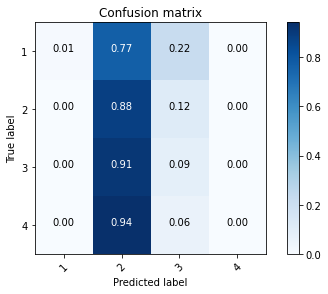

<Figure size 432x288 with 0 Axes>

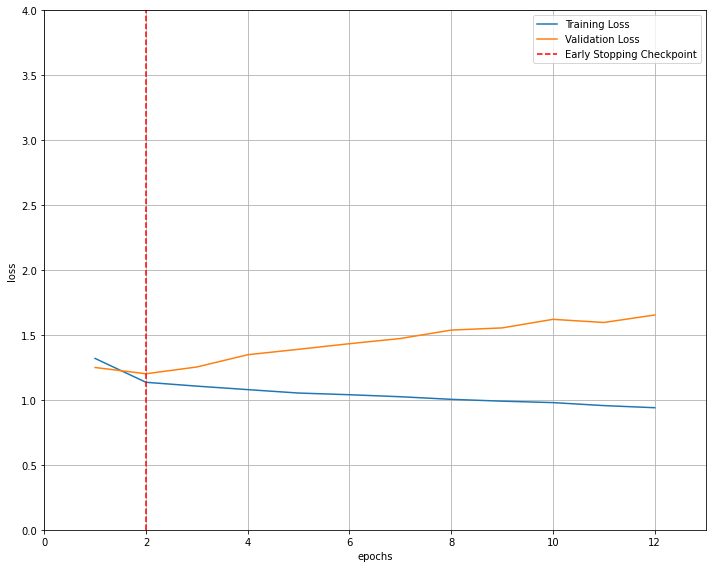

Finished analysis on User 7_effort
Finished analysis on User 7
Working on user 8
Starting size: (1302, 120, 8)
End size: (6510, 120, 8)
Early stopping
Fold  1! Time elapsed: 7.742743253707886 seconds
Starting size: (1406, 120, 8)
End size: (7030, 120, 8)
Early stopping
Fold  2! Time elapsed: 11.065154552459717 seconds
Starting size: (1510, 120, 8)
End size: (7550, 120, 8)
Early stopping
Fold  3! Time elapsed: 10.316308498382568 seconds
Starting size: (1479, 120, 8)
End size: (7395, 120, 8)
Early stopping
Fold  4! Time elapsed: 7.96105170249939 seconds
Starting size: (1575, 120, 8)
End size: (7875, 120, 8)
Early stopping
Fold  5! Time elapsed: 10.741574764251709 seconds
Normalized confusion matrix


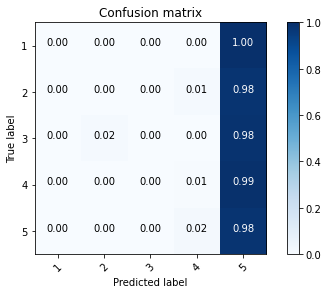

<Figure size 432x288 with 0 Axes>

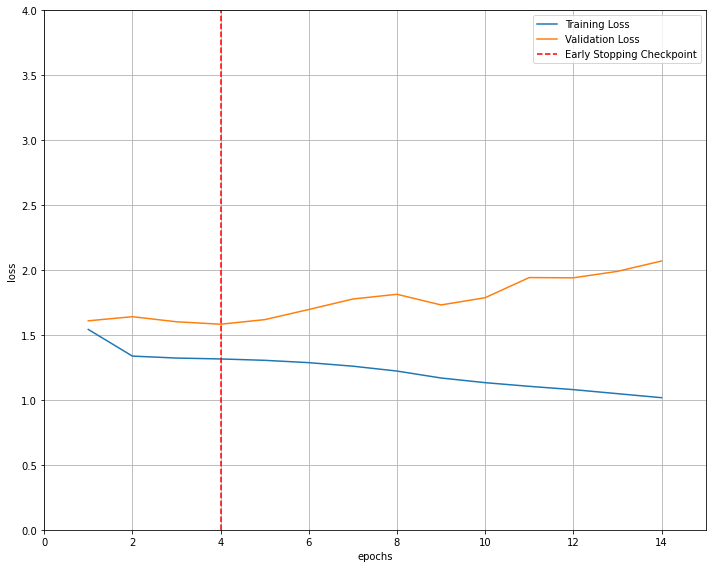

Finished analysis on User 8_attention
Starting size: (1302, 120, 8)
End size: (6510, 120, 8)
Early stopping
Fold  1! Time elapsed: 7.099658727645874 seconds
Starting size: (1406, 120, 8)
End size: (7030, 120, 8)
Early stopping
Fold  2! Time elapsed: 8.265653610229492 seconds
Starting size: (1510, 120, 8)
End size: (7550, 120, 8)
Early stopping
Fold  3! Time elapsed: 11.032551527023315 seconds
Starting size: (1479, 120, 8)
End size: (7395, 120, 8)
Early stopping
Fold  4! Time elapsed: 10.958739280700684 seconds
Starting size: (1575, 120, 8)
End size: (7875, 120, 8)
Early stopping
Fold  5! Time elapsed: 32.28446078300476 seconds
Normalized confusion matrix


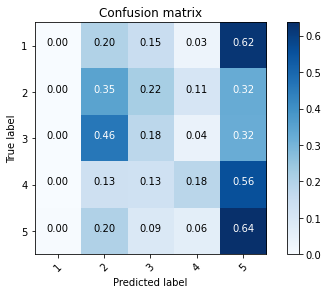

<Figure size 432x288 with 0 Axes>

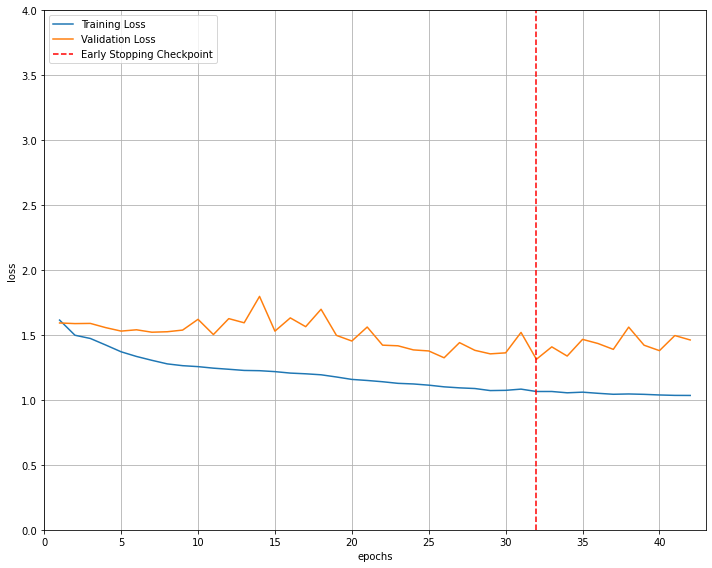

Finished analysis on User 8_interest
Starting size: (1302, 120, 8)
End size: (6510, 120, 8)
Early stopping
Fold  1! Time elapsed: 9.069793939590454 seconds
Starting size: (1406, 120, 8)
End size: (7030, 120, 8)
Early stopping
Fold  2! Time elapsed: 7.590435266494751 seconds
Starting size: (1510, 120, 8)
End size: (7550, 120, 8)
Early stopping
Fold  3! Time elapsed: 11.078356504440308 seconds
Starting size: (1479, 120, 8)
End size: (7395, 120, 8)
Early stopping
Fold  4! Time elapsed: 7.941894054412842 seconds
Starting size: (1575, 120, 8)
End size: (7875, 120, 8)
Early stopping
Fold  5! Time elapsed: 8.42337679862976 seconds
Normalized confusion matrix


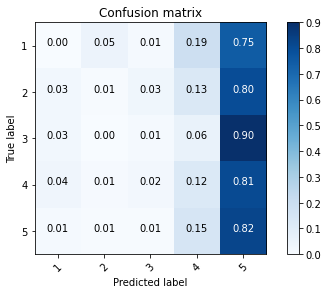

<Figure size 432x288 with 0 Axes>

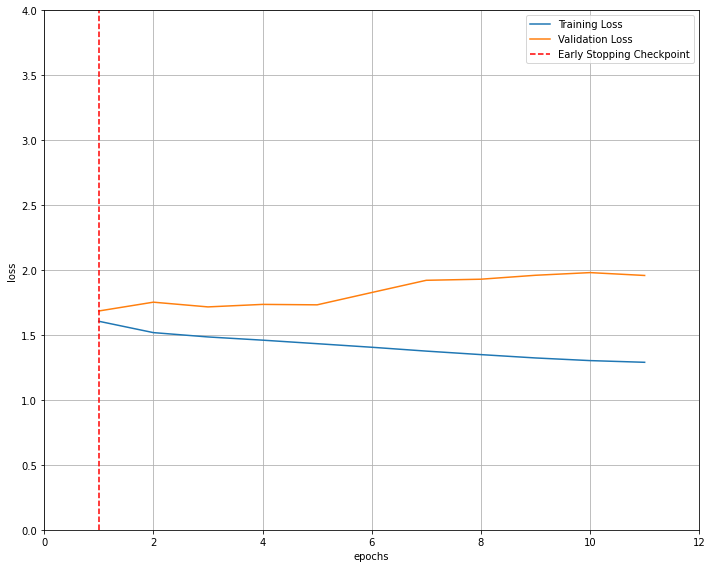

Finished analysis on User 8_effort
Finished analysis on User 8
Working on user 9
Starting size: (1706, 120, 8)
End size: (8530, 120, 8)
Early stopping
Fold  1! Time elapsed: 26.69253158569336 seconds
Starting size: (1677, 120, 8)
End size: (8385, 120, 8)
Early stopping
Fold  2! Time elapsed: 12.398094177246094 seconds
Starting size: (1585, 120, 8)
End size: (7925, 120, 8)
Early stopping
Fold  3! Time elapsed: 10.15781283378601 seconds
Starting size: (1569, 120, 8)
End size: (7845, 120, 8)
Early stopping
Fold  4! Time elapsed: 11.585611581802368 seconds
Starting size: (1727, 120, 8)
End size: (8635, 120, 8)
Early stopping
Fold  5! Time elapsed: 9.548407077789307 seconds
Normalized confusion matrix


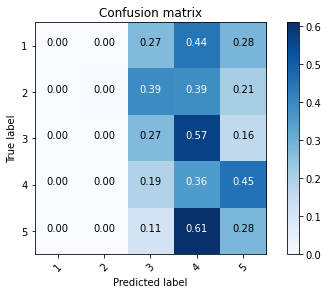

<Figure size 432x288 with 0 Axes>

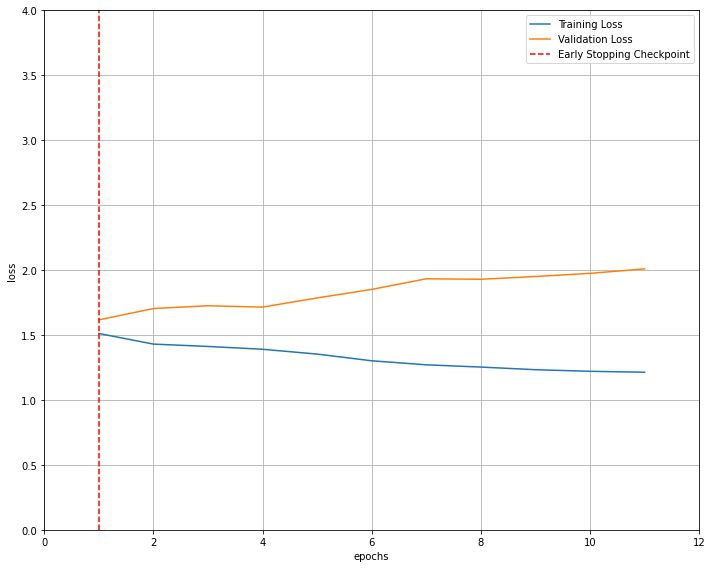

Finished analysis on User 9_attention
Starting size: (1706, 120, 8)
End size: (8530, 120, 8)
Early stopping
Fold  1! Time elapsed: 9.162602663040161 seconds
Starting size: (1677, 120, 8)
End size: (8385, 120, 8)
Early stopping
Fold  2! Time elapsed: 9.801628589630127 seconds
Starting size: (1585, 120, 8)
End size: (7925, 120, 8)
Early stopping
Fold  3! Time elapsed: 11.042378902435303 seconds
Starting size: (1569, 120, 8)
End size: (7845, 120, 8)
Early stopping
Fold  4! Time elapsed: 9.984037399291992 seconds
Starting size: (1727, 120, 8)
End size: (8635, 120, 8)
Early stopping
Fold  5! Time elapsed: 11.812880277633667 seconds
Normalized confusion matrix


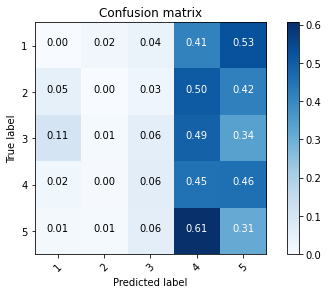

<Figure size 432x288 with 0 Axes>

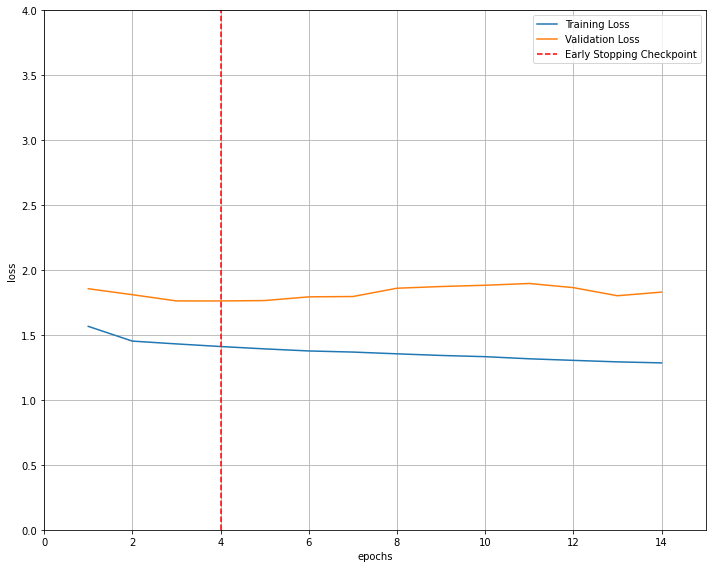

Finished analysis on User 9_interest
Starting size: (1706, 120, 8)
End size: (8530, 120, 8)
Early stopping
Fold  1! Time elapsed: 25.91861629486084 seconds
Starting size: (1677, 120, 8)
End size: (8385, 120, 8)
Early stopping
Fold  2! Time elapsed: 9.128839254379272 seconds
Starting size: (1585, 120, 8)
End size: (7925, 120, 8)
Early stopping
Fold  3! Time elapsed: 10.144214630126953 seconds
Starting size: (1569, 120, 8)
End size: (7845, 120, 8)
Early stopping
Fold  4! Time elapsed: 10.837130784988403 seconds
Starting size: (1727, 120, 8)
End size: (8635, 120, 8)
Early stopping
Fold  5! Time elapsed: 13.616135835647583 seconds
Normalized confusion matrix


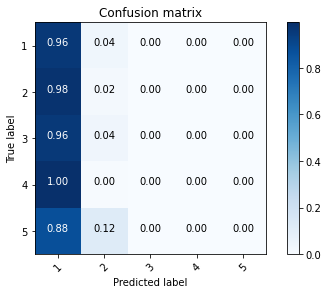

<Figure size 432x288 with 0 Axes>

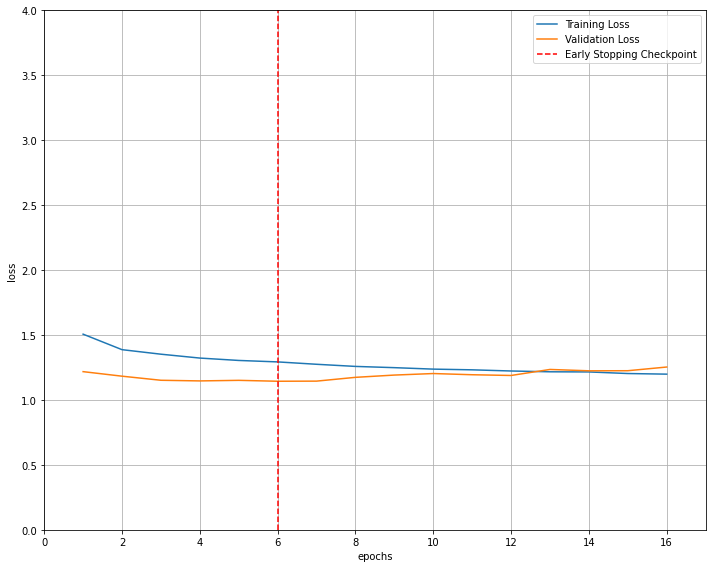

Finished analysis on User 9_effort
Finished analysis on User 9
Working on user 10
Starting size: (221, 120, 8)
End size: (1105, 120, 8)
Early stopping
Fold  1! Time elapsed: 1.2616755962371826 seconds
Starting size: (241, 120, 8)
End size: (1205, 120, 8)
Early stopping
Fold  2! Time elapsed: 1.5985724925994873 seconds
Starting size: (232, 120, 8)
End size: (1160, 120, 8)
Early stopping
Fold  3! Time elapsed: 4.477578639984131 seconds
Starting size: (230, 120, 8)
End size: (1150, 120, 8)
Early stopping
Fold  4! Time elapsed: 1.736177682876587 seconds
Starting size: (228, 120, 8)
End size: (1140, 120, 8)
Early stopping
Fold  5! Time elapsed: 1.261559009552002 seconds
Normalized confusion matrix


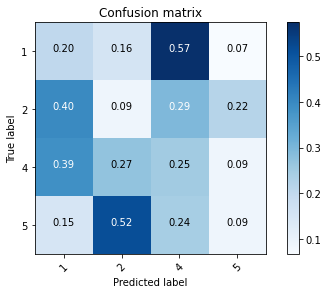

<Figure size 432x288 with 0 Axes>

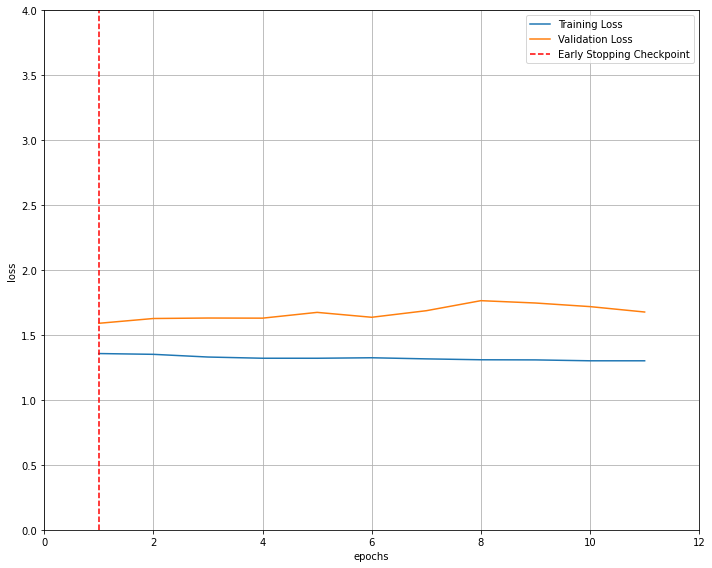

Finished analysis on User 10_attention
Starting size: (221, 120, 8)
End size: (1105, 120, 8)
Early stopping
Fold  1! Time elapsed: 2.4330389499664307 seconds
Starting size: (241, 120, 8)
End size: (1205, 120, 8)
Early stopping
Fold  2! Time elapsed: 1.3431870937347412 seconds
Starting size: (232, 120, 8)
End size: (1160, 120, 8)
Early stopping
Fold  3! Time elapsed: 3.0090420246124268 seconds
Starting size: (230, 120, 8)
End size: (1150, 120, 8)
Early stopping
Fold  4! Time elapsed: 1.2569994926452637 seconds
Starting size: (228, 120, 8)
End size: (1140, 120, 8)
Early stopping
Fold  5! Time elapsed: 1.2564575672149658 seconds
Normalized confusion matrix


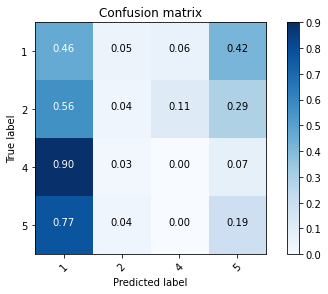

<Figure size 432x288 with 0 Axes>

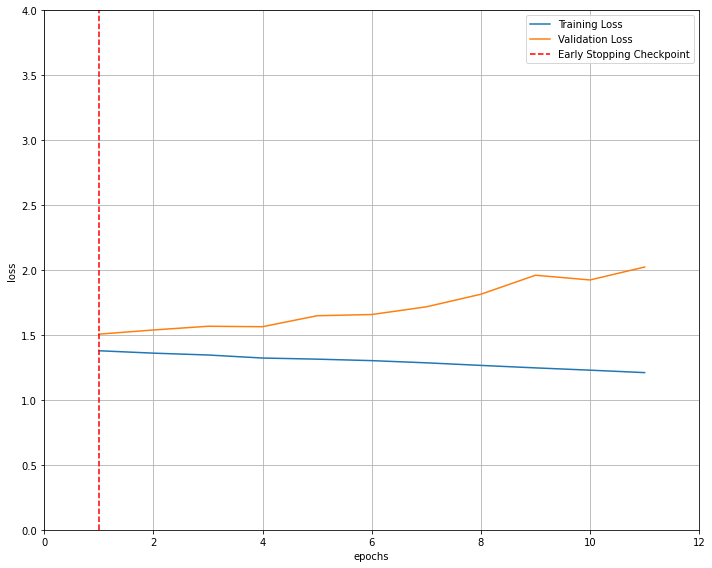

Finished analysis on User 10_interest
Starting size: (221, 120, 8)
End size: (1105, 120, 8)
Early stopping
Fold  1! Time elapsed: 3.4595556259155273 seconds
Starting size: (241, 120, 8)
End size: (1205, 120, 8)
Early stopping
Fold  2! Time elapsed: 1.4652326107025146 seconds
Starting size: (232, 120, 8)
End size: (1160, 120, 8)
Early stopping
Fold  3! Time elapsed: 1.5479204654693604 seconds
Starting size: (230, 120, 8)
End size: (1150, 120, 8)
Early stopping
Fold  4! Time elapsed: 1.253941297531128 seconds
Starting size: (228, 120, 8)
End size: (1140, 120, 8)
Early stopping
Fold  5! Time elapsed: 4.490625619888306 seconds
Normalized confusion matrix


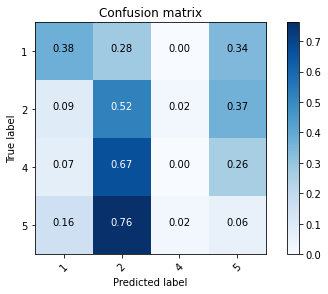

<Figure size 432x288 with 0 Axes>

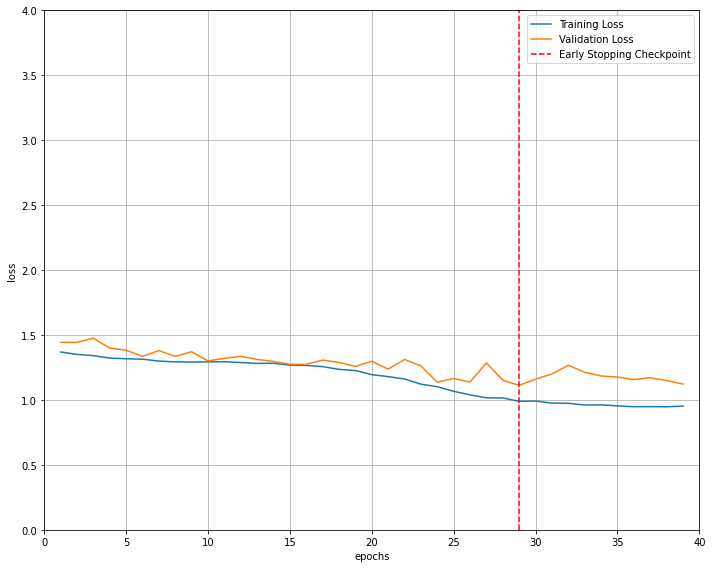

Finished analysis on User 10_effort
Finished analysis on User 10
Working on user 11
Starting size: (526, 120, 8)
End size: (2630, 120, 8)
Early stopping
Fold  1! Time elapsed: 4.079742193222046 seconds
Starting size: (564, 120, 8)
End size: (2820, 120, 8)
Early stopping
Fold  2! Time elapsed: 3.312922239303589 seconds
Starting size: (569, 120, 8)
End size: (2845, 120, 8)
Early stopping
Fold  3! Time elapsed: 4.465342998504639 seconds
Starting size: (511, 120, 8)
End size: (2555, 120, 8)
Early stopping
Fold  4! Time elapsed: 5.246275901794434 seconds
Starting size: (506, 120, 8)
End size: (2530, 120, 8)
Early stopping
Fold  5! Time elapsed: 2.8063907623291016 seconds
Normalized confusion matrix


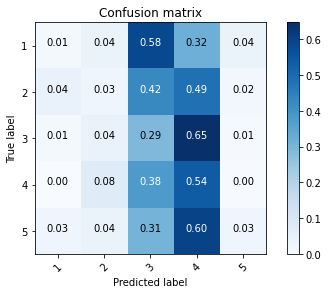

<Figure size 432x288 with 0 Axes>

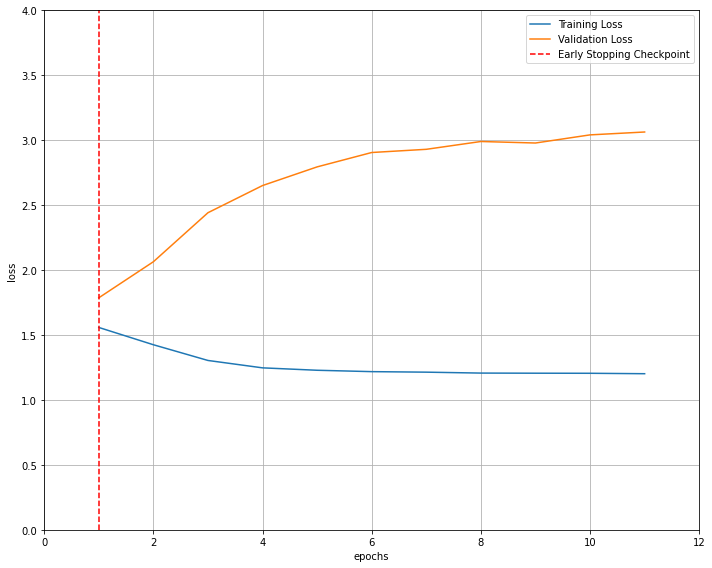

Finished analysis on User 11_attention
Starting size: (526, 120, 8)
End size: (2630, 120, 8)
Early stopping
Fold  1! Time elapsed: 5.955727577209473 seconds
Starting size: (564, 120, 8)
End size: (2820, 120, 8)
Early stopping
Fold  2! Time elapsed: 3.1888506412506104 seconds
Starting size: (569, 120, 8)
End size: (2845, 120, 8)
Early stopping
Fold  3! Time elapsed: 3.052671432495117 seconds
Starting size: (511, 120, 8)
End size: (2555, 120, 8)
Early stopping
Fold  4! Time elapsed: 2.810929775238037 seconds
Starting size: (506, 120, 8)
End size: (2530, 120, 8)
Early stopping
Fold  5! Time elapsed: 2.763680934906006 seconds
Normalized confusion matrix


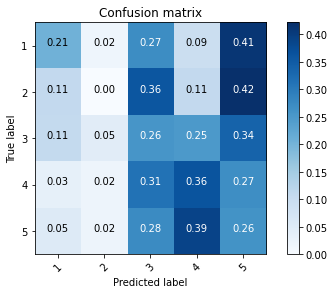

<Figure size 432x288 with 0 Axes>

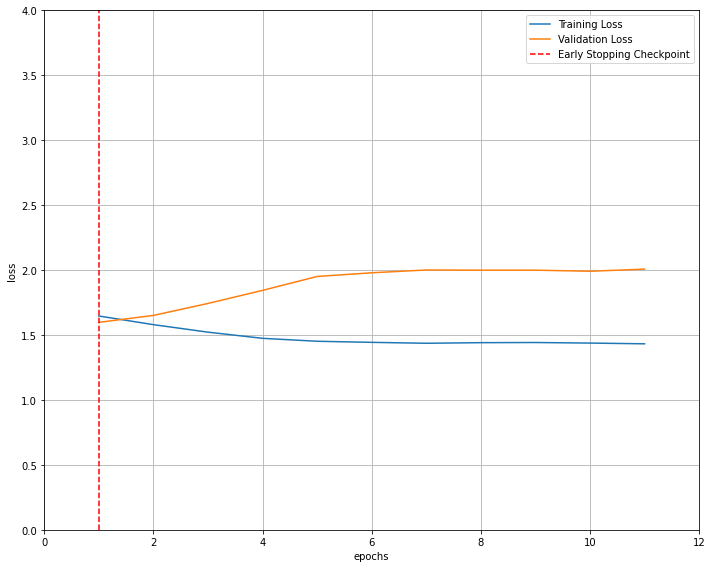

Finished analysis on User 11_interest
Starting size: (526, 120, 8)
End size: (2630, 120, 8)
Early stopping
Fold  1! Time elapsed: 3.1402392387390137 seconds
Starting size: (564, 120, 8)
End size: (2820, 120, 8)
Early stopping
Fold  2! Time elapsed: 3.646784543991089 seconds
Starting size: (569, 120, 8)
End size: (2845, 120, 8)
Early stopping
Fold  3! Time elapsed: 3.1885275840759277 seconds
Starting size: (511, 120, 8)
End size: (2555, 120, 8)
Early stopping
Fold  4! Time elapsed: 2.810145854949951 seconds
Starting size: (506, 120, 8)
End size: (2530, 120, 8)
Early stopping
Fold  5! Time elapsed: 7.087549209594727 seconds
Normalized confusion matrix


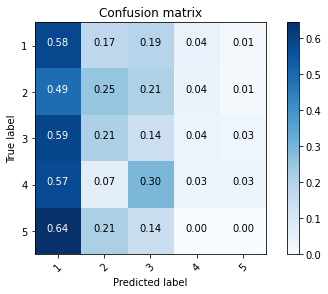

<Figure size 432x288 with 0 Axes>

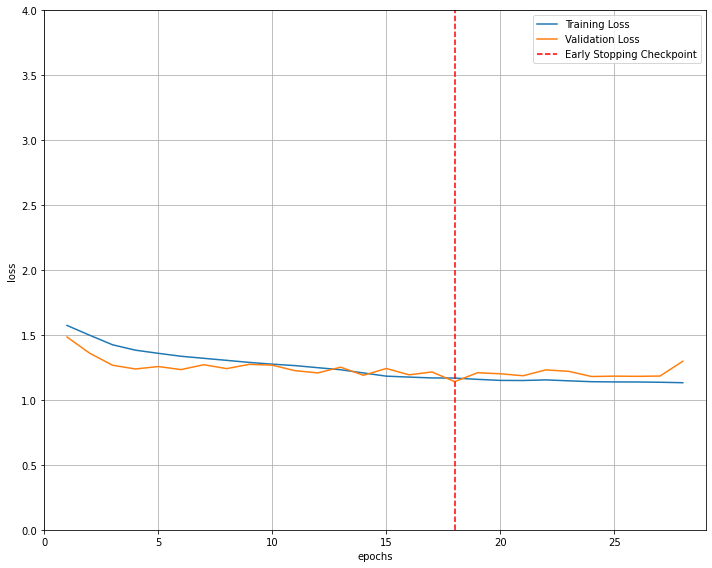

Finished analysis on User 11_effort
Finished analysis on User 11
Working on user 12
Starting size: (72, 120, 8)
End size: (360, 120, 8)
Early stopping
Fold  1! Time elapsed: 0.510242223739624 seconds
Starting size: (67, 120, 8)
End size: (335, 120, 8)
Early stopping
Fold  2! Time elapsed: 1.9758756160736084 seconds
Starting size: (46, 120, 8)
End size: (230, 120, 8)
Early stopping
Fold  3! Time elapsed: 0.7264268398284912 seconds
Starting size: (79, 120, 8)
End size: (395, 120, 8)
Early stopping
Fold  4! Time elapsed: 1.1994152069091797 seconds
Starting size: (80, 120, 8)
End size: (400, 120, 8)
Early stopping
Fold  5! Time elapsed: 1.2851712703704834 seconds
Normalized confusion matrix


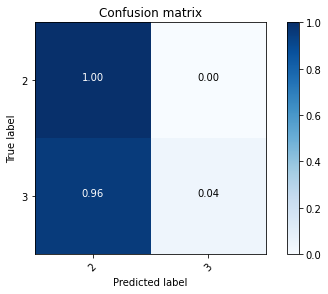

<Figure size 432x288 with 0 Axes>

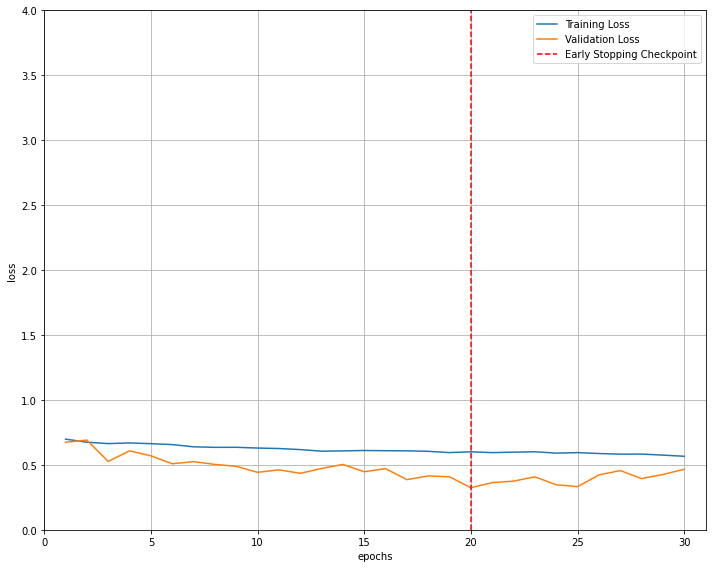

Finished analysis on User 12_attention
Starting size: (72, 120, 8)
End size: (360, 120, 8)
Early stopping
Fold  1! Time elapsed: 0.7271437644958496 seconds
Starting size: (67, 120, 8)
End size: (335, 120, 8)
Early stopping
Fold  2! Time elapsed: 0.4334583282470703 seconds
Starting size: (79, 120, 8)
End size: (395, 120, 8)
Early stopping
Fold  3! Time elapsed: 0.7136859893798828 seconds
Starting size: (80, 120, 8)
End size: (400, 120, 8)
Early stopping
Fold  4! Time elapsed: 0.501708984375 seconds
Normalized confusion matrix


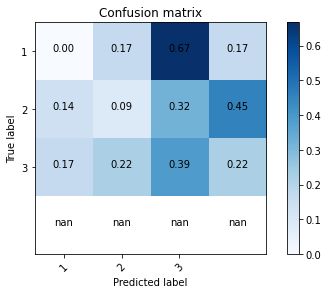

<Figure size 432x288 with 0 Axes>

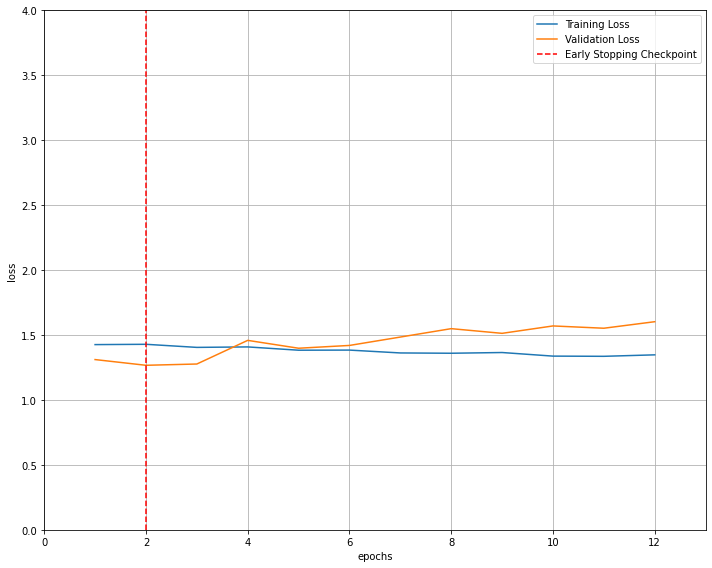

Finished analysis on User 12_interest
Starting size: (72, 120, 8)
End size: (360, 120, 8)
Early stopping
Fold  1! Time elapsed: 0.6165180206298828 seconds
Starting size: (46, 120, 8)
End size: (230, 120, 8)
Early stopping
Fold  2! Time elapsed: 0.48675060272216797 seconds
Starting size: (80, 120, 8)
End size: (400, 120, 8)
Early stopping
Fold  3! Time elapsed: 0.8603057861328125 seconds
Normalized confusion matrix


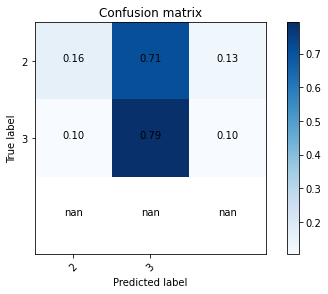

<Figure size 432x288 with 0 Axes>

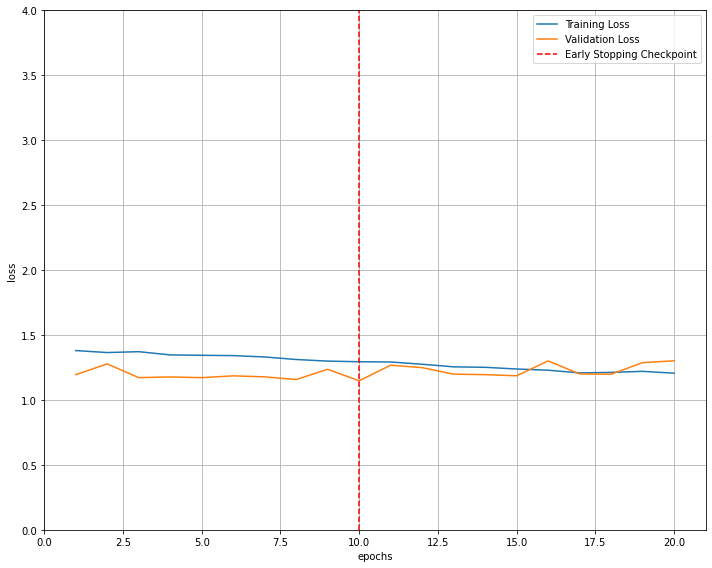

Finished analysis on User 12_effort
Finished analysis on User 12
Working on user 17
Starting size: (697, 120, 8)
End size: (3485, 120, 8)
Early stopping
Fold  1! Time elapsed: 4.448501348495483 seconds
Starting size: (677, 120, 8)
End size: (3385, 120, 8)
Early stopping
Fold  2! Time elapsed: 14.027996063232422 seconds
Starting size: (645, 120, 8)
End size: (3225, 120, 8)
Early stopping
Fold  3! Time elapsed: 4.823187589645386 seconds
Starting size: (677, 120, 8)
End size: (3385, 120, 8)
Early stopping
Fold  4! Time elapsed: 5.355597019195557 seconds
Starting size: (736, 120, 8)
End size: (3680, 120, 8)
Early stopping
Fold  5! Time elapsed: 6.273014307022095 seconds
Normalized confusion matrix


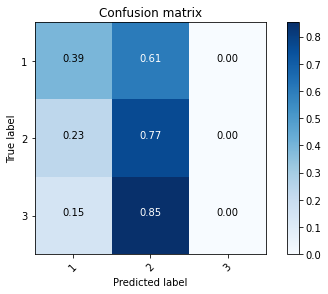

<Figure size 432x288 with 0 Axes>

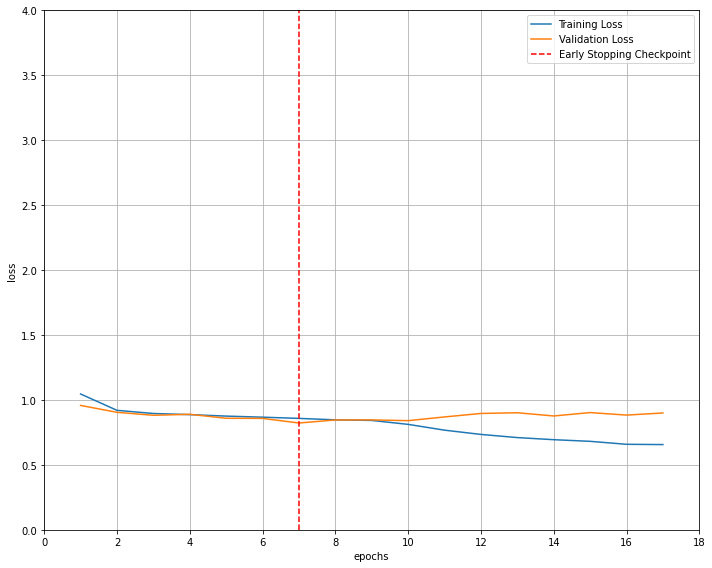

Finished analysis on User 17_attention
Starting size: (697, 120, 8)
End size: (3485, 120, 8)
Early stopping
Fold  1! Time elapsed: 5.8626251220703125 seconds
Starting size: (677, 120, 8)
End size: (3385, 120, 8)
Early stopping
Fold  2! Time elapsed: 9.062689781188965 seconds
Starting size: (645, 120, 8)
End size: (3225, 120, 8)
Early stopping
Fold  3! Time elapsed: 11.635549068450928 seconds
Starting size: (677, 120, 8)
End size: (3385, 120, 8)
Early stopping
Fold  4! Time elapsed: 4.006898403167725 seconds
Starting size: (736, 120, 8)
End size: (3680, 120, 8)
Early stopping
Fold  5! Time elapsed: 5.797424077987671 seconds
Normalized confusion matrix


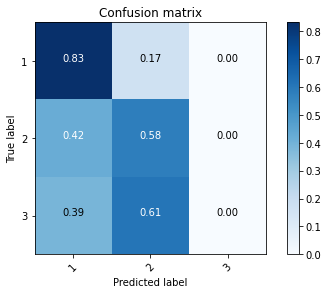

<Figure size 432x288 with 0 Axes>

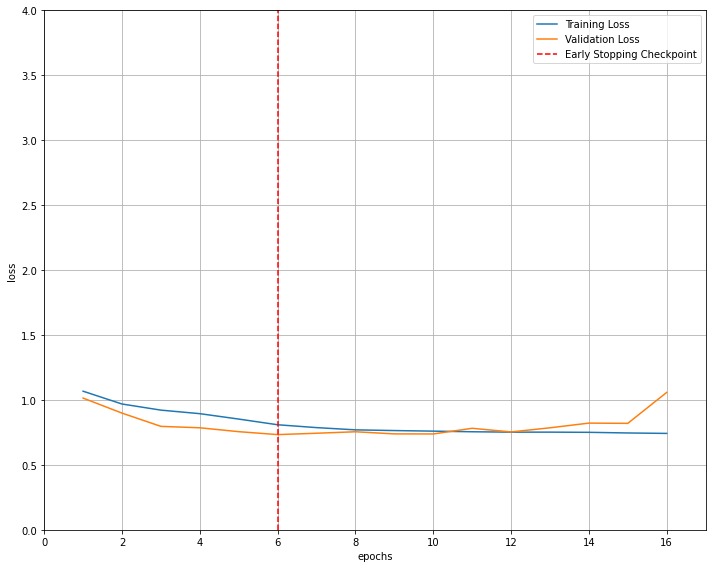

Finished analysis on User 17_interest
Starting size: (697, 120, 8)
End size: (3485, 120, 8)
Early stopping
Fold  1! Time elapsed: 4.804535388946533 seconds
Starting size: (677, 120, 8)
End size: (3385, 120, 8)
Early stopping
Fold  2! Time elapsed: 4.661807060241699 seconds
Starting size: (645, 120, 8)
End size: (3225, 120, 8)
Early stopping
Fold  3! Time elapsed: 3.845207452774048 seconds
Starting size: (677, 120, 8)
End size: (3385, 120, 8)
Early stopping
Fold  4! Time elapsed: 4.334089040756226 seconds
Starting size: (736, 120, 8)
End size: (3680, 120, 8)
Early stopping
Fold  5! Time elapsed: 9.142020463943481 seconds
Normalized confusion matrix


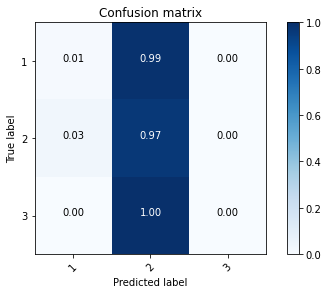

<Figure size 432x288 with 0 Axes>

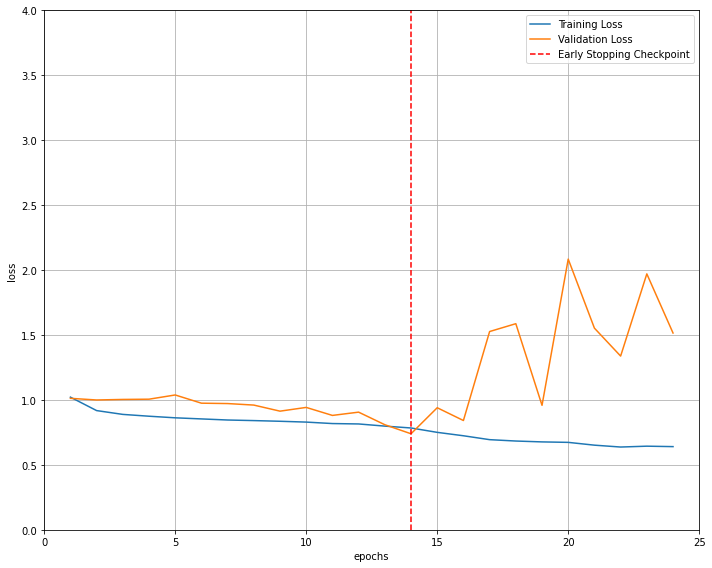

Finished analysis on User 17_effort
Finished analysis on User 17
Working on user 18
Starting size: (1070, 120, 8)
End size: (5350, 120, 8)
Early stopping
Fold  1! Time elapsed: 6.857828378677368 seconds
Starting size: (1203, 120, 8)
End size: (6015, 120, 8)
Early stopping
Fold  2! Time elapsed: 6.484301567077637 seconds
Starting size: (1166, 120, 8)
End size: (5830, 120, 8)
Early stopping
Fold  3! Time elapsed: 7.987196683883667 seconds
Starting size: (1112, 120, 8)
End size: (5560, 120, 8)
Early stopping
Fold  4! Time elapsed: 6.015754461288452 seconds
Starting size: (1185, 120, 8)
End size: (5925, 120, 8)
Early stopping
Fold  5! Time elapsed: 7.545877933502197 seconds
Normalized confusion matrix


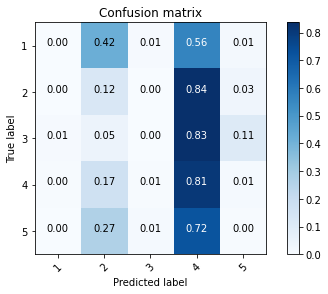

<Figure size 432x288 with 0 Axes>

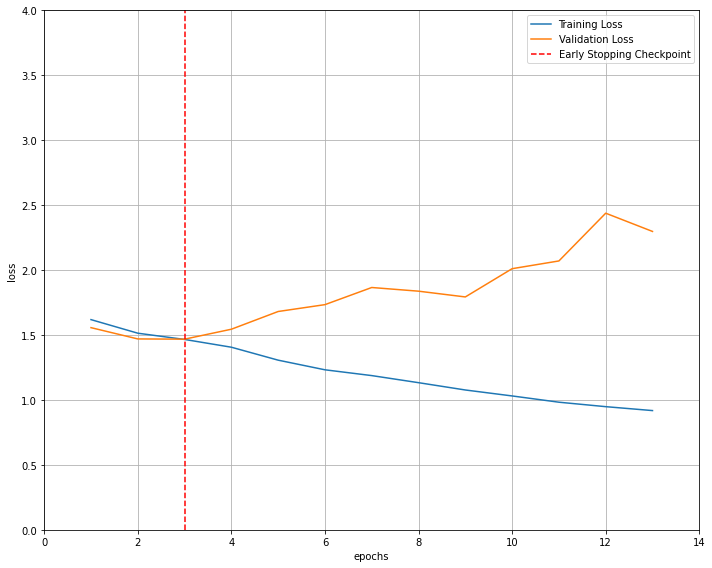

Finished analysis on User 18_attention
Starting size: (1070, 120, 8)
End size: (5350, 120, 8)
Early stopping
Fold  1! Time elapsed: 6.86293363571167 seconds
Starting size: (1203, 120, 8)
End size: (6015, 120, 8)
Early stopping
Fold  2! Time elapsed: 7.66798734664917 seconds
Starting size: (1112, 120, 8)
End size: (5560, 120, 8)
Early stopping
Fold  3! Time elapsed: 6.779833555221558 seconds
Starting size: (1185, 120, 8)
End size: (5925, 120, 8)
Early stopping
Fold  4! Time elapsed: 6.9392335414886475 seconds
Normalized confusion matrix


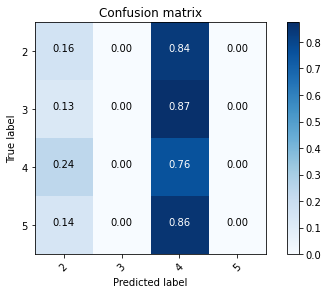

<Figure size 432x288 with 0 Axes>

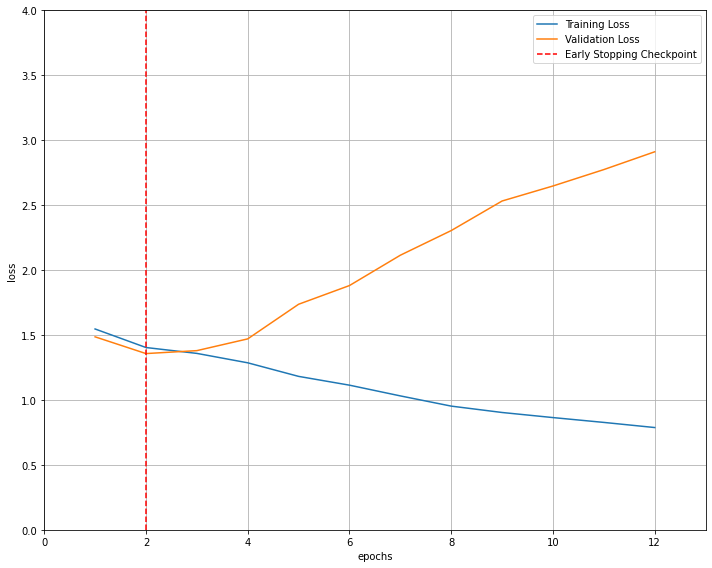

Finished analysis on User 18_interest
Starting size: (1070, 120, 8)
End size: (5350, 120, 8)
Early stopping
Fold  1! Time elapsed: 5.784964323043823 seconds
Starting size: (1203, 120, 8)
End size: (6015, 120, 8)
Early stopping
Fold  2! Time elapsed: 13.541752099990845 seconds
Starting size: (1166, 120, 8)
End size: (5830, 120, 8)
Early stopping
Fold  3! Time elapsed: 7.492026090621948 seconds
Starting size: (1112, 120, 8)
End size: (5560, 120, 8)
Early stopping
Fold  4! Time elapsed: 6.040924072265625 seconds
Starting size: (1185, 120, 8)
End size: (5925, 120, 8)
Early stopping
Fold  5! Time elapsed: 6.365307092666626 seconds
Normalized confusion matrix


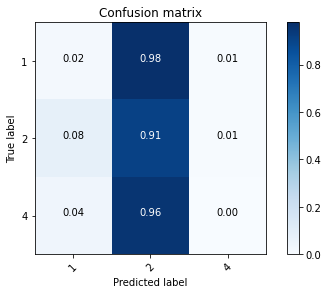

<Figure size 432x288 with 0 Axes>

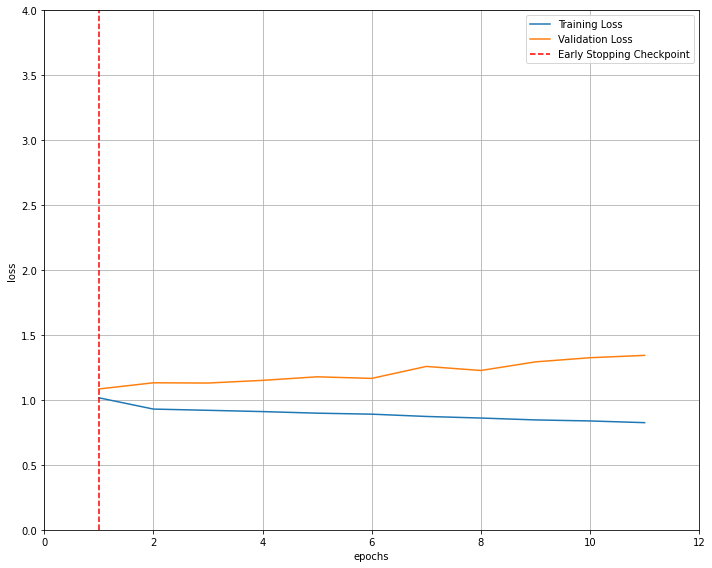

Finished analysis on User 18_effort
Finished analysis on User 18
Working on user 19
Starting size: (301, 120, 8)
End size: (1505, 120, 8)
Early stopping
Fold  1! Time elapsed: 4.858397483825684 seconds
Starting size: (298, 120, 8)
End size: (1490, 120, 8)
Early stopping
Fold  2! Time elapsed: 1.6221702098846436 seconds
Starting size: (326, 120, 8)
End size: (1630, 120, 8)
Early stopping
Fold  3! Time elapsed: 2.1434009075164795 seconds
Starting size: (322, 120, 8)
End size: (1610, 120, 8)
Early stopping
Fold  4! Time elapsed: 1.8730993270874023 seconds
Normalized confusion matrix


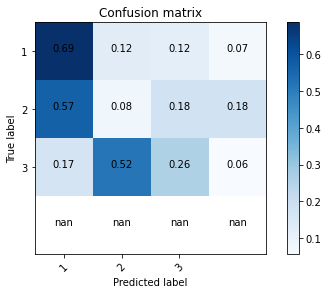

<Figure size 432x288 with 0 Axes>

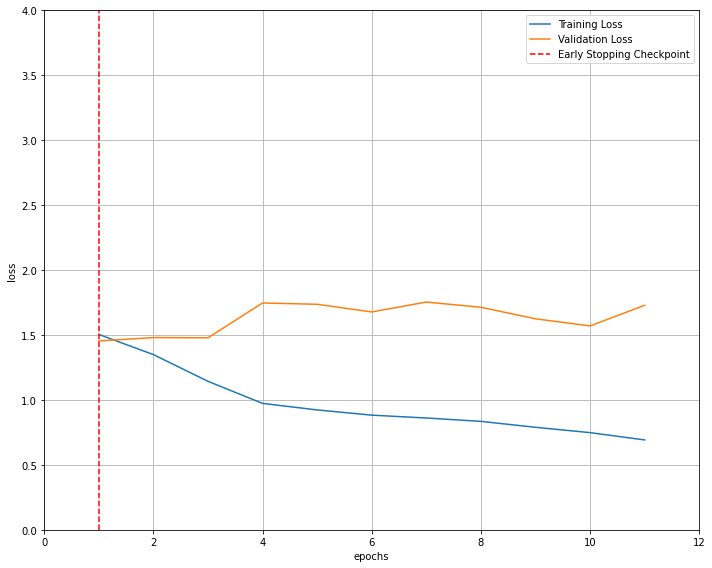

Finished analysis on User 19_attention
Starting size: (301, 120, 8)
End size: (1505, 120, 8)
Early stopping
Fold  1! Time elapsed: 10.29869294166565 seconds
Starting size: (298, 120, 8)
End size: (1490, 120, 8)
Early stopping
Fold  2! Time elapsed: 1.627821683883667 seconds
Starting size: (326, 120, 8)
End size: (1630, 120, 8)
Early stopping
Fold  3! Time elapsed: 6.888319969177246 seconds
Starting size: (322, 120, 8)
End size: (1610, 120, 8)
Early stopping
Fold  4! Time elapsed: 1.9420437812805176 seconds
Normalized confusion matrix


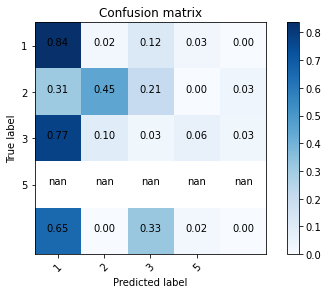

<Figure size 432x288 with 0 Axes>

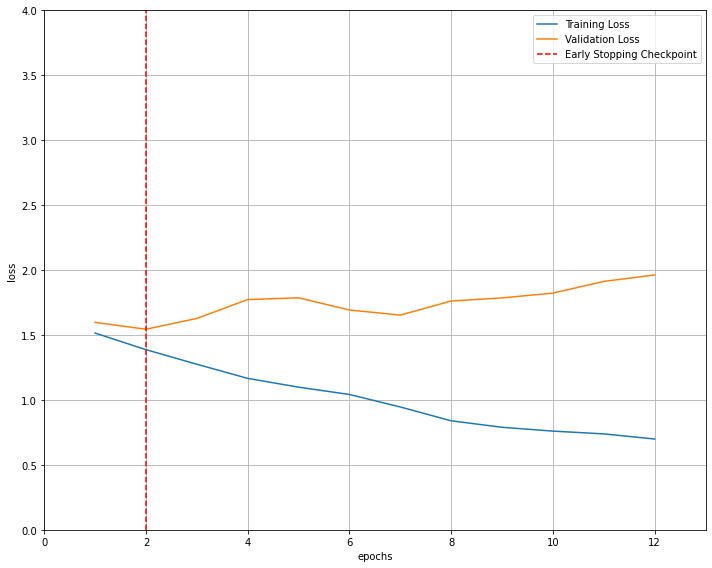

Finished analysis on User 19_interest
Starting size: (281, 120, 8)
End size: (1405, 120, 8)
Early stopping
Fold  1! Time elapsed: 2.4764511585235596 seconds
Starting size: (301, 120, 8)
End size: (1505, 120, 8)
Early stopping
Fold  2! Time elapsed: 2.364664077758789 seconds
Starting size: (298, 120, 8)
End size: (1490, 120, 8)
Early stopping
Fold  3! Time elapsed: 1.625425100326538 seconds
Starting size: (326, 120, 8)
End size: (1630, 120, 8)
Early stopping
Fold  4! Time elapsed: 5.6994805335998535 seconds
Starting size: (322, 120, 8)
End size: (1610, 120, 8)
Early stopping
Fold  5! Time elapsed: 1.9513967037200928 seconds
Normalized confusion matrix


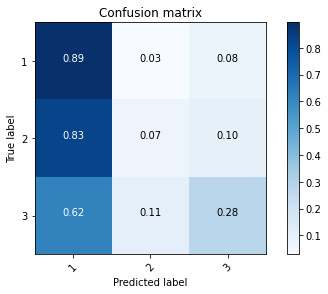

<Figure size 432x288 with 0 Axes>

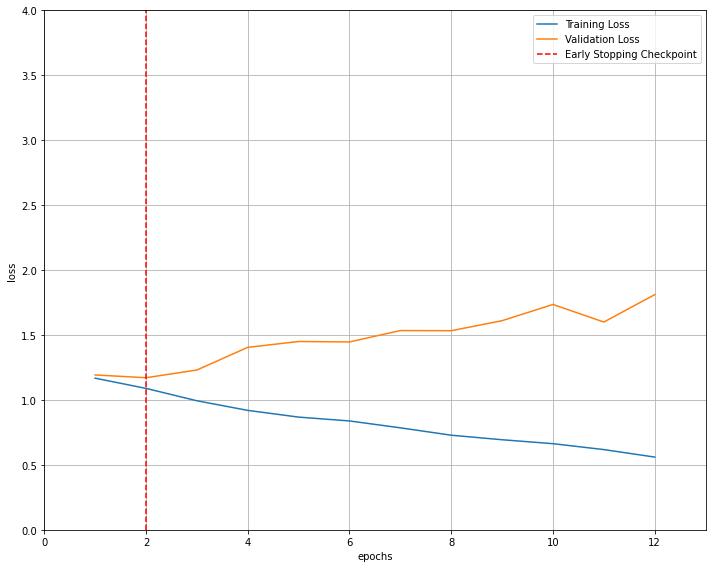

Finished analysis on User 19_effort
Finished analysis on User 19
Working on user 20
Starting size: (788, 120, 8)
End size: (3940, 120, 8)
Early stopping
Fold  1! Time elapsed: 4.293711185455322 seconds
Starting size: (975, 120, 8)
End size: (4875, 120, 8)
Early stopping
Fold  2! Time elapsed: 5.216657638549805 seconds
Starting size: (949, 120, 8)
End size: (4745, 120, 8)
Early stopping
Fold  3! Time elapsed: 6.040654182434082 seconds
Starting size: (875, 120, 8)
End size: (4375, 120, 8)
Early stopping
Fold  4! Time elapsed: 9.94556188583374 seconds
Starting size: (1021, 120, 8)
End size: (5105, 120, 8)
Early stopping
Fold  5! Time elapsed: 6.493597030639648 seconds
Normalized confusion matrix


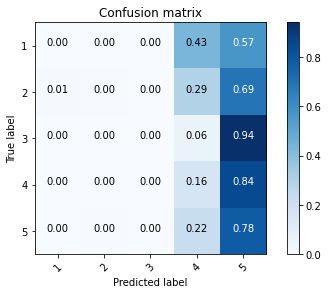

<Figure size 432x288 with 0 Axes>

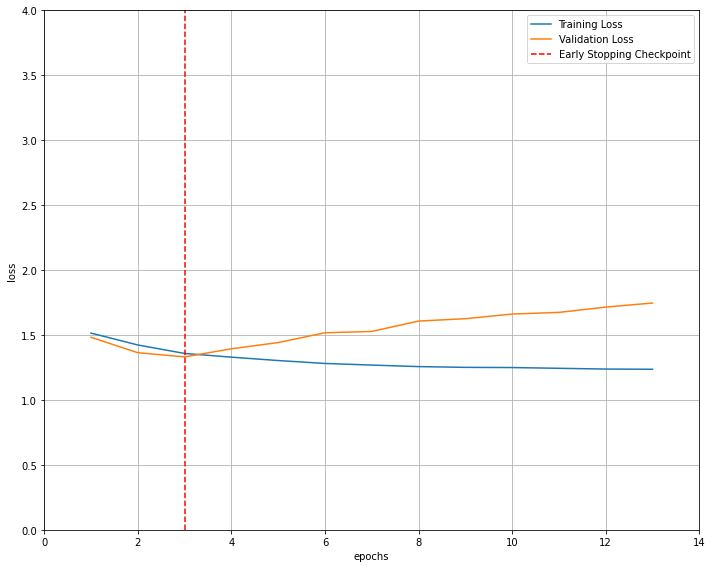

Finished analysis on User 20_attention
Starting size: (788, 120, 8)
End size: (3940, 120, 8)
Early stopping
Fold  1! Time elapsed: 4.7605273723602295 seconds
Starting size: (975, 120, 8)
End size: (4875, 120, 8)
Early stopping
Fold  2! Time elapsed: 5.25932240486145 seconds
Starting size: (949, 120, 8)
End size: (4745, 120, 8)
Early stopping
Fold  3! Time elapsed: 5.612541913986206 seconds
Starting size: (875, 120, 8)
End size: (4375, 120, 8)
Early stopping
Fold  4! Time elapsed: 6.932442903518677 seconds
Starting size: (1021, 120, 8)
End size: (5105, 120, 8)
Early stopping
Fold  5! Time elapsed: 7.525591611862183 seconds
Normalized confusion matrix


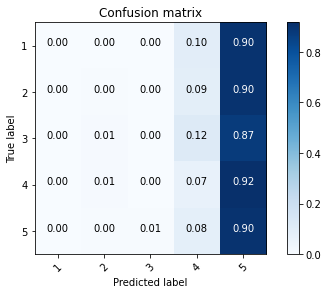

<Figure size 432x288 with 0 Axes>

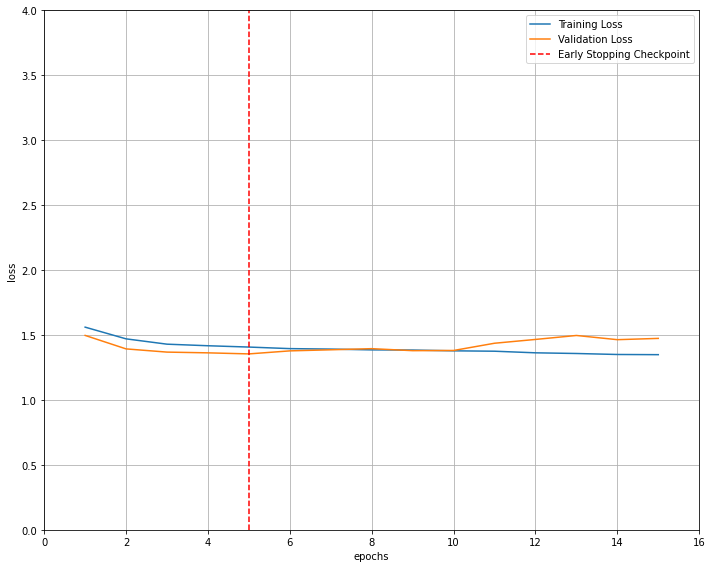

Finished analysis on User 20_interest
Starting size: (788, 120, 8)
End size: (3940, 120, 8)
Early stopping
Fold  1! Time elapsed: 7.4479615688323975 seconds
Starting size: (975, 120, 8)
End size: (4875, 120, 8)
Early stopping
Fold  2! Time elapsed: 5.24103856086731 seconds
Starting size: (949, 120, 8)
End size: (4745, 120, 8)


In [ ]:
def run_per_user(model , train_verbose, window_size_samples, fc_size, bandpass, multiple, sigma, augment,class_type):

    time_original = time.time()

    labels = ["attention", "interest", "effort"]

    n_epochs = 100

    patience = 10
    window_size_samples = 120
    saved_file = "/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_{0}_window_annotated_EEG_no_agg_bandpass_{1}_slider_{0}.pickle".format(window_size_samples, bandpass)
    all_tests = load_file(saved_file)
    users = list(all_tests.keys())
    model_type = 'clf'
    results = []
    eval_type = 'per user'
    
    for user in users:
        print("Working on user {0}".format(user))

        for label in labels:

            time_start = time.time()
            dt = all_tests[user] # dictionary of all the individual tests per user

            X = np.array([np.array(x).astype(np.float32) for x in dt['inputs']]) # array of all the inputs for each test
            y = np.array([np.array(x) for x in dt[label]]) #Convert the categories into labels

            # K fold predict 
            r, y_pred, y_true, num_classes, size, accuracy, train_loss, valid_loss = kfold_predict(X,y, model_type, 
                                                                                                   model, n_epochs, 
                                                                                                    train_verbose, patience, 
                                                                                                   fc_size, multiple, sigma, augment)
   
            # get results and add them to the list
            duration = time.time() - time_start
            results.append(collate_results(r, user, label, duration, num_classes, 
                                           size, model_type, n_epochs, window_size_samples, model, multiple, sigma, bandpass,class_type))

            #Save plots
            save_plots(model_type, y_true, y_pred, user, label, n_epochs, model, eval_type, train_loss, valid_loss, bandpass, multiple,sigma)

            print("Finished analysis on User {0}_{1}".format(user,label))
        print("Finished analysis on User {0}".format(user))
    results  = pd.DataFrame(results)
    results.to_csv("results/CNN/{3}/tabulated/k fold/{2}/{2}_performance_window_size_{0}_{1}_{4}_multiple_{5}_sigma{6}.csv".format(window_size_samples, 
                                                                                                                                       n_epochs, model, model_type, 
                                                                                                                                       eval_type, multiple, sigma), index=False )
    final_duration = time.time()- time_original
    print("All analyses are complete! Time elapsed: {0}".format(final_duration))
    return results
        
    
def run_cross_user(model , train_verbose, window_size_samples, fc_size, bandpass, multiple, sigma, augment,class_type):
    time_original = time.time()

    labels = ["attention", 'interest', 'effort']
    results = [] # save all results in this list
    patience = 10
    n_epochs = 100
    saved_file = "/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_{0}_window_annotated_EEG_agg_bandpass_{1}_slider_{0}.pickle".format(window_size_samples, bandpass)
    all_tests_agg = load_file(saved_file)
    users = all_tests_agg.keys()
    model_type = 'clf'
    user ='all'
    eval_type = 'cross user'
   

    for label in labels:
        print("Working on label {0}".format(label))
        time_start = time.time()

        # Store each user in a list to prepare for cross-user analysis
        X = np.array([all_tests_agg[user]['inputs'].astype(np.float32) for user in all_tests_agg])
        y = np.array([all_tests_agg[user][label] for user in all_tests_agg])  

        # train and make predictions
        r, y_pred, y_true, num_classes, size, accuracy, train_loss, valid_loss = kfold_predict(X,y,model_type, model,
                                                                                               n_epochs, train_verbose, 
                                                                                               patience, fc_size, multiple,sigma, augment)

         # get results
        duration = time.time() - time_start
        results.append(collate_results(r, user, label, duration, num_classes, 
                                       size, model_type, n_epochs, window_size_samples,model, multiple, sigma, bandpass, class_type))
        
        #Save plots
        save_plots(model_type, y_true, y_pred, user, label, n_epochs, model, eval_type, train_loss, valid_loss, bandpass, multiple,sigma)
                 
        print("Finished analysis on label {0}. Time elapsed {1}".format(label, time.time()-time_start))
    print("Finished analysis on User {0}".format(user))
    results_file = "results/CNN/{3}/tabulated/k fold/{2}/{2}_performance_window_size_{0}_{1}_{4}_dropout_0.9_all_labels_bandpass_{5}_multiple_{6}_sigma_{7}.csv".format(window_size_samples, n_epochs, model,
                                                                                                                                model_type, eval_type, bandpass, multiple, sigma)
    results  = pd.DataFrame(results)
    results.to_csv(results_file, index=False )
    final_duration = time.time()- time_original
    print("All analyses are complete! Time elapsed: {0}".format(final_duration))
    return results

# windows = [15, 30, 60, 120, 250]
# fc_sizes = [8, 16, 32, 56, 120]
# for window, fc_size in zip(windows, fc_sizes):

window = 120
fc_size = 56
augment = True
multiples = [5, 20, 30, 50]
sigmas = [0.001, 0.01, 0.02, 0.1, 0.2, 0.5, 0.8]
bandpass = False
class_type = 'multi'
# models = ['Hybrid', 'EEGNet']
model = 'Hybrid'
results = []
for multiple in multiples:
    for sigma in sigmas:
        results.append(run_cross_user(model, False, window, fc_size,bandpass, multiple, sigma, augment, class_type))
        results.append(run_per_user(model, False, window, fc_size,bandpass, multiple, sigma, augment, class_type))

results = pd.concat(results).to_csv("results/bulk/Hybrid_data_augmentation_test.csv", index=False)
        